# W&B Results Analysis

Pull experiment metrics from Weights & Biases, build comparison tables, and export LaTeX for the paper.

In [19]:
import os
from pathlib import Path

import wandb
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    sns = None
from dotenv import load_dotenv
from tqdm.auto import tqdm
import warnings

# Load .env from project root (parent of notebooks/)
load_dotenv(Path(__file__).resolve().parent.parent / ".env" if "__file__" in dir() else Path.cwd().parent / ".env")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="ANTLR runtime and generated code versions disagree")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.width", 200)

api = wandb.Api()

In [ ]:
# ── Configuration ──────────────────────────────────────────────────────────────
#
# Organized by dataset -> strategy. Each group entry is a dict with:
#   "group_url":  link to the wandb group workspace
#   "runs":       list of {"seed": <int>, "run_url": "<url>"}
#
# Single-group strategies (baseline, self_consistency):
#   use a single dict wrapped in a list: [{"group_url": ..., "runs": [...]}]
#
# Multi-group strategies (offline_bon, beam_search, MUR — one group per scorer/aggregation/window):
#   use a list of dicts: [{"group_url": ..., "runs": [...]}, ...]
#
# Fill in the URLs. Entries with empty group_url or runs are skipped.

# ── MATH 500 ─────────────────────────────────────────────────────────────────

MATH500_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/qz0418nv"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/3bqhwvgp"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/baseline_qwen25_math_7b_instruct_math500/runs/bjzqimk4"},
        ],
    },
]

MATH500_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/ky44b84m"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/gtia4gii"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/self_consistency_qwen25_math_7b_math500/runs/v87vmndj"},
        ],
    },
]

MATH500_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/c35z6knc"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/d7jh7cbj"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_multi_scorer/runs/cz45vmb2"},
        ],
    },
]

MATH500_OFFLINE_BON_UHEAD_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_uhead_vllm/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/offline_bon_qwen25_math_7b_instruct_math500_uhead_vllm/runs/4l0rie0z?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_all_mean/runs/jhbjo8i7?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/xwne3zcp?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/i6h64mu9?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy/runs/q4irrx7s?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/j52otygf?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/2jxse47c?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity/runs/furt84c3?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/p81rd7g2?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/xzlye3bd?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob/runs/1gqrkkbz?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/3vyvg771?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/a403svwj?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_all_mean/runs/ym9gurc8?nw=nwuserkarantonis"},
        ],
    },
        # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
        # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

MATH500_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean/runs/a5czzn30?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean/runs/j93dcmm3?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/ymsvscl0?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/pwzb338g?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean/runs/35flk5hs?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/wyx5epvb?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/6nvxalna?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean/runs/cr02x91m?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/sgz5baov?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/3aal8hbt?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean/runs/invmjf46?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/t9izflf2?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/jgwxu1tf?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_mean/runs/1hib1872?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min/runs/xsq5qs98?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min/runs/s5gopowo?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": ""},
        ],
    },
{
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/s63imxgn?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/lboffbb6?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min/runs/3ty4qabr?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/71lpyfud?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/jdneto0g?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min/runs/s704cw0h?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/i0k09agh?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/xk8esovp?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min/runs/w8p45jwz?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/9krm0sgu?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/z0sfyacp?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/beam_search_qwen25_math_7b_instruct_math500_pd_gap_window_5_min/runs/rxvhmt25?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_BEAM_SEARCH_RUNS = [
    # *MATH500_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *MATH500_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *MATH500_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *MATH500_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

MATH500_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/vd5vmy7u"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/1a781e39"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_prm/runs/rj4rt3i2"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/tfztdzjl"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/ggqllnmy"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_entropy/runs/aw88mzyl"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/r6oumz5s"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/4ds5ewag"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_perplexity/runs/5xe2x66l"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/j9a1j7mx"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/zcdc7nni"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_sequence_prob/runs/otrelz7z"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_uncertainty_pd/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_uncertainty_pd/runs/alb267ge?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_uncertainty_pd/runs/csps436w?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-math500/groups/adaptive_scaling_qwen25_math_7b_instruct_math500_uncertainty_pd/runs/qdng2lkw?nw=nwuserkarantonis"},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MATH500_RUNS = [
    *MATH500_BASELINE_RUNS,
    *MATH500_SELF_CONSISTENCY_RUNS,
    *MATH500_OFFLINE_BON_RUNS,
    *MATH500_OFFLINE_BON_UHEAD_RUNS,
    *MATH500_BEAM_SEARCH_RUNS,
    *MATH500_MUR_RUNS,
]

In [104]:
{
    "group_url": "",
    "runs": [
        {"seed": 42, "run_url": ""},
        {"seed": 43, "run_url": ""},
        {"seed": 44, "run_url": ""},
    ],
},

({'group_url': '',
  'runs': [{'seed': 42, 'run_url': ''},
   {'seed': 43, 'run_url': ''},
   {'seed': 44, 'run_url': ''}]},)

In [105]:
# ── OlympiadBench ────────────────────────────────────────────────────────────

OLYMPIAD_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/jzmy8hfc"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/xlys9l9j"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/baseline_qwen25_math_7b_instruct_olympiadbench/runs/b72k2bg3"},
        ],
    },
]

OLYMPIAD_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/fvfzlj30"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/ig5z868b"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/self_consistency_qwen25_math_7b_instruct_olympiadbench/runs/ivwtmfrj"},
        ],
    },
]

OLYMPIAD_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/scg2r5g6"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/lrbsr0b6"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_multi_scorer/runs/gzpylxq2"},
        ],
    },
]

OLYMPIAD_OFFLINE_BON_UHEAD_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_uhead_vllm/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/offline_bon_qwen25_math_7b_instruct_olympiadbench_uhead_vllm/runs/bjfh6fuh?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_all_mean/runs/gui7679t?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy/runs/c6nirtgs?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy/runs/tvpfucx4?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy/runs/juur2mnv?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/xnf5gmhd?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/ljtva92n?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/npatzl31?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/g42a9xqq?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/o3mip5c4?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/c0jumd2j?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_all_mean/runs/50n5dhow?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_all_mean/runs/kpnzm4md?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_all_mean/runs/h69ak088?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

OLYMPIAD_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_mean/runs/887ddodl?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_mean/runs/522b5ewj?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_mean/runs/erqi0w5r?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_mean/runs/qc0wn4q6?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_mean/runs/bpgur362?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_mean/runs/gb0mtnvx?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_mean/runs/lgbztevg?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_mean/runs/qod2k0j9?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_mean/runs/jnthrv56?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_mean/runs/pw48cch0?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_mean/runs/jilv4iwk?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_mean/runs/43r2f1wt?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_mean/runs/jq2jj0lf?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_mean/runs/fdzegtse?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_min/runs/zqlktvg3?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_min/runs/ygh7bxal?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_min/runs/6bqzf022?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_min/runs/pqo1b5f6?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_min/runs/nhi6skmj?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_min/runs/piujnzhv?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_min/runs/5u73qqas?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_min/runs/egbj74e1?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_min/runs/h6v1qr2v?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_min/runs/3auslh8z?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_min/runs/9j9zb1s8?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_min/runs/nrliz7lv?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/beam_search_qwen25_math_7b_instruct_olympiadbench_pd_gap_window_5_min/runs/85lk7n3t?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

OLYMPIAD_BEAM_SEARCH_RUNS = [
    *OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *OLYMPIAD_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

OLYMPIAD_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/i6z1krhj"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/6wvon0ez"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_prm/runs/tdm1eork"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/vd94h0mo"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/wf7xwmeq"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_entropy/runs/mysyvdxk"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/v94x4z5v"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/j0wpb22k"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_perplexity/runs/ma4yye4m"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/9yrxl5jg"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/ux4lvczy"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_sequence_prob/runs/3i0vyyzt"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_uncertainty_pd/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_uncertainty_pd/runs/xcooiyeg?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_uncertainty_pd/runs/0h96fgd9?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-olympiadbench/groups/adaptive_scaling_qwen25_math_7b_instruct_olympiadbench_uncertainty_pd/runs/sysmud1n?nw=nwuserkarantonis"},
        ],
    },
]

OLYMPIAD_RUNS = [
    *OLYMPIAD_BASELINE_RUNS,
    *OLYMPIAD_SELF_CONSISTENCY_RUNS,
    *OLYMPIAD_OFFLINE_BON_RUNS,
    *OLYMPIAD_OFFLINE_BON_UHEAD_RUNS,
    *OLYMPIAD_BEAM_SEARCH_RUNS,
    *OLYMPIAD_MUR_RUNS,
]

In [106]:
# ── Minerva Math ─────────────────────────────────────────────────────────────

MINERVA_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/96zj1bj9"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/uyw4bmip"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/baseline_qwen25_math_7b_instruct_minerva_math/runs/qmm3t3wa"},
        ],
    },
]

MINERVA_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/pnfkhzub"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/puabpgai"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/self_consistency_qwen25_math_7b_minerva_math/runs/697xpya5"},
        ],
    },
]

MINERVA_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer/runs/7syo0ks4"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/offline_bon_qwen25_math_7b_instruct_minerva_math_multi_scorer/runs/y6udmktu"},
            # TODO: seed 44
        ],
    },
]

MINERVA_OFFLINE_BON_UHEAD_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_all_mean/runs/snoxhz7b?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy/runs/962poto8?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy/runs/6s17gujf?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy/runs/pf024sdv?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity/runs/yt9mipkh?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity/runs/795b6z27?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity/runs/za5yp87g?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/4q8i8qwa?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/retc9zoi?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/1fmcdnsh?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_all_mean/runs/zl7hftku?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_all_mean/runs/xu155a3m?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_all_mean/runs/e201qmog?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

MINERVA_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_5_mean/runs/j4fguv8x?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_mean/runs/wc2stpgz?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_mean/runs/t2jniehz?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_mean/runs/kcfrods7?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_mean/runs/hf1vxco1?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_mean/runs/6y85bwv6?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_mean/runs/wswknexj?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_mean/runs/b7g1qnn1?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_mean/runs/ry44lrr9?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_mean/runs/yqg5cn6j?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_mean/runs/xmcus55r?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_mean/runs/hvw2hvjr?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_mean/runs/nvehp4ya?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_prm_window_5_min/runs/vj9qje88?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_min/runs/xbxg75pr?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_min/runs/mu1d5ny2?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_entropy_window_5_min/runs/ku1zd1x8?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_min/runs/gq4xwrgy?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_min/runs/ujdvj8w8?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_perplexity_window_5_min/runs/d7zsrmx3?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_min/runs/eninrzri?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_min/runs/dkvyuo46?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_sequence_prob_window_5_min/runs/b106fzn7?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_min/runs/j2ahm5j6?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_min/runs/b1p9fcl8?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/beam_search_qwen25_math_7b_instruct_minerva_math_pd_gap_window_5_min/runs/5avu312g?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

MINERVA_BEAM_SEARCH_RUNS = [
    *MINERVA_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *MINERVA_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *MINERVA_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *MINERVA_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

MINERVA_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/06l86wmp"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/rj3c55xp"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva-math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_prm/runs/mqxinev9"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/6x67bplt"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/9byp8if5"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_entropy/runs/baw3autg"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/fdqevqae"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/v9d5f19e"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_perplexity/runs/1kotu42g"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/hhvycd8w"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/u9jsfizr"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_sequence_prob/runs/s1mch3ag"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_uncertainty_pd/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_uncertainty_pd/runs/u05a1i4m?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_uncertainty_pd/runs/vg6jcpn8?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-minerva_math/groups/adaptive_scaling_qwen25_math_7b_instruct_minerva_math_uncertainty_pd/runs/i6rpgyy0?nw=nwuserkarantonis"},
        ],
    },
]

MINERVA_RUNS = [
    *MINERVA_BASELINE_RUNS,
    *MINERVA_SELF_CONSISTENCY_RUNS,
    *MINERVA_OFFLINE_BON_RUNS,
    *MINERVA_OFFLINE_BON_UHEAD_RUNS,
    *MINERVA_BEAM_SEARCH_RUNS,
    *MINERVA_MUR_RUNS,
]

In [ ]:
# ── Gaokao 2023 EN ──────────────────────────────────────────────────────────

GAOKAO_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/kv4jtvgi"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/oj4i6jcg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/baseline_qwen25_math_7b_instruct_gaokao2023en/runs/9jdwpyk5"},
        ],
    },
]

GAOKAO_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/fr4b84ia"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/cbuxlxty"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/self_consistency_qwen25_math_7b_gaokao2023en/runs/66ny6wia"},
        ],
    },
]

GAOKAO_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/qijvr95c"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/jboxbdly"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_multi_scorer/runs/nh8fx6pk"},
        ],
    },
]

GAOKAO_OFFLINE_BON_UHEAD_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_uhead_vllm/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/offline_bon_qwen25_math_7b_instruct_gaokao2023en_uhead_vllm/runs/d8ghfxec?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_all_mean/runs/8l7qf6cl?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/kn00hw5t?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/3xobx7ih?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/9pdu6tur?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/3o578w75?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/r4i8by0h?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/e2l89n6w?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/fsd1tf66?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/163131v4?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/hp1hq4ff?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_all_mean/runs/jk68metq?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_all_mean/runs/cylhbr2h?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_all_mean/runs/ykypchxu?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = []

GAOKAO_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_mean/runs/1r6s9ry7?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_mean/runs/8725k7ax?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_mean/runs/r3dru40w?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_mean/runs/jlvs82nj?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_mean/runs/p160naq9?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_mean/runs/9me7ishc?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_mean/runs/o5cr0fzk?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_mean/runs/cwq73748?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_mean/runs/1ou0luos?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_mean/runs/dd3hr4mn?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_mean/runs/5t8lox6l?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_mean/runs/05wxrqgd?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_mean/runs/piuuulyg?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_mean/runs/t8kw05ga?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_min/runs/jtrfp35y?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_min/runs/75zw5ooq?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_min/runs/ne22jlrg?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_min/runs/6h66d1po?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_min/runs/yn24c04k?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_min/runs/lsfbd32c?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_min/runs/9sdcszbf?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_min/runs/csx4i9xa?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_min/runs/c7uiu5rq?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_min/runs/s980hhyq?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_min/runs/vu34zpxx?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_min/runs/15es444b?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/beam_search_qwen25_math_7b_instruct_gaokao2023en_pd_gap_window_5_min/runs/td9u11e7?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

GAOKAO_BEAM_SEARCH_RUNS = [
    *GAOKAO_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *GAOKAO_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *GAOKAO_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *GAOKAO_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]


GAOKAO_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/s0fidl75"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/0ualpblk"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_prm/runs/32rg3g3i"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/hi6vme52"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/8803ke4z"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_entropy/runs/2b58rqn2"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/nzfniz34?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/t72yerk9"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_perplexity/runs/udabjan5"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/w39yrjlx"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/tg0re0ml"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_sequence_prob/runs/h8ceyznr"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_uncertainty_pd/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_uncertainty_pd/runs/cof8zdfa?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_uncertainty_pd/runs/fvfx85er?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-gaokao2023en/groups/adaptive_scaling_qwen25_math_7b_instruct_gaokao2023en_uncertainty_pd/runs/yx8s5z64?nw=nwuserkarantonis"},
        ],
    },
]

GAOKAO_RUNS = [
    *GAOKAO_BASELINE_RUNS,
    *GAOKAO_SELF_CONSISTENCY_RUNS,
    *GAOKAO_OFFLINE_BON_RUNS,
    *GAOKAO_OFFLINE_BON_UHEAD_RUNS,
    *GAOKAO_BEAM_SEARCH_RUNS,
    *GAOKAO_MUR_RUNS,
]

In [108]:
# ── GPQA Diamond ─────────────────────────────────────────────────────────────

GPQA_BASELINE_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_EXTENDED_THINKING_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_SELF_CONSISTENCY_RUNS = [
    {"group_url": "", "runs": []},
]

GPQA_OFFLINE_BON_RUNS = []

GPQA_BEAM_SEARCH_RUNS = []

GPQA_RUNS = [
    *GPQA_BASELINE_RUNS,
    *GPQA_EXTENDED_THINKING_RUNS,
    *GPQA_SELF_CONSISTENCY_RUNS,
    *GPQA_OFFLINE_BON_RUNS,
    *GPQA_BEAM_SEARCH_RUNS,
]

In [109]:
# ── AIME 2024 ────────────────────────────────────────────────────────────────

AIME_24_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/xusm290p"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/rb5f45zd"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/ue7upatj"},
            {"seed": 45, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/2pxd5k62"},
            {"seed": 46, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/7wjepb0g"},
            {"seed": 47, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/baseline_qwen3_8b_thinking_aime2024/runs/mmvefyvq"},
        ],
    },
]

AIME_24_EXTENDED_THINKING_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/zpdp973a"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/toj7if32"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/extended_thinking_qwen3_8b_thinking_aime2024/runs/nofu424d"},
        ],
    },
]

AIME_24_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/myd2mv7s"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/xffzht86"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/self_consistency_qwen3_8b_thinking_aime2024/runs/1pwqvj98"},
        ],
    },
]

AIME_24_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/sx8686xk?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/yma1zbec?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/offline_bon_qwen3_8b_thinking_aime2024_multi_scorer/runs/jrvn9z5v?nw=nwuserkarantonis"},
        ],
    },
]

{
    "group_url": "",
    "runs": [
        {"seed": 42, "run_url": ""},
        {"seed": 43, "run_url": ""},
        {"seed": 44, "run_url": ""},
    ],
},

AIME_24_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    # TODO
]

AIME_24_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = [
    # TODO
]

AIME_24_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    # TODO
]

AIME_24_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_prm_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_prm_window_5_min/runs/efg8ecwr?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_prm_window_5_min/runs/aqnb3zq1?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_prm_window_5_min/runs/oyhmkas7?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_entropy_window_5_min/runs/0wbteyc1?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_entropy_window_5_min/runs/vchbohcx?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_entropy_window_5_min/runs/qezpea3j?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_perplexity_window_5_min/runs/9n2x29ps?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_perplexity_window_5_min/runs/7xincnfz?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_perplexity_window_5_min/runs/ezyltca8?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_sequence_prob_window_5_min/runs/8vgy2ikx?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_sequence_prob_window_5_min/runs/6d681pee?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_sequence_prob_window_5_min/runs/6b5viy72?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_pd_gap_window_5_min/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_pd_gap_window_5_min/runs/hbdy4fcn?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_pd_gap_window_5_min/runs/4uuttpo2?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/beam_search_qwen3_8b_thinking_aime2024_pd_gap_window_5_min/runs/8tdyfcry?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

AIME_24_BEAM_SEARCH_RUNS = [
    *AIME_24_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *AIME_24_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *AIME_24_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *AIME_24_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

AIME_24_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/it11687o"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/jff7wjvc"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_prm/runs/lkq82tbw"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/0e8v1y8k"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/0ohmk93u"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_entropy/runs/r3835jcu"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/6akbzucw"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/mqw6z61b"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_perplexity/runs/27slpoyj"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/siootyv4"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/pbeoa8wj"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2024/groups/adaptive_scaling_qwen3_8b_aime2024_sequence_prob/runs/ehlo2jyt"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime24/groups/adaptive_scaling_qwen3_8b_aime2024_uncertainty_pd/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime24/groups/adaptive_scaling_qwen3_8b_aime2024_uncertainty_pd/runs/ogtic3r3?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime24/groups/adaptive_scaling_qwen3_8b_aime2024_uncertainty_pd/runs/l8o7jyti?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime24/groups/adaptive_scaling_qwen3_8b_aime2024_uncertainty_pd/runs/q81qvm2k?nw=nwuserkarantonis"},
        ],
    },
]

AIME_24_RUNS = [
    *AIME_24_BASELINE_RUNS,
    *AIME_24_EXTENDED_THINKING_RUNS,
    *AIME_24_SELF_CONSISTENCY_RUNS,
    *AIME_24_OFFLINE_BON_RUNS,
    *AIME_24_BEAM_SEARCH_RUNS,
    *AIME_24_MUR_RUNS,
]

In [110]:
# ── AIME 2025 ────────────────────────────────────────────────────────────────

AIME_25_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/5z4xazfd"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/z8961dmg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/vqkeqd8l"},
            {"seed": 45, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/8ng35cm8"},
            {"seed": 46, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/y6l7gl0x"},
            {"seed": 47, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/baseline_qwen3_8b_thinking_aime2025/runs/bvz1mgw4"},
        ],
    },
]

AIME_25_EXTENDED_THINKING_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/ynjskyb9"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/xw5oie56"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/extended_thinking_qwen3_8b_thinking_aime2025/runs/uufgljky"},
        ],
    },
]

AIME_25_SELF_CONSISTENCY_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/e03jj1df"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/4o5fp278"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/self_consistency_qwen3_8b_thinking_aime2025/runs/yvpwgde3"},
        ],
    },
]

AIME_25_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/1cwevp55"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/ahbar3j1"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/offline_bon_qwen3_8b_thinking_aime2025_multi_scorer/runs/rj0hw4tp"},
        ],
    },
]

{
    "group_url": "",
    "runs": [
        {"seed": 42, "run_url": ""},
        {"seed": 43, "run_url": ""},
        {"seed": 44, "run_url": ""},
    ],
},

AIME_25_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    # TODO
]

AIME_25_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = [
    # TODO
]

AIME_25_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    # TODO
]

AIME_25_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_prm_window_5_min/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_prm_window_5_min/runs/ywizo975?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_prm_window_5_min/runs/czvdxny7?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_prm_window_5_min/runs/o492bbgp?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_entropy_window_5_min/runs/lb0vi3qq?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_entropy_window_5_min/runs/kjwuwim7?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_entropy_window_5_min/runs/utufdnzh?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_perplexity_window_5_min/runs/awws51rg?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_perplexity_window_5_min/runs/qa0rie01?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_perplexity_window_5_min/runs/yhhex0za?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_sequence_prob_window_5_min/runs/mi125juu?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_sequence_prob_window_5_min/runs/7drttyjt?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_sequence_prob_window_5_min/runs/0fsfajui?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_pd_gap_window_5_min/runs/ohpmnuco?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_pd_gap_window_5_min/runs/j5m8fw00?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime2025/groups/beam_search_qwen3_8b_thinking_aime2025_pd_gap_window_5_min/runs/7g1zrrcp?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

AIME_25_BEAM_SEARCH_RUNS = [
    *AIME_25_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *AIME_25_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *AIME_25_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *AIME_25_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

AIME_25_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/e42u6g0w"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/3nne68cg"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_prm/runs/upxrnkxo"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/d8m88x5o"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/hor6ahou"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_entropy/runs/exlootac"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/3hsaelln"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/jertvzag"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_thinking_qwen3_8b_aime2025_perplexity/runs/8o0wi4y3"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/tce8t6fy"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/krs5db1u"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_sequence_prob/runs/1ieu2i5k"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_pd_gap/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_pd_gap/runs/8xyihgpg?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_pd_gap/runs/pjd975tp?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-eval-aime25/groups/adaptive_scaling_qwen3_8b_aime2025_pd_gap/runs/8tfhs5vs?nw=nwuserkarantonis"},
        ],
    },
]

AIME_25_RUNS = [
    *AIME_25_BASELINE_RUNS,
    *AIME_25_EXTENDED_THINKING_RUNS,
    *AIME_25_SELF_CONSISTENCY_RUNS,
    *AIME_25_OFFLINE_BON_RUNS,
    *AIME_25_BEAM_SEARCH_RUNS,
    *AIME_25_MUR_RUNS,
]

In [111]:
# ── HumanEval-Plus ────────────────────────────────────────────────────────────

[
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_BASELINE_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/baseline_vllm_qwen3_8b_human_eval_plus/workspace",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/baseline_vllm_qwen3_8b_human_eval_plus/runs/qzbpq9t0?nw=nwuserkarantonis"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/baseline_vllm_qwen3_8b_human_eval_plus/runs/h770ka3u?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/baseline_vllm_qwen3_8b_human_eval_plus/runs/p140hiwl?nw=nwuserkarantonis"},
        ],
    },
]

HUMANEVAL_EXTENDED_THINKING_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/extended_thinking_qwen3_8b_thinking_human_eval_plus/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/extended_thinking_qwen3_8b_thinking_human_eval_plus/runs/lnysauwr?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/extended_thinking_qwen3_8b_thinking_human_eval_plus/runs/rco0ur3e?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/extended_thinking_qwen3_8b_thinking_human_eval_plus/runs/g8zegkd1?nw=nwuserkarantonis"},
        ],
    },
]

HUMANEVAL_SELF_CONSISTENCY_RUNS = []

HUMANEVAL_OFFLINE_BON_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/offline_bon_qwen3_8b_thinking_human_eval_plus_multi_scorer/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/offline_bon_qwen3_8b_thinking_human_eval_plus_multi_scorer/runs/z6vgbfcb?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/offline_bon_qwen3_8b_thinking_human_eval_plus_multi_scorer/runs/gij2g92w?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/offline_bon_qwen3_8b_thinking_human_eval_plus_multi_scorer/runs/hoitoy74?nw=nwuserkarantonis"},
        ],
    },
]

HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS = [
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_all_mean/workspace?nw=nwuserkarantonis",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_all_mean/runs/iidhfsiz?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_all_mean/runs/uvbw2kl5?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_all_mean/runs/e3a0rcup?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_all_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_all_mean/runs/7pzh9edt?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MIN_RUNS = [
    {
        # TODO: add prm
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_all_min/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_all_min/runs/a9s20fwf?nw=nwusertsowehh"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_all_min/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_all_min/runs/48wc71cj?nw=nwusertsowehh"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_all_min/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_all_min/runs/su5e8s4i?nw=nwusertsowehh"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_all_min/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_all_min/runs/xsb1hp9g?nw=nwusertsowehh"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_BEAM_SEARCH_5_STEPS_MEAN_RUNS = [
    {
        # TODO: add prm
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_mean/runs/jwnf1dsb?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_mean/runs/0c7179qy?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_mean/runs/9ig7966n?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_mean/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_mean/runs/r0mics7n?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_BEAM_SEARCH_5_STEPS_MIN_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_prm_window_5_min/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_prm_window_5_min/runs/mwv3ydot?nw=nwusertsowehh"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_prm_window_5_min/runs/diqjyser?nw=nwusertsowehh"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_prm_window_5_min/runs/vuu8s1u9?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_min/runs/wp534gi0?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_min/runs/u69i5npi?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_entropy_window_5_min/runs/niswh0x4?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_min/runs/6p6w68ul?nw=nwuserkarantonis"},
            {"seed": 43, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_min/runs/4g46bojf?nw=nwuserkarantonis"},
            {"seed": 44, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_perplexity_window_5_min/runs/4vo3nvau?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_min/runs/yui20oq0?nw=nwuserkarantonis"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_min/runs/hkqix9z9?nw=nwuserkarantonis"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_sequence_prob_window_5_min/runs/yjnynyg8?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_min/workspace",
        "runs": [
            {"seed": 42, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_min/runs/w72n3060?nw=nwuserkarantonis"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_min/runs/oi9zfd3c?nw=nwuserkarantonis"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/beam_search_qwen3_8b_thinking_human_eval_plus_pd_gap_window_5_min/runs/c4bjiwrf?nw=nwuserkarantonis"},
        ],
    },
    # TODO: LLM_AS_A_CRITIC
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_BEAM_SEARCH_RUNS = [
    *HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
    *HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
    *HUMANEVAL_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
    *HUMANEVAL_BEAM_SEARCH_5_STEPS_MIN_RUNS,
]

HUMANEVAL_MUR_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_prm/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_prm/runs/axsgb0lp?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_prm/runs/sq0dlul0?nw=nwuserkarantonis"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_prm/runs/2218589y?nw=nwuserkarantonis"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_entropy/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_entropy/runs/4g5ugn1v?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_entropy/runs/3d4dfaib?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_entropy/runs/pddw65g8?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_perplexity/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_perplexity/runs/8empwbo4?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_perplexity/runs/t3w67irm?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_perplexity/runs/19mq91wj?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_sequence_prob/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_sequence_prob/runs/hgp1pfn6?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_sequence_prob/runs/uorbvzui?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_sequence_prob/runs/af7aitxx?nw=nwusertsowehh"},
        ],
    },
    # TODO: PD Gap
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_pd_gap/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_pd_gap/runs/2msp2y82?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_pd_gap/runs/05gsk86b?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/adaptive_scaling_vllm_qwen3_8b_human_eval_plus_pd_gap/runs/6kxvjp71?nw=nwusertsowehh"},
        ],
    },
    # TODO: UHEAD
    {
        "group_url": "",
        "runs": [
            {"seed": 42, "run_url": ""},
            {"seed": 43, "run_url": ""},
            {"seed": 44, "run_url": ""},
        ],
    },
]

HUMANEVAL_UNCERT_COT_RUNS = [
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_token/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_token/runs/6fgi9n09?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_token/runs/gnn7ahby?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_token/runs/wqs9v6ae?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_sequence/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_sequence/runs/e7ctq9st?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_sequence/runs/ip36uwc1?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_uncertainty_pd_sequence/runs/vuhbms4x?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "google.com/url?q=https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_token/workspace?nw%3Dnwusertsowehh&sa=D&source=editors&ust=1772036156047322&usg=AOvVaw26Cbh70Rj96_KcWeFRONGm",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_token/runs/010jjrzq?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_token/runs/513w9284?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_token/runs/1kn618b3?nw=nwusertsowehh"},
        ],
    },
    {
        "group_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_sequence/workspace?nw=nwusertsowehh",
        "runs": [
            {"seed": 0, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_sequence/runs/ztolj97l?nw=nwusertsowehh"},
            {"seed": 1, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_sequence/runs/5uwi8jld?nw=nwusertsowehh"},
            {"seed": 2, "run_url": "https://wandb.ai/nlpresearch.group/llm-tts-human-eval-plus/groups/uncert_cot_vllm_qwen3_8b_human_eval_plus_entropy_sequence/runs/8x8numy8?nw=nwusertsowehh"},
        ],
    },
]

HUMANEVAL_RUNS = [
    *HUMANEVAL_BASELINE_RUNS,
    *HUMANEVAL_EXTENDED_THINKING_RUNS,
    *HUMANEVAL_OFFLINE_BON_RUNS,
    *HUMANEVAL_BEAM_SEARCH_RUNS,
    *HUMANEVAL_MUR_RUNS,
    *HUMANEVAL_UNCERT_COT_RUNS,
]


In [112]:
# ── All experiments ──────────────────────────────────────────────────────────

EXPERIMENT_RUNS = [
    *MATH500_RUNS,
    *MINERVA_RUNS,
    *GAOKAO_RUNS,
    *OLYMPIAD_RUNS,
    *GPQA_RUNS,
    *AIME_24_RUNS,
    *AIME_25_RUNS,
    *HUMANEVAL_RUNS,
]

# Which evaluator metric to use as the primary accuracy column
PRIMARY_EVALUATOR = "exact_match"  # or "llm_judge"

GROUP_FILTERS = None  # e.g. ["beam_search", "offline_bon"]

## Seed Coverage Tables

Quick overview of how many seeds (1/2/3) are registered for each (strategy, scorer, dataset) combination.

In [113]:
# ── Seed Coverage: Qwen2.5-Math-7B-Instruct (Non-Thinking) ─────────────────

import re as _re
from urllib.parse import urlparse as _urlparse


def _extract_scorer_from_group_url(url: str) -> str:
    """Extract scorer name from group URL group segment (after /groups/)."""
    path = _urlparse(url).path.strip("/")
    parts = path.split("/")
    # Take the segment right after 'groups/' — ignores trailing /workspace etc.
    try:
        group = parts[parts.index("groups") + 1]
    except (ValueError, IndexError):
        group = parts[-1]
    # Check longest names first to avoid partial matches
    # uncertainty_pd is an alias for pd_gap
    group = group.replace("uncertainty_pd", "pd_gap")
    for scorer in ["sequence_prob", "llm_critic", "multi_scorer",
                   "pd_gap", "prm", "entropy", "perplexity", "uhead"]:
        if group.endswith(f"_{scorer}") or f"_{scorer}_" in group:
            return scorer
    return ""


def _count_seeds_with_url(run_list: list) -> tuple:
    """Count total seeds and return group URL. Returns (count, url)."""
    total = 0
    url = ""
    for entry in run_list:
        if entry.get("group_url"):
            total += sum(1 for r in entry.get("runs", []) if r.get("run_url"))
            if not url:
                url = entry["group_url"]
    return total, url


def _derive_group_url(entry: dict) -> str:
    """Get group_url from entry, falling back to deriving it from a run_url."""
    if entry.get("group_url"):
        return entry["group_url"]
    for run in entry.get("runs", []):
        url = run.get("run_url", "")
        if url and "/groups/" in url:
            # Reconstruct a group URL from the run URL
            # run_url: https://host/entity/project/groups/GROUP/runs/ID
            parts = url.split("/runs/")
            return parts[0]  # everything up to /runs/RUN_ID
    return ""


def _count_seeds_by_scorer_with_url(run_list: list) -> dict:
    """Count seeds per scorer with group URLs. Returns {scorer: (count, url)}."""
    result = {}
    for entry in run_list:
        group_url = _derive_group_url(entry)
        if not group_url:
            continue
        scorer = _extract_scorer_from_group_url(group_url)
        n = sum(1 for r in entry.get("runs", []) if r.get("run_url"))
        result[scorer] = (n, group_url)
    return result


def _color_cell(n_seeds, url=""):
    """Return styled HTML for seed count, optionally as a clickable link."""
    colors = {0: "#e74c3c", 1: "#e67e22", 2: "#f1c40f", 3: "#27ae60"}
    bg = {0: "#fdedec", 1: "#fdebd0", 2: "#fef9e7", 3: "#eafaf1"}
    style = (
        f'background:{bg.get(n_seeds, "#eee")};'
        f'padding:2px 8px;border-radius:3px;'
        f'color:{colors.get(n_seeds, "#333")};font-weight:bold'
    )
    if url:
        return (
            f'<a href="{url}" target="_blank" '
            f'style="{style};text-decoration:none">{n_seeds}</a>'
        )
    return f'<span style="{style}">{n_seeds}</span>'


def build_coverage_table(title, coverage_map, datasets, strategy_order, strategy_labels,
                         multi_scorer_strategies=None, scorer_list=None,
                         scorer_overrides=None):
    """Build an HTML coverage table with rowspan-merged strategy cells.

    Args:
        title: Table heading.
        coverage_map: {dataset: {strategy_key: run_list, ...}, ...}
        datasets: Column order for datasets.
        strategy_order: Row order for strategies.
        strategy_labels: {strategy_key: display_name}
        multi_scorer_strategies: Set of strategy keys that have per-scorer breakdowns.
        scorer_list: Ordered list of scorers for multi-scorer strategies.
    """
    if multi_scorer_strategies is None:
        multi_scorer_strategies = set()
    if scorer_list is None:
        scorer_list = ["prm", "entropy", "perplexity", "sequence_prob", "pd_gap"]
    if scorer_overrides is None:
        scorer_overrides = {}

    # Build row specs: list of (strategy_label, scorer, {ds: (count, url)})
    row_specs = []
    for strat in strategy_order:
        label = strategy_labels.get(strat, strat)
        if strat in multi_scorer_strategies:
            for scorer in scorer_overrides.get(strat, scorer_list):
                cells = {}
                for ds in datasets:
                    by_scorer = _count_seeds_by_scorer_with_url(coverage_map[ds][strat])
                    cells[ds] = by_scorer.get(scorer, (0, ""))
                row_specs.append((label, scorer, cells))
        else:
            cells = {}
            for ds in datasets:
                cells[ds] = _count_seeds_with_url(coverage_map[ds][strat])
            row_specs.append((label, "", cells))

    # Compute rowspans per strategy group
    from collections import Counter
    strategy_counts = Counter(r[0] for r in row_specs)

    th = 'style="padding:6px 12px;border-bottom:2px solid #333;text-align:center"'
    html = f"<h3>{title}</h3>"
    html += '<table style="border-collapse:collapse;font-family:sans-serif;font-size:14px">'
    html += f"<tr><th {th}>Strategy</th><th {th}>Scorer</th>"
    for ds in datasets:
        html += f"<th {th}>{ds}</th>"
    html += "</tr>"

    seen_strategies = set()
    for label, scorer, cells in row_specs:
        first_in_group = label not in seen_strategies
        border = "border-top:1px solid #ccc;" if first_in_group and seen_strategies else ""
        html += f'<tr style="{border}">'

        # Strategy cell: rowspan on first row, skip on subsequent
        if first_in_group:
            rs = strategy_counts[label]
            va = "vertical-align:middle;" if rs > 1 else ""
            html += (
                f'<td rowspan="{rs}" style="padding:4px 12px;font-weight:bold;'
                f'{va}text-align:left">{label}</td>'
            )
            seen_strategies.add(label)

        # Scorer cell (left-aligned)
        scorer_display = scorer if scorer else "—"
        html += f'<td style="padding:4px 12px;text-align:left">{scorer_display}</td>'

        # Dataset cells
        for ds in datasets:
            n, url = cells[ds]
            html += f'<td style="padding:4px 12px;text-align:center">{_color_cell(n, url)}</td>'

        html += "</tr>"

    html += "</table>"
    return html


# ── Build Qwen2.5-Math-7B table ──
BS_SCORER_LIST = ["prm", "entropy", "perplexity", "sequence_prob", "pd_gap", "llm_critic", "uhead"]

QWEN25_COVERAGE = {
    "MATH-500": {
        "baseline": MATH500_BASELINE_RUNS,
        "self_consistency": MATH500_SELF_CONSISTENCY_RUNS,
        "offline_bon": [*MATH500_OFFLINE_BON_RUNS, *MATH500_OFFLINE_BON_UHEAD_RUNS],
        "bs_all_mean": MATH500_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": MATH500_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": MATH500_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": MATH500_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": MATH500_MUR_RUNS,
    },
    "OlympiadBench": {
        "baseline": OLYMPIAD_BASELINE_RUNS,
        "self_consistency": OLYMPIAD_SELF_CONSISTENCY_RUNS,
        "offline_bon": [*OLYMPIAD_OFFLINE_BON_RUNS, *OLYMPIAD_OFFLINE_BON_UHEAD_RUNS],
        "bs_all_mean": OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": OLYMPIAD_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": OLYMPIAD_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": OLYMPIAD_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": OLYMPIAD_MUR_RUNS,
    },
    "Minerva Math": {
        "baseline": MINERVA_BASELINE_RUNS,
        "self_consistency": MINERVA_SELF_CONSISTENCY_RUNS,
        "offline_bon": MINERVA_OFFLINE_BON_RUNS,
        "bs_all_mean": MINERVA_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": MINERVA_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": MINERVA_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": MINERVA_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": MINERVA_MUR_RUNS,
    },
    "Gaokao 2023 EN": {
        "baseline": GAOKAO_BASELINE_RUNS,
        "self_consistency": GAOKAO_SELF_CONSISTENCY_RUNS,
        "offline_bon": [*GAOKAO_OFFLINE_BON_RUNS, *GAOKAO_OFFLINE_BON_UHEAD_RUNS],
        "bs_all_mean": GAOKAO_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": GAOKAO_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": GAOKAO_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": GAOKAO_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": GAOKAO_MUR_RUNS,
    },
}

DATASETS_QWEN25 = ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"]

html = build_coverage_table(
    title="Qwen2.5-Math-7B-Instruct (Non-Thinking) \u2014 Seed Coverage",
    coverage_map=QWEN25_COVERAGE,
    datasets=DATASETS_QWEN25,
    strategy_order=["baseline", "self_consistency", "offline_bon",
                    "bs_5_mean", "bs_5_min", "mur"],
    strategy_labels={
        "baseline": "Raw CoT<br>(non-thinking)",
        "self_consistency": "Majority Voting<br>(self-consistency)",
        "offline_bon": "Offline BoN",
        "bs_5_mean": "Beam Search<br>(mean, window=5)",
        "bs_5_min": "Beam Search<br>(min, window=5)",
        "mur": "MUR",
    },
    multi_scorer_strategies={"mur", "offline_bon", "bs_5_mean", "bs_5_min"},
    scorer_overrides={
        "offline_bon": ["multi_scorer", "uhead"],
        "bs_5_mean": BS_SCORER_LIST,
        "bs_5_min": BS_SCORER_LIST,
    },
)

from IPython.display import HTML
display(HTML(html))

# ── Seed Coverage: Qwen3-8B (Thinking Mode) ──────────────────────────────────

QWEN3_COVERAGE = {
    "AIME-2024": {
        "baseline": AIME_24_BASELINE_RUNS,
        "extended_thinking": AIME_24_EXTENDED_THINKING_RUNS,
        "self_consistency": AIME_24_SELF_CONSISTENCY_RUNS,
        "offline_bon": AIME_24_OFFLINE_BON_RUNS,
        "bs_all_mean": AIME_24_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": AIME_24_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": AIME_24_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": AIME_24_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": AIME_24_MUR_RUNS,
    },
    "AIME-2025": {
        "baseline": AIME_25_BASELINE_RUNS,
        "extended_thinking": AIME_25_EXTENDED_THINKING_RUNS,
        "self_consistency": AIME_25_SELF_CONSISTENCY_RUNS,
        "offline_bon": AIME_25_OFFLINE_BON_RUNS,
        "bs_all_mean": AIME_25_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": AIME_25_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": AIME_25_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": AIME_25_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": AIME_25_MUR_RUNS,
    },
    "HumanEval-Plus": {
        "baseline": HUMANEVAL_BASELINE_RUNS,
        "extended_thinking": HUMANEVAL_EXTENDED_THINKING_RUNS,
        "self_consistency": HUMANEVAL_SELF_CONSISTENCY_RUNS,
        "offline_bon": HUMANEVAL_OFFLINE_BON_RUNS,
        "bs_all_mean": HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MEAN_RUNS,
        "bs_all_min": HUMANEVAL_BEAM_SEARCH_ALL_STEPS_MIN_RUNS,
        "bs_5_mean": HUMANEVAL_BEAM_SEARCH_5_STEPS_MEAN_RUNS,
        "bs_5_min": HUMANEVAL_BEAM_SEARCH_5_STEPS_MIN_RUNS,
        "mur": HUMANEVAL_MUR_RUNS,
    },
}

DATASETS_QWEN3 = ["AIME-2024", "AIME-2025", "HumanEval-Plus"]

html_qwen3 = build_coverage_table(
    title="Qwen3-8B (Thinking Mode) \u2014 Seed Coverage",
    coverage_map=QWEN3_COVERAGE,
    datasets=DATASETS_QWEN3,
    # bs_all_mean, bs_all_min, bs_5_mean temporarily excluded
    strategy_order=["baseline", "extended_thinking", "self_consistency", "offline_bon",
                    "bs_5_min", "mur"],
    strategy_labels={
        "baseline": "Raw CoT<br>(thinking)",
        "extended_thinking": "Extended Thinking CoT",
        "self_consistency": "Majority Voting<br>(self-consistency)",
        "offline_bon": "Offline BoN",
        "bs_5_min": "Beam Search<br>(min, window=5)",
        "mur": "MUR",
    },
    multi_scorer_strategies={"mur", "offline_bon", "bs_5_min"},
    scorer_overrides={
        "offline_bon": ["multi_scorer"],
        "bs_5_min": BS_SCORER_LIST,
    },
)

display(HTML(html_qwen3))


In [189]:
# ── Data Fetching ─────────────────────────────────────────────────────────────
import re
import json as _json
from pathlib import Path as _Path
from urllib.parse import urlparse, parse_qs

# Set to True to force re-fetch from wandb even if cached
FORCE_REFRESH = False
_RUNS_CACHE_DIR = _Path("cache/runs")
_RUNS_CACHE_DIR.mkdir(parents=True, exist_ok=True)


def _unwrap_redirect(url: str) -> str:
    """Unwrap Google redirect URLs to extract the real destination."""
    parsed = urlparse(url)
    host = parsed.hostname or ""
    path = parsed.path or ""
    if "google.com" in host or path.startswith("google.com/"):
        real = parse_qs(parsed.query).get("q", [None])[0]
        if real:
            return real
    return url


def parse_group_url(url: str) -> dict:
    """Extract entity, project, and group name from a wandb group URL."""
    url = _unwrap_redirect(url)
    path = urlparse(url).path.strip("/")
    m = re.match(r"^(?P<entity>[^/]+)/(?P<project>[^/]+)/groups/(?P<group>[^/]+)", path)
    if not m:
        raise ValueError(f"Cannot parse group URL: {url}")
    return m.groupdict()


def parse_run_url(url: str) -> dict:
    """Extract entity, project, and run_id from a wandb run URL.

    Handles both formats:
      .../runs/RUN_ID
      .../groups/GROUP/runs/RUN_ID
    """
    url = _unwrap_redirect(url)
    path = urlparse(url).path.strip("/")
    m = re.match(r"^(?P<entity>[^/]+)/(?P<project>[^/]+)/(?:groups/[^/]+/)?runs/(?P<run_id>[^/]+)", path)
    if not m:
        raise ValueError(f"Cannot parse run URL: {url}")
    return m.groupdict()


def fetch_run(entity: str, project: str, run_id: str, group_name: str, seed: int) -> dict:
    """Fetch a single run and return a flat record dict."""
    run = api.run(f"{entity}/{project}/{run_id}")
    cfg = run.config
    s = run.summary._json_dict

    strategy_cfg = cfg.get("strategy", {})
    scorer_cfg = cfg.get("scorer", {})
    model_cfg = cfg.get("model", {})
    dataset_cfg = cfg.get("dataset", {})

    return {
        # identifiers
        "run_id": run.id,
        "run_name": run.name,
        "group": group_name,
        "state": run.state,
        "project": project,
        "entity": entity,
        "seed": seed,
        # config fields
        "strategy": strategy_cfg.get("type"),
        "scorer": scorer_cfg.get("type"),
        "aggregation": strategy_cfg.get("aggregation"),
        "scoring_window": strategy_cfg.get("scoring_window"),
        "scoring_window_label": strategy_cfg.get("scoring_window_label"),
        "model": model_cfg.get("model_short_name") or model_cfg.get("model_name"),
        "dataset": dataset_cfg.get("data_name"),
        "beam_size": strategy_cfg.get("beam_size"),
        "candidates_per_beam": strategy_cfg.get("candidates_per_beam"),
        "num_paths": strategy_cfg.get("num_paths"),
        "num_candidates": strategy_cfg.get("num_candidates"),
        "max_steps": strategy_cfg.get("max_steps"),
        # summary metrics
        "exact_match": s.get("exact_match/accuracy"),
        "llm_judge_accuracy": next(
            (v for k, v in s.items() if k.startswith("llm_judge") and k.endswith("/accuracy")),
            None,
        ),
        "avg_reasoning_steps": s.get("avg_reasoning_steps_per_trajectory"),
        "total_tokens": s.get("compute/total_tokens"),
        "total_input_tokens": s.get("compute/total_input_tokens"),
        "total_output_tokens": s.get("compute/total_output_tokens"),
        "total_tflops": s.get("compute/total_tflops"),
        "avg_tokens_per_sample": s.get("compute/avg_tokens_per_sample"),
        "avg_output_tokens_per_sample": s.get("compute/avg_output_tokens_per_sample"),
        "avg_tflops_per_sample": s.get("compute/avg_tflops_per_sample"),
        "total_generations": s.get("compute/total_generations"),
        "prm_tflops": s.get("compute/prm_tflops"),
        "total_samples": s.get("total_samples"),
        "completed": s.get("completed"),
        "humaneval_correct": s.get("human_eval_plus/correct"),
        "humaneval_incorrect": s.get("human_eval_plus/incorrect"),
        "humaneval_score": s.get("human_eval_plus/accuracy"),
        # full config & summary for future use
        "_config": cfg,
        "_summary": s,
    }


def _load_cached_run(run_id: str) -> dict | None:
    """Load a cached run record from disk, or return None."""
    cache_file = _RUNS_CACHE_DIR / f"{run_id}.json"
    if cache_file.exists() and not FORCE_REFRESH:
        with open(cache_file) as f:
            return _json.load(f)
    return None


def _save_run_cache(record: dict) -> None:
    """Save a run record to disk cache."""
    cache_file = _RUNS_CACHE_DIR / f"{record['run_id']}.json"
    with open(cache_file, "w") as f:
        _json.dump(record, f, indent=2, default=str)



def _fmt_metrics(rec: dict) -> str:
    """Format metrics for log output — dataset-aware."""
    ds = str(rec.get("dataset", "") or "")
    if "human_eval" in ds:
        hs = rec.get("humaneval_score")
        hs_s = f"{hs:.4f}" if hs is not None else "N/A"
        return f"humaneval_score={hs_s}"
    em = rec.get("exact_match")
    llm = rec.get("llm_judge_accuracy")
    em_s = f"{em:.4f}" if em is not None else "N/A"
    llm_s = f"{llm:.4f}" if llm is not None else "N/A"
    parts = f"exact_match={em_s}  llm_judge={llm_s}"
    if em is not None and llm is not None:
        diff = abs(em - llm)
        if diff > 0.10:
            parts += f"  Δ={diff:.4f} — METRICS DIVERGE >10%"
    return parts


# Validate that all non-empty run_urls are unique across the registry
_all_urls = [
    r["run_url"]
    for entry in EXPERIMENT_RUNS
    for r in entry.get("runs", [])
    if r.get("run_url")
]
_seen, _dupes = set(), set()
for _u in _all_urls:
    (_dupes if _u in _seen else _seen).add(_u)
if _dupes:
    print(f"[warn] {len(_dupes)} duplicate run_url(s) detected:")
    for _u in sorted(_dupes):
        print(f"  {_u}")
else:
    print(f"[ok] all {len(_all_urls)} run URLs are unique")

# Fetch all specified runs (skip entries with empty group_url or runs)
records = []
_cached_count = 0
_fetched_count = 0
for entry in tqdm(EXPERIMENT_RUNS, desc="Fetching runs", leave=False):
    if not entry.get("group_url") or not entry.get("runs"):
        continue

    group_info = parse_group_url(entry["group_url"])
    group_name = group_info["group"]
    tqdm.write(f"Group: {group_name}")

    for run_entry in entry["runs"]:
        seed = run_entry["seed"]
        run_url = run_entry.get("run_url", "")
        if not run_url:
            tqdm.write(f"  [warn] seed={seed} in group '{group_name}' has no run_url, skipping")
            continue
        run_info = parse_run_url(run_url)
        run_id = run_info["run_id"]

        # Try cache first
        cached = _load_cached_run(run_id)
        if cached is not None:
            cached_state = cached.get("state", "")
            # Re-fetch if cached state is not terminal (run might have finished since)
            if cached_state not in ("finished", "crashed", "failed"):
                try:
                    record = fetch_run(run_info["entity"], run_info["project"],
                                       run_id, group_name, seed)
                    _save_run_cache(record)
                    records.append(record)
                    _fetched_count += 1
                    state = record.get("state", "?")
                    tqdm.write(f"  seed={seed}  [{state}]  {_fmt_metrics(record)}  (re-fetched, was {cached_state})")
                    continue
                except Exception as e:
                    tqdm.write(f"  seed={seed}  [re-fetch failed: {e}, using stale cache]")

            # Update group/seed in case registry changed
            cached["group"] = group_name
            cached["seed"] = seed
            records.append(cached)
            _cached_count += 1
            tqdm.write(f"  seed={seed}  [cached, {cached_state}]  {_fmt_metrics(cached)}")
            continue

        try:
            record = fetch_run(run_info["entity"], run_info["project"],
                               run_id, group_name, seed)
            _save_run_cache(record)
            records.append(record)
            _fetched_count += 1
            state = record.get("state", "?")
            tqdm.write(f"  seed={seed}  [{state}]  {_fmt_metrics(record)}")
        except Exception as e:
            tqdm.write(f"  ERROR fetching seed={seed}: {e}")

raw_df = pd.DataFrame(records)
tqdm.write(f"\nTotal runs: {len(raw_df)} ({_cached_count} cached, {_fetched_count} fetched)")

# Warn about runs where "completed" != "total_samples" (dataset size)
# For HumanEval-Plus: check human_eval_plus/correct + human_eval_plus/incorrect == 164
_incomplete = []
_HUMANEVAL_EXPECTED = 164
if not raw_df.empty:
    for _, r in raw_df.iterrows():
        run_link = f"https://wandb.ai/{r['entity']}/{r['project']}/runs/{r['run_id']}"
        dataset = r.get("dataset", "") or ""

        # HumanEval-Plus: use correct + incorrect
        if "human_eval" in dataset:
            hc = r.get("humaneval_correct")
            hi = r.get("humaneval_incorrect")
            if pd.notna(hc) and pd.notna(hi):
                done = int(hc) + int(hi)
                if done != _HUMANEVAL_EXPECTED:
                    _incomplete.append({
                        "run_id": r["run_id"], "group": r["group"], "seed": r["seed"],
                        "state": r.get("state", "?"),
                        "completed": done, "total": _HUMANEVAL_EXPECTED,
                        "pct": done / _HUMANEVAL_EXPECTED * 100,
                        "link": run_link,
                    })
            continue

        # Other datasets: use completed vs total_samples
        comp = r.get("completed")
        total = r.get("total_samples")
        if pd.isna(comp) or pd.isna(total):
            continue
        comp, total = int(comp), int(total)
        if comp != total:
            _incomplete.append({
                "run_id": r["run_id"], "group": r["group"], "seed": r["seed"],
                "state": r.get("state", "?"), "completed": comp, "total": total,
                "pct": comp / total * 100 if total > 0 else 0,
                "link": run_link,
            })

if _incomplete:
    tqdm.write(f"\n⚠ {len(_incomplete)} INCOMPLETE runs detected:")
    for ir in _incomplete:
        tqdm.write(
            f"  {ir['group']}  seed={ir['seed']}  state={ir['state']}  "
            f"completed={ir['completed']}/{ir['total']} ({ir['pct']:.0f}%)  "
            f"{ir['link']}"
        )
else:
    tqdm.write("All runs completed successfully.")

# Report non-finished runs (running, crashed, failed, etc.)
_non_finished = []
if not raw_df.empty:
    for _, r in raw_df.iterrows():
        state = r.get("state", "")
        if state != "finished":
            _non_finished.append({
                "run_id": r["run_id"],
                "group": r["group"],
                "seed": r["seed"],
                "state": state,
                "link": f"https://wandb.ai/{r['entity']}/{r['project']}/runs/{r['run_id']}",
            })

if _non_finished:
    _running = [r for r in _non_finished if r["state"] == "running"]
    _other = [r for r in _non_finished if r["state"] != "running"]
    if _running:
        tqdm.write(f"\n🔄 {len(_running)} RUNNING runs:")
        for r in _running:
            tqdm.write(f"  {r['group']}  seed={r['seed']}  {r['link']}")
    if _other:
        tqdm.write(f"\n❌ {len(_other)} non-finished runs (crashed/failed/other):")
        for r in _other:
            tqdm.write(f"  {r['group']}  seed={r['seed']}  state={r['state']}  {r['link']}")
else:
    tqdm.write("\nAll runs finished.")

# Save cell output to log file
_log_path = _Path("cache/data_fetching.log")
with open(_log_path, "w") as _lf:
    _lf.write(f"Fetched {len(raw_df)} runs ({_cached_count} cached, {_fetched_count} fetched)\n\n")
    for _, r in raw_df.iterrows():
        state = r.get("state", "?")
        _lf.write(f"{r['group']}  seed={r['seed']}  state={state}  "
                   f"{_fmt_metrics(r.to_dict())}\n")
    if _incomplete:
        _lf.write(f"\n{len(_incomplete)} INCOMPLETE runs:\n")
        for ir in _incomplete:
            _lf.write(f"  {ir['group']}  seed={ir['seed']}  "
                       f"completed={ir['completed']}/{ir['total']}  {ir['link']}\n")
    else:
        _lf.write("\nAll runs completed successfully.\n")
    if _non_finished:
        _running_log = [r for r in _non_finished if r["state"] == "running"]
        _other_log = [r for r in _non_finished if r["state"] != "running"]
        if _running_log:
            _lf.write(f"\n{len(_running_log)} RUNNING runs:\n")
            for r in _running_log:
                _lf.write(f"  {r['group']}  seed={r['seed']}  {r['link']}\n")
        if _other_log:
            _lf.write(f"\n{len(_other_log)} non-finished runs (crashed/failed/other):\n")
            for r in _other_log:
                _lf.write(f"  {r['group']}  seed={r['seed']}  state={r['state']}  {r['link']}\n")
    else:
        _lf.write("\nAll runs finished.\n")

print(f"Saved fetch log to {_log_path}")

raw_df.head()


[ok] all 398 run URLs are unique


Fetching runs:   0%|          | 0/188 [00:00<?, ?it/s]

Group: baseline_qwen25_math_7b_instruct_math500
  seed=42  [cached, finished]  exact_match=0.8320  llm_judge=0.8380
  seed=43  [cached, finished]  exact_match=0.8320  llm_judge=0.8380
  seed=44  [cached, finished]  exact_match=0.8320  llm_judge=0.8400
Group: self_consistency_qwen25_math_7b_math500
  seed=42  [cached, finished]  exact_match=0.8620  llm_judge=0.8660
  seed=43  [cached, finished]  exact_match=0.8700  llm_judge=0.8740
  seed=44  [cached, finished]  exact_match=0.8600  llm_judge=0.8660
Group: offline_bon_qwen25_math_7b_instruct_math500_multi_scorer
  seed=42  [cached, finished]  exact_match=0.8500  llm_judge=0.8540
  seed=43  [cached, finished]  exact_match=0.8540  llm_judge=0.8580
  seed=44  [cached, finished]  exact_match=0.8340  llm_judge=0.8420
Group: offline_bon_qwen25_math_7b_instruct_math500_uhead_vllm
  seed=42  [cached, finished]  exact_match=0.8540  llm_judge=N/A
  [warn] seed=43 in group 'offline_bon_qwen25_math_7b_instruct_math500_uhead_vllm' has no run_url, ski

Fetching runs:   3%|▎         | 5/188 [00:00<00:22,  8.06it/s]

  seed=43  [running]  exact_match=N/A  llm_judge=N/A
  [warn] seed=44 in group 'beam_search_qwen25_math_7b_instruct_math500_prm_window_5_mean' has no run_url, skipping
Group: beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_mean
  seed=42  [cached, finished]  exact_match=0.8360  llm_judge=0.8440
  seed=43  [cached, finished]  exact_match=0.8380  llm_judge=0.8440
  seed=44  [cached, finished]  exact_match=0.8520  llm_judge=0.8580
Group: beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_mean
  seed=42  [cached, finished]  exact_match=0.8600  llm_judge=0.8660
  seed=43  [cached, finished]  exact_match=0.8460  llm_judge=0.8500
  seed=44  [cached, finished]  exact_match=0.8520  llm_judge=0.8580
Group: beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_mean
  seed=42  [cached, finished]  exact_match=0.8460  llm_judge=0.8540
  seed=43  [cached, finished]  exact_match=0.8460  llm_judge=0.8560
  seed=44  [cached, finished]  exact_match=0.8580  llm_judge

Fetching runs:  32%|███▏      | 61/188 [00:01<00:01, 68.50it/s]

  seed=43  [running]  exact_match=N/A  llm_judge=N/A  (re-fetched, was running)
  [warn] seed=44 in group 'beam_search_qwen25_math_7b_instruct_math500_prm_window_5_min' has no run_url, skipping
Group: beam_search_qwen25_math_7b_instruct_math500_entropy_window_5_min
  seed=42  [cached, finished]  exact_match=0.8440  llm_judge=0.8520
  seed=43  [cached, finished]  exact_match=0.8240  llm_judge=0.8300
  seed=44  [cached, finished]  exact_match=0.8420  llm_judge=0.8500
Group: beam_search_qwen25_math_7b_instruct_math500_perplexity_window_5_min
  seed=42  [cached, finished]  exact_match=0.8380  llm_judge=0.8440
  seed=43  [cached, finished]  exact_match=0.8640  llm_judge=0.8680
  seed=44  [cached, finished]  exact_match=0.8360  llm_judge=0.8420
Group: beam_search_qwen25_math_7b_instruct_math500_sequence_prob_window_5_min
  seed=42  [cached, finished]  exact_match=0.8340  llm_judge=0.8400
  seed=43  [cached, finished]  exact_match=0.8560  llm_judge=0.8620
  seed=44  [cached, finished]  exact_

Fetching runs:  45%|████▌     | 85/188 [00:01<00:01, 51.77it/s]

  seed=43  [running]  exact_match=N/A  llm_judge=N/A
  [warn] seed=44 in group 'beam_search_qwen25_math_7b_instruct_gaokao2023en_prm_window_5_mean' has no run_url, skipping
Group: beam_search_qwen25_math_7b_instruct_gaokao2023en_entropy_window_5_mean
  seed=42  [cached, finished]  exact_match=0.6883  llm_judge=0.7247
  seed=43  [cached, finished]  exact_match=0.6831  llm_judge=0.7273
  seed=44  [cached, finished]  exact_match=0.6805  llm_judge=0.7195
Group: beam_search_qwen25_math_7b_instruct_gaokao2023en_perplexity_window_5_mean
  seed=42  [cached, finished]  exact_match=0.7013  llm_judge=0.7481
  seed=43  [cached, finished]  exact_match=0.6961  llm_judge=0.7403
  seed=44  [cached, finished]  exact_match=0.6987  llm_judge=0.7429
Group: beam_search_qwen25_math_7b_instruct_gaokao2023en_sequence_prob_window_5_mean
  seed=42  [cached, finished]  exact_match=0.6935  llm_judge=0.7377
  seed=43  [cached, finished]  exact_match=0.7117  llm_judge=0.7506
  seed=44  [cached, finished]  exact_mat

Fetching runs:  54%|█████▎    | 101/188 [00:02<00:02, 40.67it/s]

  seed=43  [running]  exact_match=N/A  llm_judge=N/A  (re-fetched, was running)
  [warn] seed=44 in group 'beam_search_qwen25_math_7b_instruct_olympiadbench_prm_window_5_mean' has no run_url, skipping
Group: beam_search_qwen25_math_7b_instruct_olympiadbench_entropy_window_5_mean
  seed=42  [cached, finished]  exact_match=0.3956  llm_judge=0.4385
  seed=43  [cached, finished]  exact_match=0.4059  llm_judge=0.4459
  seed=44  [cached, finished]  exact_match=0.4089  llm_judge=0.4444
Group: beam_search_qwen25_math_7b_instruct_olympiadbench_perplexity_window_5_mean
  seed=42  [cached, finished]  exact_match=0.4148  llm_judge=0.4593
  seed=43  [cached, finished]  exact_match=0.4385  llm_judge=0.4726
  seed=44  [cached, finished]  exact_match=0.4237  llm_judge=0.4667
Group: beam_search_qwen25_math_7b_instruct_olympiadbench_sequence_prob_window_5_mean
  seed=42  [cached, finished]  exact_match=0.4252  llm_judge=0.4563
  seed=43  [cached, finished]  exact_match=0.4015  llm_judge=0.4370
  seed=44

  seed=44  [running]  exact_match=N/A  llm_judge=N/A  (re-fetched, was running)
Group: beam_search_qwen3_8b_thinking_aime2025_entropy_window_5_min
  seed=42  [cached, finished]  exact_match=0.6000  llm_judge=0.6000
  seed=43  [cached, finished]  exact_match=0.6667  llm_judge=0.6667
  seed=44  [cached, finished]  exact_match=0.6000  llm_judge=0.6000
Group: beam_search_qwen3_8b_thinking_aime2025_perplexity_window_5_min
  seed=42  [cached, finished]  exact_match=0.7333  llm_judge=0.7333
  seed=43  [cached, finished]  exact_match=0.6000  llm_judge=0.6000
  seed=44  [cached, finished]  exact_match=0.6000  llm_judge=0.6000
Group: beam_search_qwen3_8b_thinking_aime2025_sequence_prob_window_5_min
  seed=42  [cached, finished]  exact_match=0.5667  llm_judge=0.5667
  seed=43  [cached, finished]  exact_match=0.6667  llm_judge=0.6667
  seed=44  [cached, finished]  exact_match=0.6000  llm_judge=0.6000
Group: beam_search_qwen3_8b_thinking_aime2025_pd_gap_window_5_min
  seed=42  [cached, finished]  e

,run_id,run_name,group,state,project,entity,seed,strategy,scorer,aggregation,scoring_window,scoring_window_label,model,dataset,beam_size,candidates_per_beam,num_paths,num_candidates,max_steps,exact_match,llm_judge_accuracy,avg_reasoning_steps,total_tokens,total_input_tokens,total_output_tokens,total_tflops,avg_tokens_per_sample,avg_output_tokens_per_sample,avg_tflops_per_sample,total_generations,prm_tflops,total_samples,completed,humaneval_correct,humaneval_incorrect,_config,_summary,humaneval_score
0,qz0418nv,2026-02-16_baseline_qwen25_math_offi...,baseline_qwen25_math_7b_instruct_mat...,finished,llm-tts-eval-math500,nlpresearch.group,42,baseline,entropy,None,NaN,None,qwen25_math_7b_instruct,math,NaN,NaN,NaN,None,NaN,0.832,0.838,1.0,366654.0,49470.0,317184.0,5133.156,733.308,634.368,10.266312,500.0,NaN,500.0,500.0,NaN,NaN,"{'model': {'type': 'vllm', 'device':...","{'_runtime': 337, '_step': 500, '_ti...",NaN
1,3bqhwvgp,2026-02-16_baseline_qwen25_math_offi...,baseline_qwen25_math_7b_instruct_mat...,finished,llm-tts-eval-math500,nlpresearch.group,43,baseline,entropy,None,NaN,None,qwen25_math_7b_instruct,math,NaN,NaN,NaN,None,NaN,0.832,0.838,1.0,366654.0,49470.0,317184.0,5133.156,733.308,634.368,10.266312,500.0,NaN,500.0,500.0,NaN,NaN,"{'model': {'type': 'vllm', 'device':...","{'_runtime': 335, '_step': 500, '_ti...",NaN
2,bjzqimk4,2026-02-16_baseline_qwen25_math_offi...,baseline_qwen25_math_7b_instruct_mat...,finished,llm-tts-eval-math500,nlpresearch.group,44,baseline,entropy,None,NaN,None,qwen25_math_7b_instruct,math,NaN,NaN,NaN,None,NaN,0.832,0.840,1.0,366654.0,49470.0,317184.0,5133.156,733.308,634.368,10.266312,500.0,NaN,500.0,500.0,NaN,NaN,"{'model': {'type': 'vllm', 'device':...","{'_runtime': 312, '_step': 500, '_ti...",NaN
3,ky44b84m,2026-02-16_self_consistency_vllm_qwe...,self_consistency_qwen25_math_7b_math500,finished,llm-tts-eval-math500,nlpresearch.group,42,self_consistency,entropy,None,NaN,None,qwen25_math_7b_instruct,math,NaN,NaN,8.0,None,NaN,0.862,0.866,1.0,2545296.0,49470.0,2495826.0,35634.144,5090.592,4991.652,71.268288,4000.0,NaN,500.0,500.0,NaN,NaN,"{'model': {'type': 'vllm', 'device':...","{'_runtime': 794, '_step': 500, '_ti...",NaN
4,gtia4gii,2026-02-16_self_consistency_vllm_qwe...,self_consistency_qwen25_math_7b_math500,finished,llm-tts-eval-math500,nlpresearch.group,43,self_consistency,entropy,None,NaN,None,qwen25_math_7b_instruct,math,NaN,NaN,8.0,None,NaN,0.870,0.874,1.0,2554304.0,49470.0,2504834.0,35760.256,5108.608,5009.668,71.520512,4000.0,NaN,500.0,500.0,NaN,NaN,"{'model': {'type': 'vllm', 'device':...","{'_runtime': 859, '_step': 500, '_ti...",NaN


In [190]:
# ── Data Cleaning & Parsing ───────────────────────────────────────────────────

def parse_group_name(group: str | None) -> dict:
    """Best-effort extraction of structured fields from the group name.

    Expected patterns:
      {strategy}_{model}_{dataset}
      {strategy}_{model}_{dataset}_{scorer}
      {strategy}_{model}_{dataset}_{scorer}_{window}_{aggregation}
    """
    result = {"_group_strategy": None, "_group_model": None,
              "_group_dataset": None, "_group_scorer": None,
              "_group_window": None, "_group_aggregation": None}
    if not group:
        return result

    known_strategies = {
        "baseline", "chain_of_thought", "self_consistency",
        "online_bon", "offline_bon", "beam_search",
        "uncertainty_cot", "extended_thinking",
        "adaptive_scaling", "deepconf",
    }
    known_scorers = {
        "prm", "entropy", "perplexity", "sequence_prob",
        "uncertainty", "uncertainty_pd", "uncertainty_uhead",
        "uhead_vllm", "uhead",
    }
    known_aggregations = {"mean", "min", "max", "sum", "product", "median"}
    known_datasets = {
        "minerva_math", "math500", "aime2024", "aime2025",
        "gaokao2023en", "human_eval_plus", "olympiadbench",
    }

    parts = group.split("_")

    # Greedy match strategy prefix (try longest first)
    strategy = None
    for length in range(min(3, len(parts)), 0, -1):
        candidate = "_".join(parts[:length])
        if candidate in known_strategies:
            strategy = candidate
            parts = parts[length:]
            break
    result["_group_strategy"] = strategy

    # Scan remaining parts for known tokens
    remaining = "_".join(parts)
    for ds in sorted(known_datasets, key=len, reverse=True):
        if ds in remaining:
            result["_group_dataset"] = ds
            remaining = remaining.replace(ds, "", 1)
            break
    for sc in sorted(known_scorers, key=len, reverse=True):
        if f"_{sc}" in f"_{remaining}":
            result["_group_scorer"] = sc
            remaining = remaining.replace(sc, "", 1)
            break
    for ag in known_aggregations:
        if f"_{ag}" in f"_{remaining}":
            result["_group_aggregation"] = ag
            break
    # window: look for a bare integer or "all"
    for p in remaining.split("_"):
        if p.isdigit():
            result["_group_window"] = p
            break
        if p == "all":
            result["_group_window"] = "all"
            break

    # model: whatever remains after removing known tokens is likely the model
    for tok in [result["_group_dataset"], result["_group_scorer"],
                result["_group_aggregation"], result["_group_window"]]:
        if tok:
            remaining = remaining.replace(tok, "", 1)
    model_str = "_".join(p for p in remaining.split("_") if p)
    result["_group_model"] = model_str or None

    return result


df = raw_df.copy()

# Parse group names to fill missing config columns
parsed = df["group"].apply(parse_group_name).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)

# Fill missing config from parsed group name
for col, gcol in [("strategy", "_group_strategy"), ("scorer", "_group_scorer"),
                   ("aggregation", "_group_aggregation"),
                   ("scoring_window", "_group_window"),
                   ("dataset", "_group_dataset"), ("model", "_group_model")]:
    df[col] = df[col].fillna(df[gcol])


# Normalize scorer variants
df["scorer"] = df["scorer"].replace({"uhead_vllm": "uhead", "uncertainty_uhead": "uhead"})

# Drop helper columns
df.drop(columns=[c for c in df.columns if c.startswith("_group_")], inplace=True)

# Filter to finished runs only
n_before = len(df)
df = df[df["state"] == "finished"].copy()
print(f"Kept {len(df)}/{n_before} finished runs")

# Optional group filter
if GROUP_FILTERS:
    mask = df["group"].apply(lambda g: any(f in (g or "") for f in GROUP_FILTERS))
    df = df[mask].copy()
    print(f"After group filter: {len(df)} runs")

# Create human-readable project label from wandb project name
PROJECT_LABEL_MAP = {
    "llm-tts-eval-math500": "MATH-500",
    "llm-tts-eval-minerva-math": "Minerva Math",
    "llm-tts-eval-minerva_math": "Minerva Math",
    "llm-tts-eval-gaokao2023en": "Gaokao 2023 EN",
    "llm-tts-eval-olympiadbench": "OlympiadBench",
    "llm-tts-eval-gpqa-diamond": "GPQA Diamond",
    "llm-tts-eval-gpqa_diamond": "GPQA Diamond",
    "llm-tts-eval-aime24": "AIME 2024",
    "llm-tts-eval-aime2024": "AIME 2024",
    "llm-tts-eval-aime25": "AIME 2025",
    "llm-tts-eval-aime2025": "AIME 2025",
    "llm-tts-human-eval-plus": "HumanEval-Plus",
}
df["project_label"] = df["project"].map(PROJECT_LABEL_MAP).fillna(df["project"])

# Fill humaneval_score for HumanEval-Plus from correct / (correct + incorrect)
# (fallback if human_eval_plus/accuracy was missing from wandb summary)
if "humaneval_correct" in df.columns and "humaneval_incorrect" in df.columns:
    _he_mask = (
        df["humaneval_score"].isna()
        & df["humaneval_correct"].notna()
        & df["humaneval_incorrect"].notna()
    )
    _he_total = df.loc[_he_mask, "humaneval_correct"] + df.loc[_he_mask, "humaneval_incorrect"]
    df.loc[_he_mask, "humaneval_score"] = df.loc[_he_mask, "humaneval_correct"] / _he_total
    _filled = _he_mask.sum()
    if _filled:
        print(f"Filled humaneval_score for {_filled} HumanEval-Plus runs from correct/incorrect")

# ── Hardcoded EM fixes ────────────────────────────────────────────────────────
# AIME 2025 self-consistency: exact_match was computed with buggy extraction code.
# Override with llm_judge_accuracy (verified correct).
_AIME25_SC_BUGGY_RUNS = {"e03jj1df", "4o5fp278", "yvpwgde3"}
_fix_mask = df["run_id"].isin(_AIME25_SC_BUGGY_RUNS)
if _fix_mask.any():
    _before = df.loc[_fix_mask, ["run_id", "exact_match", "llm_judge_accuracy"]].copy()
    df.loc[_fix_mask, "exact_match"] = df.loc[_fix_mask, "llm_judge_accuracy"]
    for _, row in _before.iterrows():
        print(f"  Fixed {row['run_id']}: EM {row['exact_match']:.4f} → {row['llm_judge_accuracy']:.4f} (using LLM judge)")
    print(f"Fixed {_fix_mask.sum()} AIME 2025 self-consistency runs (buggy exact_match → llm_judge)")

# Normalize accuracy to percentage
for col in ["exact_match", "llm_judge_accuracy", "humaneval_score"]:
    if col in df.columns:
        # If values look like fractions (0-1), convert to pct
        mask = df[col].notna() & (df[col] <= 1.0)
        df.loc[mask, col] = df.loc[mask, col] * 100

print(f"\nStrategies: {sorted(df['strategy'].dropna().unique())}")
print(f"Scorers:    {sorted(df['scorer'].dropna().unique())}")
print(f"Datasets:   {sorted(df['project_label'].dropna().unique())}")
df[["strategy", "scorer", "aggregation", "scoring_window", "project_label", "dataset", "model",
    "exact_match", "llm_judge_accuracy", "humaneval_score", "total_tflops"]].sample(20)


Kept 393/398 finished runs
  Fixed e03jj1df: EM 0.2667 → 0.7000 (using LLM judge)
  Fixed 4o5fp278: EM 0.3667 → 0.8000 (using LLM judge)
  Fixed yvpwgde3: EM 0.4000 → 0.7000 (using LLM judge)
Fixed 3 AIME 2025 self-consistency runs (buggy exact_match → llm_judge)

Strategies: ['adaptive', 'baseline', 'beam_search', 'extended_thinking', 'offline_best_of_n', 'self_consistency', 'uncertainty_cot']
Scorers:    ['entropy', 'perplexity', 'prm', 'sequence_prob', 'uhead', 'uncertainty_pd']
Datasets:   ['AIME 2024', 'AIME 2025', 'Gaokao 2023 EN', 'HumanEval-Plus', 'MATH-500', 'Minerva Math', 'OlympiadBench']


,strategy,scorer,aggregation,scoring_window,project_label,dataset,model,exact_match,llm_judge_accuracy,humaneval_score,total_tflops
358,beam_search,prm,min,5.0,HumanEval-Plus,human_eval_plus,vllm_thinking_qwen3_8b,NaN,NaN,86.585366,3010544.738
81,beam_search,sequence_prob,mean,5.0,Minerva Math,minerva_math,qwen25_math_7b_instruct,42.279412,48.161765,NaN,243829.852
339,extended_thinking,entropy,None,None,HumanEval-Plus,human_eval_plus,vllm_thinking_qwen3_8b,NaN,NaN,82.926829,36090.032
196,beam_search,perplexity,mean,None,OlympiadBench,olympiadbench,qwen25_math_7b_instruct,43.407407,47.407407,NaN,712905.620
8,offline_best_of_n,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,83.400000,84.200000,NaN,37954.980
349,beam_search,perplexity,min,all,HumanEval-Plus,human_eval_plus,vllm_thinking_qwen3_8b,NaN,NaN,83.536585,880533.664
215,beam_search,uncertainty_pd,mean,5.0,OlympiadBench,olympiadbench,qwen25_math_7b_instruct,44.148148,48.296296,NaN,731915.870
41,adaptive,entropy,None,None,MATH-500,math,qwen25_math_7b_instruct,84.200000,85.000000,NaN,48469.120
230,adaptive,prm,None,None,OlympiadBench,olympiadbench,qwen25_math_7b_instruct,42.222222,45.629630,NaN,409933.440
73,beam_search,uncertainty_pd,mean,all,Minerva Math,minerva_math,qwen25_math_7b_instruct,42.647059,48.529412,NaN,175011.508


In [191]:
# ── Seed Averaging ────────────────────────────────────────────────────────────

CONFIG_COLS = ["strategy", "scorer", "aggregation", "scoring_window",
               "model", "dataset", "project_label",
               "beam_size", "candidates_per_beam", "num_paths", "num_candidates"]

METRIC_COLS = ["exact_match", "llm_judge_accuracy", "humaneval_score", "avg_reasoning_steps",
               "total_tokens", "total_tflops", "avg_tokens_per_sample",
               "avg_output_tokens_per_sample", "avg_tflops_per_sample"]


def aggregate_seeds(df: pd.DataFrame) -> pd.DataFrame:
    """Group by config columns and compute mean/std over seeds."""
    present_cfg = [c for c in CONFIG_COLS if c in df.columns]
    present_met = [c for c in METRIC_COLS if c in df.columns]

    grouped = df.groupby(present_cfg, dropna=False)
    agg = grouped[present_met].agg(["mean", "std", "count"]).reset_index()

    # Flatten multi-level columns
    flat_cols = []
    for col in agg.columns:
        if isinstance(col, tuple) and col[1]:
            flat_cols.append(f"{col[0]}_{col[1]}")
        else:
            flat_cols.append(col[0] if isinstance(col, tuple) else col)
    agg.columns = flat_cols

    # Add a formatted "mean +/- std" column for the primary metric
    for m in present_met:
        mean_col, std_col = f"{m}_mean", f"{m}_std"
        if mean_col in agg.columns:
            agg[f"{m}_fmt"] = agg.apply(
                lambda r: f"{r[mean_col]:.1f} +/- {r[std_col]:.1f}"
                if pd.notna(r[std_col]) and r.get(f"{m}_count", 0) > 1
                else (f"{r[mean_col]:.1f}" if pd.notna(r[mean_col]) else ""),
                axis=1,
            )
    return agg


agg_df = aggregate_seeds(df)
print(f"Aggregated configs: {len(agg_df)}")
agg_df.head()

Aggregated configs: 146


,strategy,scorer,aggregation,scoring_window,model,dataset,project_label,beam_size,candidates_per_beam,num_paths,num_candidates,exact_match_mean,exact_match_std,exact_match_count,llm_judge_accuracy_mean,llm_judge_accuracy_std,llm_judge_accuracy_count,humaneval_score_mean,humaneval_score_std,humaneval_score_count,avg_reasoning_steps_mean,avg_reasoning_steps_std,avg_reasoning_steps_count,total_tokens_mean,total_tokens_std,total_tokens_count,total_tflops_mean,total_tflops_std,total_tflops_count,avg_tokens_per_sample_mean,avg_tokens_per_sample_std,avg_tokens_per_sample_count,avg_output_tokens_per_sample_mean,avg_output_tokens_per_sample_std,avg_output_tokens_per_sample_count,avg_tflops_per_sample_mean,avg_tflops_per_sample_std,avg_tflops_per_sample_count,exact_match_fmt,llm_judge_accuracy_fmt,humaneval_score_fmt,avg_reasoning_steps_fmt,total_tokens_fmt,total_tflops_fmt,avg_tokens_per_sample_fmt,avg_output_tokens_per_sample_fmt,avg_tflops_per_sample_fmt
0,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,gaokao2023en,Gaokao 2023 EN,NaN,NaN,NaN,NaN,68.398268,0.912178,3,72.900433,1.227485,3,NaN,NaN,0,6.079654,0.058677,3,2.833733e+06,7.604322e+04,3,39672.257333,1064.605083,3,7360.344589,197.514858,3,4039.057143,183.845981,3,103.044824,2.765208,3,68.4 +/- 0.9,72.9 +/- 1.2,,6.1 +/- 0.1,2833732.7 +/- 76043.2,39672.3 +/- 1064.6,7360.3 +/- 197.5,4039.1 +/- 183.8,103.0 +/- 2.8
1,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,math,MATH-500,NaN,NaN,NaN,NaN,84.000000,0.529150,3,84.533333,0.642910,3,NaN,NaN,0,6.054667,0.117377,3,3.527878e+06,1.084599e+05,3,49390.292000,1518.438853,3,7055.756000,216.919836,3,3910.163333,81.139192,3,98.780584,3.036878,3,84.0 +/- 0.5,84.5 +/- 0.6,,6.1 +/- 0.1,3527878.0 +/- 108459.9,49390.3 +/- 1518.4,7055.8 +/- 216.9,3910.2 +/- 81.1,98.8 +/- 3.0
2,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,minerva_math,Minerva Math,NaN,NaN,NaN,NaN,39.460784,2.582268,3,45.098039,2.502522,3,NaN,NaN,0,6.133578,0.161695,3,1.726833e+06,7.008064e+04,3,24175.666667,981.128893,3,6348.651961,257.649394,3,2792.047794,80.581655,3,88.881127,3.607092,3,39.5 +/- 2.6,45.1 +/- 2.5,,6.1 +/- 0.2,1726833.3 +/- 70080.6,24175.7 +/- 981.1,6348.7 +/- 257.6,2792.0 +/- 80.6,88.9 +/- 3.6
3,adaptive,entropy,NaN,NaN,qwen25_math_7b_instruct,olympiadbench,OlympiadBench,NaN,NaN,NaN,NaN,40.246914,0.905200,3,43.753086,0.986419,3,NaN,NaN,0,7.374815,0.046069,3,6.541236e+06,1.045451e+05,3,91577.308667,1463.631096,3,9690.720494,154.881597,3,4365.265185,94.415847,3,135.670087,2.168342,3,40.2 +/- 0.9,43.8 +/- 1.0,,7.4 +/- 0.0,6541236.3 +/- 104545.1,91577.3 +/- 1463.6,9690.7 +/- 154.9,4365.3 +/- 94.4,135.7 +/- 2.2
4,adaptive,entropy,NaN,NaN,qwen3_8b,human_eval_plus,HumanEval-Plus,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,88.821138,0.931418,3,69.495935,1.374433,3,4.520602e+07,1.064643e+06,3,723296.293333,17034.285254,3,275646.453252,6491.724563,3,16522.615854,626.947448,3,4410.343252,103.867593,3,,,88.8 +/- 0.9,69.5 +/- 1.4,45206018.3 +/- 1064642.8,723296.3 +/- 17034.3,275646.5 +/- 6491.7,16522.6 +/- 626.9,4410.3 +/- 103.9


In [192]:
# ── Pivot Table Helper ────────────────────────────────────────────────────────

def make_comparison_table(
    df: pd.DataFrame,
    row_field: str,
    col_field: str,
    value_field: str = "exact_match_fmt",
    filter_dict: dict | None = None,
    title: str | None = None,
) -> pd.DataFrame:
    """Build a pivot table from the aggregated DataFrame."""
    sub = df.copy()
    if filter_dict:
        for k, v in filter_dict.items():
            if isinstance(v, list):
                sub = sub[sub[k].isin(v)]
            else:
                sub = sub[sub[k] == v]

    if sub.empty:
        print("No data after filtering.")
        return pd.DataFrame()

    pivot = sub.pivot_table(
        index=row_field,
        columns=col_field,
        values=value_field,
        aggfunc="first",
    )
    if title:
        sep = "=" * len(title)
        print(f"\n{sep}")
        print(title)
        print(sep)
    return pivot


# ── Unified Results Table (Strategy x Scorer → Datasets) ─────────────────────

STRATEGY_LABELS = {
    "baseline": "Baseline",
    "extended_thinking": "Extended Thinking",
    "self_consistency": "Self-Consistency",
    "offline_best_of_n": "Offline BoN",
    "offline_bon": "Offline BoN",
    "beam_search": "Beam Search",
    "adaptive": "MUR",
    "online_best_of_n": "Online BoN",
}

# Strategies that have a single scorer row (no per-scorer breakdown)
SINGLE_SCORER_STRATEGIES = {"baseline", "self_consistency", "extended_thinking"}


def build_unified_results_table(
    model_df,
    datasets,
    metrics=None,
    strategy_order=None,
    strategy_labels=None,
):
    """Build a unified table: rows = (Strategy, Scorer), columns = datasets (x metrics).

    Parameters
    ----------
    metrics : str or list of (col_name, display_name) tuples
        Single column name (flat columns) or list of (col, label) for MultiIndex columns.
        Default: "exact_match_fmt" (single metric, flat columns).
    """
    if strategy_order is None:
        strategy_order = [
            "baseline", "extended_thinking", "self_consistency",
            "offline_best_of_n", "beam_search", "adaptive",
        ]
    if strategy_labels is None:
        strategy_labels = STRATEGY_LABELS

    # Normalize metrics spec
    if metrics is None:
        metrics = "exact_match_fmt"
    if isinstance(metrics, str):
        _metric_specs = [(metrics, None)]  # single metric, flat columns
        _multi_col = False
    else:
        _metric_specs = metrics  # list of (col_name, display_name)
        _multi_col = True

    def _extract(match_df):
        """Extract metric values from a single-row match."""
        if match_df.empty:
            return {label or col: "" for col, label in _metric_specs}
        r = match_df.iloc[0]
        return {label or col: r.get(col, "") for col, label in _metric_specs}

    rows = []
    row_index = []

    for strat in strategy_order:
        strat_df = model_df[model_df["strategy"] == strat]
        if strat_df.empty:
            continue

        if strat == "beam_search":
            variants = (
                strat_df[["aggregation", "scoring_window"]]
                .drop_duplicates()
                .sort_values(["scoring_window", "aggregation"])
            )
            for _, vr in variants.iterrows():
                agg, win = vr["aggregation"], vr["scoring_window"]
                win_label = f"window={win}" if pd.notna(win) else "window=all"
                agg_label = agg if pd.notna(agg) else "mean"
                label = f"Beam Search\n({agg_label}, {win_label})"

                sub = strat_df[
                    (strat_df["aggregation"] == agg)
                    & (strat_df["scoring_window"] == win)
                ]
                scorers = sorted(sub["scorer"].dropna().unique())
                for scorer in scorers:
                    row = {}
                    for ds in datasets:
                        vals = _extract(sub[(sub["scorer"] == scorer) & (sub["project_label"] == ds)])
                        if _multi_col:
                            for k, v in vals.items():
                                row[(ds, k)] = v
                        else:
                            row[ds] = list(vals.values())[0]
                    rows.append(row)
                    row_index.append((label, scorer))

        elif strat in SINGLE_SCORER_STRATEGIES:
            label = strategy_labels.get(strat, strat)
            row = {}
            for ds in datasets:
                vals = _extract(strat_df[strat_df["project_label"] == ds])
                if _multi_col:
                    for k, v in vals.items():
                        row[(ds, k)] = v
                else:
                    row[ds] = list(vals.values())[0]
            rows.append(row)
            row_index.append((label, "\u2014"))

        else:
            label = strategy_labels.get(strat, strat)
            scorers = sorted(strat_df["scorer"].dropna().unique())
            for scorer in scorers:
                row = {}
                for ds in datasets:
                    match = strat_df[
                        (strat_df["scorer"] == scorer) & (strat_df["project_label"] == ds)
                    ]
                    vals = _extract(match)
                    if _multi_col:
                        for k, v in vals.items():
                            row[(ds, k)] = v
                    else:
                        row[ds] = list(vals.values())[0]
                rows.append(row)
                row_index.append((label, scorer))

    if not rows:
        print("No data found.")
        return pd.DataFrame()

    mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])
    if _multi_col:
        metric_labels = [label or col for col, label in _metric_specs]
        mi_cols = pd.MultiIndex.from_tuples(
            [(ds, m) for ds in datasets for m in metric_labels],
            names=["Dataset", "Metric"],
        )
        return pd.DataFrame(rows, index=mi_rows, columns=mi_cols)
    return pd.DataFrame(rows, index=mi_rows, columns=datasets)



def style_results_table(df):
    """Apply styling: bold + centered strategy names, alternating row colours.
    Uses CSS nth-child selectors for reliable row coloring."""
    _GROUP_COLORS = [("#ffffff", "#f0f0f0"), ("#f0f0f0", "#ffffff")]

    base_styles = [
        {"selector": "th.row_heading.level0",
         "props": [("vertical-align", "middle"), ("font-weight", "bold"),
                    ("text-align", "left"), ("padding", "6px 10px")]},
        {"selector": "th.row_heading.level1",
         "props": [("text-align", "left"), ("padding", "4px 10px")]},
        {"selector": "td",
         "props": [("text-align", "center"), ("padding", "4px 8px")]},
        {"selector": "th.col_heading",
         "props": [("text-align", "center"), ("padding", "4px 8px")]},
        {"selector": "th.index_name",
         "props": [("text-align", "center"), ("padding", "4px 8px")]},
    ]

    if not hasattr(df.index, "get_level_values"):
        return df.style.set_table_styles(base_styles)

    groups = list(df.index.get_level_values(0))
    group_idx = 0
    row_in_group = 0
    for i, g in enumerate(groups):
        if i > 0 and g != groups[i - 1]:
            group_idx = 1 - group_idx
            row_in_group = 0
        palette = _GROUP_COLORS[group_idx]
        color = palette[row_in_group % 2]
        # nth-child is 1-indexed; target both td and th in that row
        base_styles.append({
            "selector": f"tbody tr:nth-child({i + 1})",
            "props": [("background-color", color)],
        })
        row_in_group += 1

    return df.style.set_table_styles(base_styles)

print("make_comparison_table(), build_unified_results_table(), style_results_table() defined")


make_comparison_table(), build_unified_results_table(), style_results_table() defined


In [193]:
# ── Qwen2.5-Math-7B-Instruct (Non-Thinking) ──────────────────────────────────

_QWEN25_DATASETS = ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"]
_model_df = agg_df[agg_df["model"] == "qwen25_math_7b_instruct"].copy()

# Exclude beam search (mean, window=all) — incomplete runs
_bs_exclude = (
    (_model_df["strategy"] == "beam_search")
    & (_model_df["aggregation"] == "mean")
    & (_model_df["scoring_window"].isna() | _model_df["scoring_window"].astype(str).isin(["all", "nan", "None"]))
)
_model_df = _model_df[~_bs_exclude].copy()

# For offline BoN, keep only UHead (multi_scorer results come from candidates analysis)
_bon_non_uhead = (
    (_model_df["strategy"] == "offline_best_of_n")
    & (_model_df["scorer"] != "uhead")
)
_model_df = _model_df[~_bon_non_uhead].copy()
print(f"Qwen2.5-Math-7B-Instruct: {len(_model_df)} aggregated configs")

tbl = build_unified_results_table(
    _model_df,
    datasets=_QWEN25_DATASETS,
    metrics=[
        ("exact_match_fmt", "EM (%)"),
        ("llm_judge_accuracy_fmt", "LLM (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "self_consistency",
        "offline_best_of_n", "beam_search", "adaptive",
    ],
)
display(style_results_table(tbl))


Qwen2.5-Math-7B-Instruct: 71 aggregated configs


In [194]:
# ── Qwen2.5-Math-7B-Instruct — Core Metric Only ─────────────────────────────
# EM (%) for all math datasets (single column per dataset, no LLM distraction)

_model_df = agg_df[agg_df["model"] == "qwen25_math_7b_instruct"].copy()
_bs_exclude = (
    (_model_df["strategy"] == "beam_search")
    & (_model_df["aggregation"] == "mean")
    & (_model_df["scoring_window"].isna() | _model_df["scoring_window"].astype(str).isin(["all", "nan", "None"]))
)
_model_df = _model_df[~_bs_exclude].copy()
_bon_non_uhead = (
    (_model_df["strategy"] == "offline_best_of_n")
    & (_model_df["scorer"] != "uhead")
)
_model_df = _model_df[~_bon_non_uhead].copy()

tbl_core = build_unified_results_table(
    _model_df,
    datasets=["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
    metrics=[
        ("exact_match_fmt", "EM (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "self_consistency",
        "offline_best_of_n", "beam_search", "adaptive",
    ],
)
display(style_results_table(tbl_core))

In [195]:
# ── Qwen3-8B (Thinking Mode) ──────────────────────────────────────────────────

_QWEN3_DATASETS = ["AIME 2024", "AIME 2025", "HumanEval-Plus"]
_model_df = agg_df[agg_df["model"].isin(["vllm_thinking_qwen3_8b", "qwen3_8b"])].copy()

# Exclude beam search variants: keep only (min, window=5)
_bs_mask = _model_df["strategy"] == "beam_search"
_bs_keep = (
    (_model_df["aggregation"] == "min")
    & (_model_df["scoring_window"].astype(str).isin(["5", "5.0"]))
)
_model_df = _model_df[~_bs_mask | _bs_keep].copy()

print(f"Qwen3-8B: {len(_model_df)} aggregated configs")

tbl = build_unified_results_table(
    _model_df,
    datasets=_QWEN3_DATASETS,
    metrics=[
        ("exact_match_fmt", "EM (%)"),
        ("llm_judge_accuracy_fmt", "LLM (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "extended_thinking", "self_consistency",
        "beam_search", "adaptive",
    ],
)

# HumanEval-Plus: replace EM with humaneval_score, drop LLM, keep TFLOPs
_he_tbl = build_unified_results_table(
    _model_df,
    datasets=["HumanEval-Plus"],
    metrics=[
        ("humaneval_score_fmt", "Score (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "extended_thinking", "self_consistency",
        "beam_search", "adaptive",
    ],
)
# Drop HumanEval EM, LLM, TFLOPs columns and replace with Score + TFLOPs
tbl = tbl.drop(columns=[("HumanEval-Plus", "EM (%)"), ("HumanEval-Plus", "LLM (%)"), ("HumanEval-Plus", "TFLOPs")])
if not _he_tbl.empty:
    tbl[("HumanEval-Plus", "Score (%)")] = _he_tbl[("HumanEval-Plus", "Score (%)")]
    tbl[("HumanEval-Plus", "TFLOPs")] = _he_tbl[("HumanEval-Plus", "TFLOPs")]
# Reorder columns to keep HumanEval-Plus last
_col_order = [(ds, m) for ds, m in tbl.columns if ds != "HumanEval-Plus"] + \
             [("HumanEval-Plus", "Score (%)"), ("HumanEval-Plus", "TFLOPs")]
tbl = tbl[[c for c in _col_order if c in tbl.columns]]
tbl.columns = pd.MultiIndex.from_tuples(tbl.columns, names=["Dataset", "Metric"])

display(style_results_table(tbl))


Qwen3-8B: 43 aggregated configs


In [196]:
# ── Qwen3-8B — Core Metric Only ──────────────────────────────────────────────
# EM (%) for AIME, Score (%) for HumanEval-Plus

_model_df = agg_df[agg_df["model"].isin(["vllm_thinking_qwen3_8b", "qwen3_8b"])].copy()
_bs_mask = _model_df["strategy"] == "beam_search"
_bs_keep = (
    (_model_df["aggregation"] == "min")
    & (_model_df["scoring_window"].astype(str).isin(["5", "5.0"]))
)
_model_df = _model_df[~_bs_mask | _bs_keep].copy()

# AIME datasets use exact_match_fmt + TFLOPs
tbl_core = build_unified_results_table(
    _model_df,
    datasets=["AIME 2024", "AIME 2025"],
    metrics=[
        ("exact_match_fmt", "EM (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "extended_thinking", "self_consistency",
        "beam_search", "adaptive",
    ],
)

# HumanEval-Plus uses humaneval_score_fmt + TFLOPs
_he_core = build_unified_results_table(
    _model_df,
    datasets=["HumanEval-Plus"],
    metrics=[
        ("humaneval_score_fmt", "Score (%)"),
        ("total_tflops_fmt", "TFLOPs"),
    ],
    strategy_order=[
        "baseline", "extended_thinking", "self_consistency",
        "beam_search", "adaptive",
    ],
)
if not _he_core.empty:
    tbl_core = pd.concat([tbl_core, _he_core], axis=1)
display(style_results_table(tbl_core))

In [197]:
# ── gpt-4o-mini ───────────────────────────────────────────────────────────────

_GPT_DATASETS = ["GPQA Diamond"]
_model_df = agg_df[agg_df["model"] == "gpt4o_mini"].copy()
print(f"gpt-4o-mini: {len(_model_df)} aggregated configs")

tbl = build_unified_results_table(
    _model_df,
    datasets=_GPT_DATASETS,
    metrics=[
        ("exact_match_fmt", "EM (%)"),
        ("llm_judge_accuracy_fmt", "LLM (%)"),
    ],
    strategy_order=[
        "baseline", "self_consistency", "offline_best_of_n", "adaptive",
    ],
)
display(style_results_table(tbl))


gpt-4o-mini: 0 aggregated configs
No data found.


In [198]:
# ── LaTeX Export ──────────────────────────────────────────────────────────────

def to_latex(df: pd.DataFrame, caption: str, label: str) -> str:
    """Convert a DataFrame to a booktabs LaTeX table string."""
    latex = df.to_latex(
        index=True,
        escape=True,
        na_rep="--",
        caption=caption,
        label=label,
        position="htbp",
    )
    return latex


beam_df = agg_df[agg_df["strategy"] == "beam_search"].copy()

# Re-generate tables and export as LaTeX
latex_outputs = []

# Strategy x Scorer tables
for dataset_label in sorted(agg_df["project_label"].dropna().unique()):
    tbl = make_comparison_table(
        agg_df,
        row_field="scorer",
        col_field="strategy",
        value_field="exact_match_fmt",
        filter_dict={"project_label": dataset_label},
    )
    if not tbl.empty:
        ltx = to_latex(
            tbl,
            caption=f"Exact match accuracy (\\%) by strategy and scorer on {dataset_label}.",
            label=f"tab:strategy_scorer_{dataset_label}",
        )
        latex_outputs.append((f"Strategy x Scorer \u2014 {dataset_label}", ltx))

# Beam search aggregation x window tables
if not beam_df.empty:
    for scorer in sorted(beam_df["scorer"].dropna().unique()):
        for dataset_label in sorted(beam_df["project_label"].dropna().unique()):
            tbl = make_comparison_table(
                beam_df,
                row_field="aggregation",
                col_field="scoring_window",
                value_field="exact_match_fmt",
                filter_dict={"scorer": scorer, "project_label": dataset_label},
            )
            if not tbl.empty:
                ltx = to_latex(
                    tbl,
                    caption=f"Beam search accuracy (\\%) \u2014 scorer={scorer}, dataset={dataset_label}.",
                    label=f"tab:beam_{scorer}_{dataset_label}",
                )
                latex_outputs.append((f"Beam {scorer} \u2014 {dataset_label}", ltx))

# Print all LaTeX
for title, ltx in latex_outputs:
    print(f"% \u2500\u2500 {title} " + "\u2500" * max(1, 60 - len(title)))
    print(ltx)
    print()


% ── Strategy x Scorer — AIME 2024 ───────────────────────────────
\begin{table}[htbp]
\caption{Exact match accuracy (\%) by strategy and scorer on AIME 2024.}
\label{tab:strategy_scorer_AIME 2024}
\begin{tabular}{lllllll}
\toprule
strategy & adaptive & baseline & beam\_search & extended\_thinking & offline\_best\_of\_n & self\_consistency \\
scorer &  &  &  &  &  &  \\
\midrule
entropy & 74.4 +/- 3.8 & 75.6 +/- 2.7 & 75.6 +/- 1.9 & 78.9 +/- 5.1 & 74.4 +/- 5.1 & 82.2 +/- 1.9 \\
perplexity & 76.7 +/- 0.0 & -- & 72.2 +/- 3.8 & -- & -- & -- \\
prm & 77.8 +/- 3.8 & -- & 71.1 +/- 1.9 & -- & -- & -- \\
sequence\_prob & 76.7 +/- 3.3 & -- & 68.9 +/- 5.1 & -- & -- & -- \\
uncertainty\_pd & 78.9 +/- 5.1 & -- & 66.7 +/- 3.3 & -- & -- & -- \\
\bottomrule
\end{tabular}
\end{table}


% ── Strategy x Scorer — AIME 2025 ───────────────────────────────
\begin{table}[htbp]
\caption{Exact match accuracy (\%) by strategy and scorer on AIME 2025.}
\label{tab:strategy_scorer_AIME 2025}
\begin{tabular}{lllll

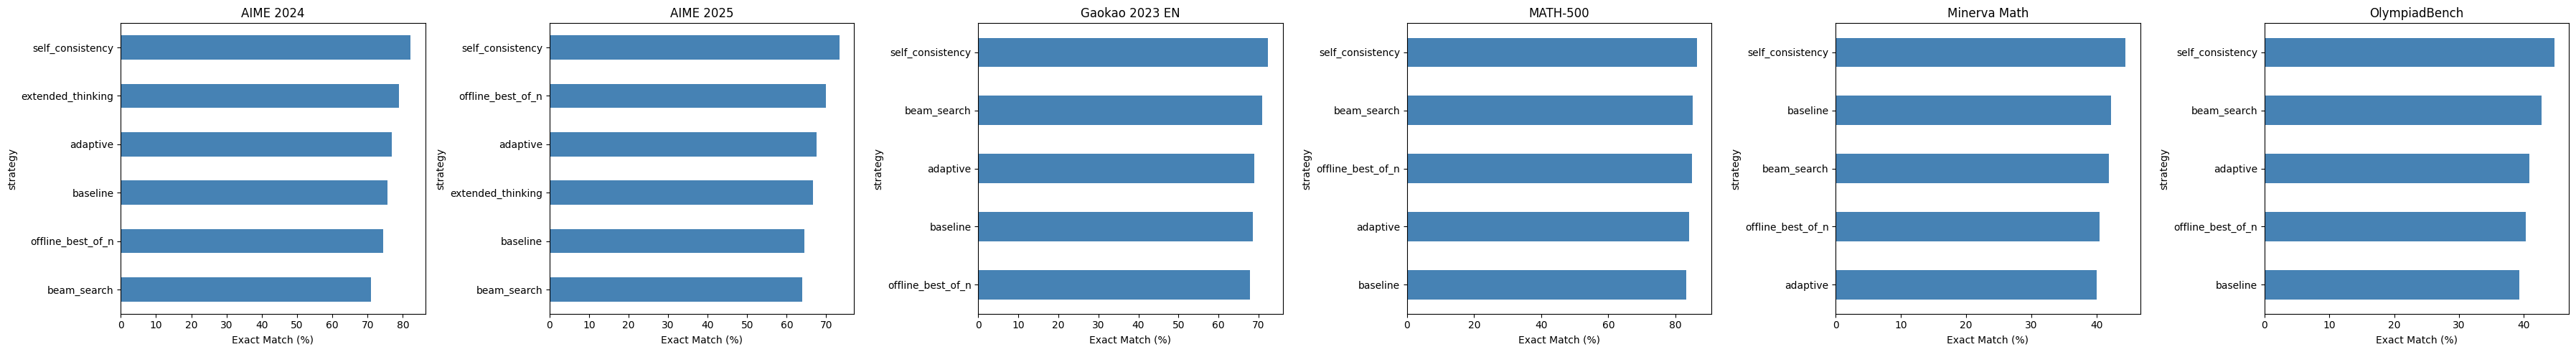

In [199]:
# ── Visualization ─────────────────────────────────────────────────────────────

# Bar chart: accuracy by strategy (per dataset)
plot_df = agg_df.dropna(subset=["exact_match_mean"]).copy()

if not plot_df.empty:
    fig, axes = plt.subplots(
        1, max(1, plot_df["project_label"].nunique()),
        figsize=(6 * max(1, plot_df["project_label"].nunique()), 5),
        squeeze=False,
    )
    for idx, dataset_label in enumerate(sorted(plot_df["project_label"].unique())):
        ax = axes[0, idx]
        sub = plot_df[plot_df["project_label"] == dataset_label]
        # Average across scorers/configs per strategy
        bars = sub.groupby("strategy")["exact_match_mean"].mean().sort_values()
        bars.plot.barh(ax=ax, color="steelblue")
        ax.set_xlabel("Exact Match (%)")
        ax.set_title(dataset_label)
    plt.tight_layout()
    plt.show()
else:
    print("No data for bar chart.")

In [200]:
# !pip install seaborn

In [201]:
# # Heatmap: beam search scorer x aggregation x window

# beam_df = agg_df[agg_df["strategy"] == "beam_search"].copy()

# if sns is None:
#     print("Install seaborn for heatmap visualization: pip install seaborn")
# elif not beam_df.empty:
#     heat_df = beam_df.dropna(subset=["exact_match_mean"]).copy()
#     heat_df["config"] = heat_df["aggregation"].astype(str) + " / w=" + heat_df["scoring_window"].astype(str)

#     for dataset_label in sorted(heat_df["project_label"].dropna().unique()):
#         sub = heat_df[heat_df["project_label"] == dataset_label]
#         if sub.empty:
#             continue
#         pivot = sub.pivot_table(
#             index="config", columns="scorer",
#             values="exact_match_mean", aggfunc="first",
#         )
#         if pivot.empty:
#             continue

#         fig, ax = plt.subplots(figsize=(max(6, pivot.shape[1] * 2), max(4, pivot.shape[0] * 0.6)))
#         sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax)
#         ax.set_title(f"Beam Search Accuracy — {dataset_label}")
#         plt.tight_layout()
#         plt.show()
# else:
#     print("No beam search data for heatmap.")

## Offline BoN Multi-Scorer Analysis

Download `candidates.json` from multi-scorer offline BoN runs and re-analyze
with different scorers, aggregation methods, and scoring windows.

In [202]:
import sys
import json as _json
from pathlib import Path as _Path

# Add project root and scripts/ to path so we can import analyze_candidates
_project_root = _Path.cwd().parent if _Path.cwd().name == "notebooks" else _Path.cwd()
for _p in [str(_project_root), str(_project_root / "scripts")]:
    if _p not in sys.path:
        sys.path.insert(0, _p)

# Suppress ANTLR version mismatch spam (bare print() in Recognizer.checkVersion)
import antlr4

def _noop_check(*args, **kwargs):
    pass

antlr4.Recognizer.checkVersion = _noop_check

import analyze_candidates as _ac_mod
import importlib
importlib.reload(_ac_mod)

from analyze_candidates import (
    aggregate_scores,
    select_best_candidate,
    precompute_correctness,
    analyze,
    analyze_all_windows,
    _save_csv,
)

print("Imported analyze_candidates functions")

Imported analyze_candidates functions


In [203]:
# ── Offline BoN Registry ──────────────────────────────────────────────────────
# Maps run lists → (data_name, answer_format, display_label) for candidates.json analysis.

OFFLINE_BON_REGISTRY = [
    (MATH500_OFFLINE_BON_RUNS, "math500", "numeric", "MATH-500"),
    (MINERVA_OFFLINE_BON_RUNS, "minerva_math", "numeric", "Minerva Math"),
    (GAOKAO_OFFLINE_BON_RUNS, "gaokao2023en", "numeric", "Gaokao 2023 EN"),
    (OLYMPIAD_OFFLINE_BON_RUNS, "olympiadbench", "numeric", "OlympiadBench"),
    (AIME_24_OFFLINE_BON_RUNS, "aime2024", "numeric", "AIME 2024"),
    (AIME_25_OFFLINE_BON_RUNS, "aime2025", "numeric", "AIME 2025"),
    (HUMANEVAL_OFFLINE_BON_RUNS, "human_eval_plus", "code", "HumanEval-Plus"),
    # (GPQA_OFFLINE_BON_RUNS, "gpqa_diamond", "char", "GPQA Diamond"),
]

print(f"Registry: {len(OFFLINE_BON_REGISTRY)} dataset(s)")
for run_list, dname, fmt, label in OFFLINE_BON_REGISTRY:
    n_runs = sum(len(e.get("runs", [])) for e in run_list if e.get("group_url"))
    print(f"  {label}: {n_runs} run(s)")

Registry: 7 dataset(s)
  MATH-500: 3 run(s)
  Minerva Math: 2 run(s)
  Gaokao 2023 EN: 3 run(s)
  OlympiadBench: 3 run(s)
  AIME 2024: 3 run(s)
  AIME 2025: 3 run(s)
  HumanEval-Plus: 3 run(s)


In [204]:
# ── Download candidates.json from wandb ───────────────────────────────────────

import tempfile
import shutil

CANDIDATES_CACHE_DIR = _Path("cache/candidates")


def download_candidates(run_id: str, entity: str, project: str,
                        data_name: str, seed: int) -> _Path:
    """Download candidates.json for a run, with disk caching."""
    cache_path = CANDIDATES_CACHE_DIR / data_name / f"seed_{seed}" / run_id
    candidates_file = cache_path / "candidates.json"

    if candidates_file.exists():
        return candidates_file

    cache_path.mkdir(parents=True, exist_ok=True)
    run = api.run(f"{entity}/{project}/{run_id}")

    # Download to a temp dir then move (atomic-ish)
    with tempfile.TemporaryDirectory() as tmp:
        try:
            f = run.file("candidates.json")
            f.download(root=tmp, replace=True)
            src = _Path(tmp) / "candidates.json"
            shutil.move(str(src), str(candidates_file))
            print(f"  Downloaded → {candidates_file}")
        except Exception as e:
            print(f"  ERROR downloading candidates.json for {run_id}: {e}")
            return None

    return candidates_file


# Download all candidates.json files
candidates_store = {}   # (data_name, seed) -> list[dict]
run_meta = {}           # (data_name, seed) -> metadata dict

for run_list, data_name, answer_format, project_label in OFFLINE_BON_REGISTRY:
    print(f"\n{project_label} ({data_name})")
    for entry in run_list:
        if not entry.get("group_url") or not entry.get("runs"):
            continue
        for run_entry in entry["runs"]:
            seed = run_entry["seed"]
            run_url = run_entry.get("run_url", "")
            if not run_url:
                continue
            info = parse_run_url(run_url)
            cpath = download_candidates(
                info["run_id"], info["entity"], info["project"],
                data_name, seed,
            )
            if cpath and cpath.exists():
                with open(cpath) as fh:
                    data = _json.load(fh)
                candidates_store[(data_name, seed)] = data
                run_meta[(data_name, seed)] = {
                    "project_label": project_label,
                    "answer_format": answer_format,
                    "data_name": data_name,
                    "run_id": info["run_id"],
                }
                print(f"  seed={seed}  samples={len(data)}")

print(f"\nLoaded {len(candidates_store)} candidate file(s)")

# Enrich run_meta with wandb summary metrics (EM, LLM judge, HumanEval score)
_enriched = 0
for (data_name, seed), meta in run_meta.items():
    rid = meta["run_id"]
    match = raw_df[raw_df["run_id"] == rid]
    if match.empty:
        continue
    r = match.iloc[0]
    meta["wandb_exact_match"] = r.get("exact_match")
    meta["wandb_total_tflops"] = r.get("total_tflops")
    meta["wandb_llm_accuracy"] = r.get("llm_judge_accuracy")
    meta["wandb_humaneval_correct"] = r.get("humaneval_correct")
    meta["wandb_humaneval_incorrect"] = r.get("humaneval_incorrect")
    _hc, _hi = r.get("humaneval_correct"), r.get("humaneval_incorrect")
    if pd.notna(_hc) and pd.notna(_hi) and (_hc + _hi) > 0:
        meta["wandb_humaneval_score"] = _hc / (_hc + _hi)
    else:
        meta["wandb_humaneval_score"] = None
    _enriched += 1
print(f"Enriched {_enriched}/{len(run_meta)} run_meta entries with wandb metrics")


MATH-500 (math500)
  seed=42  samples=500
  seed=43  samples=500
  seed=44  samples=500

Minerva Math (minerva_math)
  seed=42  samples=272
  seed=43  samples=272

Gaokao 2023 EN (gaokao2023en)
  seed=42  samples=385
  seed=43  samples=385
  seed=44  samples=385

OlympiadBench (olympiadbench)
  seed=42  samples=675
  seed=43  samples=675
  seed=44  samples=675

AIME 2024 (aime2024)
  seed=42  samples=30
  seed=43  samples=30
  seed=44  samples=30

AIME 2025 (aime2025)
  seed=42  samples=30
  seed=43  samples=30
  seed=44  samples=30

HumanEval-Plus (human_eval_plus)
  seed=42  samples=164
  seed=43  samples=164
  seed=44  samples=164

Loaded 20 candidate file(s)
Enriched 20/20 run_meta entries with wandb metrics


In [205]:
# ── Multi-scorer analysis across all windows ──────────────────────────────────
# Computes accuracy for every (scorer × aggregation × window) combo per dataset/seed.
# Cached: skips analysis if scoring_analysis.csv already exists next to candidates.json.

import csv

bon_records = []

for (data_name, seed), candidates_data in tqdm(sorted(candidates_store.items()), desc="Analyzing"):
    meta = run_meta[(data_name, seed)]
    label = meta["project_label"]
    run_cache = CANDIDATES_CACHE_DIR / data_name / f"seed_{seed}" / meta["run_id"]
    csv_path = run_cache / "scoring_analysis.csv"

    if csv_path.exists():
        # Load cached results
        with open(csv_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                bon_records.append({
                    "dataset": label,
                    "data_name": data_name,
                    "seed": seed,
                    "scorer": row["scorer"],
                    "aggregation": row["aggregation"] or "—",
                    "window": row["window"] or "all",
                    "exact_match": float(row["exact_match"]) * 100,
                    "humaneval_score": meta.get("wandb_humaneval_score"),
                    "total_tflops": meta.get("wandb_total_tflops"),
                })
        print(f"{label} seed={seed}: loaded from {csv_path}")
        continue

    # Run analysis
    all_results, correctness, oracle_acc, max_steps = analyze_all_windows(
        candidates_data, data_name, meta["answer_format"],
    )
    print(f"{label} seed={seed}: {len(candidates_data)} samples, "
          f"max_steps={max_steps}, oracle={oracle_acc*100:.1f}%")

    # Save CSV next to candidates.json
    _save_csv(all_results, csv_path, oracle_acc=oracle_acc)

    for window_label, scorer_dict in all_results.items():
        wval = window_label.split("=", 1)[1]
        for scorer, agg_dict in scorer_dict.items():
            for agg_method, accuracy in agg_dict.items():
                bon_records.append({
                    "dataset": label,
                    "data_name": data_name,
                    "seed": seed,
                    "scorer": scorer,
                    "aggregation": agg_method,
                    "window": wval,
                    "exact_match": accuracy * 100,
                    "humaneval_score": meta.get("wandb_humaneval_score"),
                    "total_tflops": meta.get("wandb_total_tflops"),
                })
        bon_records.append({
            "dataset": label,
            "data_name": data_name,
            "seed": seed,
            "scorer": "oracle",
            "aggregation": "—",
            "window": wval,
            "exact_match": oracle_acc * 100,
            "humaneval_score": meta.get("wandb_humaneval_score"),
            "total_tflops": meta.get("wandb_total_tflops"),
        })

bon_analysis_df = pd.DataFrame(bon_records)
print(f"\nTotal records: {len(bon_analysis_df)}")
bon_analysis_df.sample(20)

Analyzing:  10%|█         | 2/20 [00:00<00:01, 12.26it/s]

AIME 2024 seed=42: loaded from cache/candidates/aime2024/seed_42/sx8686xk/scoring_analysis.csv
AIME 2024 seed=43: loaded from cache/candidates/aime2024/seed_43/yma1zbec/scoring_analysis.csv
AIME 2024 seed=44: loaded from cache/candidates/aime2024/seed_44/jrvn9z5v/scoring_analysis.csv
AIME 2025 seed=42: loaded from cache/candidates/aime2025/seed_42/1cwevp55/scoring_analysis.csv
AIME 2025 seed=43: loaded from cache/candidates/aime2025/seed_43/ahbar3j1/scoring_analysis.csv
AIME 2025 seed=44: loaded from cache/candidates/aime2025/seed_44/rj0hw4tp/scoring_analysis.csv
Gaokao 2023 EN seed=42: loaded from cache/candidates/gaokao2023en/seed_42/qijvr95c/scoring_analysis.csv
Gaokao 2023 EN seed=43: loaded from cache/candidates/gaokao2023en/seed_43/jboxbdly/scoring_analysis.csv
Gaokao 2023 EN seed=44: loaded from cache/candidates/gaokao2023en/seed_44/nh8fx6pk/scoring_analysis.csv
HumanEval-Plus seed=42: loaded from cache/candidates/human_eval_plus/seed_42/z6vgbfcb/scoring_analysis.csv


Analyzing: 100%|██████████| 20/20 [00:00<00:00, 82.05it/s]


HumanEval-Plus seed=43: loaded from cache/candidates/human_eval_plus/seed_43/gij2g92w/scoring_analysis.csv
HumanEval-Plus seed=44: loaded from cache/candidates/human_eval_plus/seed_44/hoitoy74/scoring_analysis.csv
MATH-500 seed=42: loaded from cache/candidates/math500/seed_42/c35z6knc/scoring_analysis.csv
MATH-500 seed=43: loaded from cache/candidates/math500/seed_43/d7jh7cbj/scoring_analysis.csv
MATH-500 seed=44: loaded from cache/candidates/math500/seed_44/cz45vmb2/scoring_analysis.csv
Minerva Math seed=42: loaded from cache/candidates/minerva_math/seed_42/7syo0ks4/scoring_analysis.csv
Minerva Math seed=43: loaded from cache/candidates/minerva_math/seed_43/y6udmktu/scoring_analysis.csv
OlympiadBench seed=42: loaded from cache/candidates/olympiadbench/seed_42/scg2r5g6/scoring_analysis.csv
OlympiadBench seed=43: loaded from cache/candidates/olympiadbench/seed_43/lrbsr0b6/scoring_analysis.csv
OlympiadBench seed=44: loaded from cache/candidates/olympiadbench/seed_44/gzpylxq2/scoring_anal

,dataset,data_name,seed,scorer,aggregation,window,exact_match,humaneval_score,total_tflops
92973,AIME 2024,aime2024,43,perplexity,product,4525,66.67,NaN,52731.456
116315,AIME 2024,aime2024,43,prm,max,6396,76.67,NaN,52731.456
107738,AIME 2024,aime2024,43,prm,min,4976,76.67,NaN,52731.456
169865,AIME 2025,aime2025,42,perplexity,mean,286,63.33,NaN,63033.920
210958,HumanEval-Plus,human_eval_plus,43,sequence_prob,mean,316,81.71,0.798780,73975.920
117616,AIME 2024,aime2024,43,prm,product,540,83.33,NaN,52731.456
179361,AIME 2025,aime2025,43,pd_gap,max,115,56.67,NaN,63422.944
30416,AIME 2024,aime2024,43,entropy,max,6381,70.00,NaN,52731.456
156101,AIME 2024,aime2024,44,pd_gap,min,54,73.33,NaN,52006.688
161369,AIME 2024,aime2024,44,prm,min,226,73.33,NaN,52006.688


In [328]:
# ── Recalculate PRM TFLOPs (missing from multi-scorer runs) ──────────────────
# Bug: strategy_offline_best_of_n.py merges PRM TFLOPs only from self.scorer
# (the primary scorer).  In multi-scorer mode the primary scorer is an
# uncertainty metric, and PRM runs via self.prm_scorer — whose TFLOPs are
# never merged into the reported total_tflops.
#
# Fix: reconstruct PRM prompts from candidates.json, count tokens with the
# actual PRM tokenizer, and add the PRM TFLOPs to the PRM scorer rows.

from transformers import AutoTokenizer

_PRM_MODEL_NAME   = "Qwen/Qwen2.5-Math-PRM-7B"
_PRM_MODEL_PARAMS = 7e9          # 7 B parameters
_PRM_MAX_TOKENS   = 4000         # config/scorer/prm.yaml
_PRM_MODEL_MAX_LEN = 4096        # max_position_embeddings

print(f"Loading PRM tokenizer ({_PRM_MODEL_NAME}) ...")
_prm_tok = AutoTokenizer.from_pretrained(
    _PRM_MODEL_NAME, trust_remote_code=True,
)
print("  done.\n")


# ── helpers (mirror step_scorer_prm.py) ──────────────────────────────────────

def _fmt_prm_prompt(question: str, step_texts: list, tokenizer) -> str:
    """Replicate StepScorerPRM._format_prm_prompt."""
    messages = [
        {"role": "system",
         "content": "Please reason step by step, and put your final answer within \\boxed{}."},
        {"role": "user", "content": question},
        {"role": "assistant",
         "content": "<extra_0>".join(step_texts) + "<extra_0>"},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False,
    )


def _count_prm_tokens(question: str, step_texts: list, tokenizer,
                      max_tokens: int = _PRM_MAX_TOKENS) -> int:
    """Count PRM input tokens with tail truncation.

    Replicates _truncate_steps_from_tail from step_scorer_prm.py line 824.
    """
    if not step_texts:
        return 0

    # Frame overhead (system + user + assistant wrapper, no steps)
    frame_prompt = _fmt_prm_prompt(question, [], tokenizer)
    frame_tokens = len(tokenizer.encode(frame_prompt)) - 1   # trailing <extra_0>

    # Per-step token costs (+1 for <extra_0> separator)
    step_costs = [len(tokenizer.encode(s)) + 1 for s in step_texts]
    budget = max_tokens - frame_tokens - 10                    # safety margin

    # Walk backward from last step, include as many as fit
    total_cost = 0
    first_included_idx = len(step_texts)
    for i in range(len(step_texts) - 1, -1, -1):
        if total_cost + step_costs[i] <= budget:
            total_cost += step_costs[i]
            first_included_idx = i
        else:
            break

    # Edge case: force-include last step even if it exceeds budget
    if first_included_idx == len(step_texts) and step_texts:
        first_included_idx = len(step_texts) - 1

    included_steps = step_texts[first_included_idx:]
    prompt = _fmt_prm_prompt(question, included_steps, tokenizer)
    n_tokens = len(tokenizer.encode(prompt))

    # Hard truncate at model max_position_embeddings
    return min(n_tokens, _PRM_MODEL_MAX_LEN)


# ── compute per-(dataset, seed) PRM TFLOPs ──────────────────────────────────

prm_tflops_by_run = {}   # (data_name, seed) -> float

for (data_name, seed), cands in tqdm(
    sorted(candidates_store.items()), desc="Computing PRM TFLOPs",
):
    total_prm_tokens = 0
    n_scored = 0
    for sample in cands:
        question = sample["question"]
        for cand in sample["candidates"]:
            if "prm" not in cand.get("scores", {}):
                continue
            total_prm_tokens += _count_prm_tokens(
                question, cand["steps"], _prm_tok,
            )
            n_scored += 1

    prm_tflops = 2 * _PRM_MODEL_PARAMS * total_prm_tokens / 1e12
    prm_tflops_by_run[(data_name, seed)] = prm_tflops
    print(
        f"  {data_name:20s} seed={seed}: {n_scored:5d} candidates, "
        f"PRM tokens={total_prm_tokens:>10,}, PRM TFLOPs={prm_tflops:>10,.1f}"
    )


# ── patch bon_analysis_df: add PRM TFLOPs to PRM scorer rows ────────────────

_patched = 0
for idx, row in bon_analysis_df.iterrows():
    if row["scorer"] != "prm":
        continue
    key = (row["data_name"], row["seed"])
    if key not in prm_tflops_by_run:
        continue
    old_tf = row["total_tflops"]
    if pd.notna(old_tf):
        bon_analysis_df.at[idx, "total_tflops"] = old_tf + prm_tflops_by_run[key]
        _patched += 1

print(f"\nPatched {_patched} PRM rows in bon_analysis_df")

# Show before/after comparison
print(f"\n{'Dataset':>20s}  {'Seed':>4s}  {'Gen TFLOPs':>12s}  {'PRM TFLOPs':>12s}  {'Total':>12s}  {'PRM %':>6s}")
print("─" * 75)
for key in sorted(prm_tflops_by_run.keys()):
    meta = run_meta.get(key)
    gen_tf = meta.get("wandb_total_tflops", 0) if meta else 0
    prm_tf = prm_tflops_by_run[key]
    total = gen_tf + prm_tf
    pct = prm_tf / total * 100 if total > 0 else 0
    print(
        f"{key[0]:>20s}  {key[1]:>4d}  {gen_tf:>12,.1f}  {prm_tf:>12,.1f}  "
        f"{total:>12,.1f}  {pct:>5.1f}%"
    )


Loading PRM tokenizer (Qwen/Qwen2.5-Math-PRM-7B) ...
  done.



Computing PRM TFLOPs:   5%|▌         | 1/20 [00:04<01:25,  4.49s/it]

  aime2024             seed=42:   240 candidates, PRM tokens=   922,926, PRM TFLOPs=  12,921.0


Computing PRM TFLOPs:  10%|█         | 2/20 [00:08<01:18,  4.35s/it]

  aime2024             seed=43:   240 candidates, PRM tokens=   928,059, PRM TFLOPs=  12,992.8


Computing PRM TFLOPs:  15%|█▌        | 3/20 [00:12<01:12,  4.27s/it]

  aime2024             seed=44:   240 candidates, PRM tokens=   922,618, PRM TFLOPs=  12,916.7


Computing PRM TFLOPs:  20%|██        | 4/20 [00:17<01:11,  4.46s/it]

  aime2025             seed=42:   240 candidates, PRM tokens=   918,054, PRM TFLOPs=  12,852.8


Computing PRM TFLOPs:  25%|██▌       | 5/20 [00:22<01:08,  4.58s/it]

  aime2025             seed=43:   240 candidates, PRM tokens=   929,225, PRM TFLOPs=  13,009.1


Computing PRM TFLOPs:  30%|███       | 6/20 [00:27<01:05,  4.66s/it]

  aime2025             seed=44:   240 candidates, PRM tokens=   924,809, PRM TFLOPs=  12,947.3


Computing PRM TFLOPs:  35%|███▌      | 7/20 [00:32<01:03,  4.86s/it]

  gaokao2023en         seed=42:  3080 candidates, PRM tokens= 2,548,264, PRM TFLOPs=  35,675.7


Computing PRM TFLOPs:  40%|████      | 8/20 [00:37<00:59,  4.95s/it]

  gaokao2023en         seed=43:  3080 candidates, PRM tokens= 2,505,320, PRM TFLOPs=  35,074.5


Computing PRM TFLOPs:  45%|████▌     | 9/20 [00:42<00:55,  5.05s/it]

  gaokao2023en         seed=44:  3080 candidates, PRM tokens= 2,524,362, PRM TFLOPs=  35,341.1


Computing PRM TFLOPs:  50%|█████     | 10/20 [00:52<01:03,  6.34s/it]

  human_eval_plus      seed=42:  1312 candidates, PRM tokens= 3,379,272, PRM TFLOPs=  47,309.8


Computing PRM TFLOPs:  55%|█████▌    | 11/20 [01:01<01:06,  7.38s/it]

  human_eval_plus      seed=43:  1312 candidates, PRM tokens= 3,380,876, PRM TFLOPs=  47,332.3


Computing PRM TFLOPs:  60%|██████    | 12/20 [01:11<01:04,  8.01s/it]

  human_eval_plus      seed=44:  1312 candidates, PRM tokens= 3,395,357, PRM TFLOPs=  47,535.0


Computing PRM TFLOPs:  65%|██████▌   | 13/20 [01:17<00:51,  7.37s/it]

  math500              seed=42:  4000 candidates, PRM tokens= 3,018,207, PRM TFLOPs=  42,254.9


Computing PRM TFLOPs:  70%|███████   | 14/20 [01:23<00:41,  6.95s/it]

  math500              seed=43:  4000 candidates, PRM tokens= 3,055,256, PRM TFLOPs=  42,773.6


Computing PRM TFLOPs:  75%|███████▌  | 15/20 [01:29<00:33,  6.69s/it]

  math500              seed=44:  4000 candidates, PRM tokens= 3,068,526, PRM TFLOPs=  42,959.4


Computing PRM TFLOPs:  80%|████████  | 16/20 [01:33<00:23,  5.95s/it]

  minerva_math         seed=42:  2176 candidates, PRM tokens= 1,987,331, PRM TFLOPs=  27,822.6


Computing PRM TFLOPs:  85%|████████▌ | 17/20 [01:37<00:16,  5.39s/it]

  minerva_math         seed=43:  2176 candidates, PRM tokens= 1,930,876, PRM TFLOPs=  27,032.3


Computing PRM TFLOPs:  90%|█████████ | 18/20 [01:50<00:15,  7.51s/it]

  olympiadbench        seed=42:  5400 candidates, PRM tokens= 6,123,739, PRM TFLOPs=  85,732.3


Computing PRM TFLOPs:  95%|█████████▌| 19/20 [02:06<00:10, 10.03s/it]

  olympiadbench        seed=43:  5400 candidates, PRM tokens= 6,198,311, PRM TFLOPs=  86,776.4


Computing PRM TFLOPs: 100%|██████████| 20/20 [02:20<00:00,  7.02s/it]

  olympiadbench        seed=44:  5400 candidates, PRM tokens= 6,265,409, PRM TFLOPs=  87,715.7



Patched 44696 PRM rows in bon_analysis_df

             Dataset  Seed    Gen TFLOPs    PRM TFLOPs         Total   PRM %
───────────────────────────────────────────────────────────────────────────
            aime2024    42      52,628.8      12,921.0      65,549.8   19.7%
            aime2024    43      52,731.5      12,992.8      65,724.3   19.8%
            aime2024    44      52,006.7      12,916.7      64,923.3   19.9%
            aime2025    42      63,033.9      12,852.8      75,886.7   16.9%
            aime2025    43      63,422.9      13,009.1      76,432.1   17.0%
            aime2025    44      63,592.3      12,947.3      76,539.6   16.9%
        gaokao2023en    42      32,078.5      35,675.7      67,754.2   52.7%
        gaokao2023en    43      31,446.8      35,074.5      66,521.3   52.7%
        gaokao2023en    44      31,759.5      35,341.1      67,100.5   52.7%
     human_eval_plus    42      72,456.8      47,309.8     119,766.6   39.5%
     human_eval_plus    43      7

In [329]:
# ── Aggregate offline BoN results across seeds ────────────────────────────────

bon_agg_df = (
    bon_analysis_df
    .groupby(["dataset", "scorer", "aggregation", "window"])
    .agg(
        exact_match_mean=("exact_match", "mean"),
        exact_match_std=("exact_match", "std"),
        exact_match_count=("exact_match", "count"),
        humaneval_score_mean=("humaneval_score", "mean"),
        total_tflops_mean=("total_tflops", "mean"),
        total_tflops_std=("total_tflops", "std"),
        total_tflops_count=("total_tflops", "count"),
    )
    .reset_index()
)

bon_agg_df["exact_match_fmt"] = bon_agg_df.apply(
    lambda r: (
        f"{r['exact_match_mean']:.1f} ± {r['exact_match_std']:.1f}"
        if pd.notna(r["exact_match_std"]) and r["exact_match_count"] > 1
        else f"{r['exact_match_mean']:.1f}"
    ),
    axis=1,
)

bon_agg_df["humaneval_score_fmt"] = bon_agg_df.apply(
    lambda r: f"{r['humaneval_score_mean']*100:.1f}" if pd.notna(r["humaneval_score_mean"]) else "",
    axis=1,
)

bon_agg_df["total_tflops_fmt"] = bon_agg_df.apply(
    lambda r: (
        f"{r['total_tflops_mean']:.1f} ± {r['total_tflops_std']:.1f}"
        if pd.notna(r["total_tflops_std"]) and r["total_tflops_count"] > 1
        else (f"{r['total_tflops_mean']:.1f}" if pd.notna(r["total_tflops_mean"]) else "")
    ),
    axis=1,
)

bon_agg_df["strategy"] = "offline_best_of_n"

print(f"Aggregated: {len(bon_agg_df)} rows")
print(f"Datasets:   {sorted(bon_agg_df['dataset'].unique())}")
print(f"Scorers:    {sorted(bon_agg_df['scorer'].unique())}")
print(f"Windows:    {sorted(bon_agg_df['window'].unique(), key=lambda w: (0, int(w)) if w != 'all' else (1, 0))}")

# Sanity check: show window=all, aggregation=mean — with baseline/self-consistency for reference
# Uses same (Strategy, Scorer) MultiIndex format with (Dataset, Metric) columns

_bon_sub = bon_agg_df[
    (bon_agg_df["window"] == "all") & (bon_agg_df["aggregation"].isin(["mean", "\u2014"]))
].copy()

_SCORER_ORDER = ["oracle", "prm", "entropy", "perplexity", "sequence_prob", "pd_gap"]

_SANITY_GROUPS = {
    "Qwen2.5-Math-7B-Instruct": ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
    "Qwen3-8B": ["AIME 2024", "AIME 2025", "HumanEval-Plus"],
}

# Per-dataset metric definitions: (metric_label, agg_df_col, bon_em_col, bon_ref_col)
_DS_METRICS = {
    "HumanEval-Plus": [
        ("Score (%)", "humaneval_score_fmt", "exact_match_fmt", None),
        ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
    ],
}
_DEFAULT_METRICS = [
    ("EM (%)", "exact_match_fmt", "exact_match_fmt", None),
    ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
]

def _get_ds_metrics(ds):
    return _DS_METRICS.get(ds, _DEFAULT_METRICS)

for _name, _datasets in _SANITY_GROUPS.items():
    rows = []
    row_index = []

    col_tuples = []
    for ds in _datasets:
        for ml, *_ in _get_ds_metrics(ds):
            col_tuples.append((ds, ml))

    # Baseline row
    _bl = agg_df[agg_df["strategy"] == "baseline"]
    _bl_row = {}
    for ds in _datasets:
        m = _bl[_bl["project_label"] == ds]
        for ml, agg_col, _, _ in _get_ds_metrics(ds):
            _bl_row[(ds, ml)] = m.iloc[0].get(agg_col, "") if not m.empty else ""
    rows.append(_bl_row)
    row_index.append(("Baseline", "\u2014"))

    # Self-consistency row
    _sc = agg_df[agg_df["strategy"] == "self_consistency"]
    _sc_row = {}
    for ds in _datasets:
        m = _sc[_sc["project_label"] == ds]
        for ml, agg_col, _, _ in _get_ds_metrics(ds):
            _sc_row[(ds, ml)] = m.iloc[0].get(agg_col, "") if not m.empty else ""
    rows.append(_sc_row)
    row_index.append(("Self-Consistency", "\u2014"))

    # Offline BoN per-scorer rows
    for scorer in _SCORER_ORDER:
        _sr = _bon_sub[_bon_sub["scorer"] == scorer]
        row = {}
        for ds in _datasets:
            m = _sr[_sr["dataset"] == ds]
            for ml, _, bon_col, bon_ref_col in _get_ds_metrics(ds):
                if not m.empty:
                    row[(ds, ml)] = m.iloc[0].get(bon_ref_col or bon_col, "")
                else:
                    row[(ds, ml)] = ""
        rows.append(row)
        row_index.append(("Offline BoN", scorer))

    mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])
    mi_cols = pd.MultiIndex.from_tuples(col_tuples, names=["Dataset", "Metric"])
    tbl = pd.DataFrame(rows, index=mi_rows, columns=mi_cols)
    print(f"\n{_name} (window=all, aggregation=mean)")
    display(style_results_table(tbl))

Aggregated: 165047 rows
Datasets:   ['AIME 2024', 'AIME 2025', 'Gaokao 2023 EN', 'HumanEval-Plus', 'MATH-500', 'Minerva Math', 'OlympiadBench']
Scorers:    ['entropy', 'oracle', 'pd_gap', 'perplexity', 'prm', 'sequence_prob']
Windows:    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '


Qwen3-8B (window=all, aggregation=mean)


In [330]:
# ── Best scoring window per (scorer, aggregation) — averaged across datasets & seeds ──
# For each model group, find the window that maximizes accuracy per (scorer, aggregation).
# Window is chosen by averaging the core metric across datasets.

# Core metric per dataset (used for averaging when selecting best window/aggregation)
CORE_METRIC = {
    "MATH-500": "exact_match_fmt",
    "OlympiadBench": "exact_match_fmt",
    "Minerva Math": "exact_match_fmt",
    "Gaokao 2023 EN": "exact_match_fmt",
    "AIME 2024": "exact_match_fmt",
    "AIME 2025": "exact_match_fmt",
    "HumanEval-Plus": "humaneval_score_fmt",
}

CORE_METRIC_LABEL = {
    "MATH-500": "EM (%)",
    "OlympiadBench": "EM (%)",
    "Minerva Math": "EM (%)",
    "Gaokao 2023 EN": "EM (%)",
    "AIME 2024": "EM (%)",
    "AIME 2025": "EM (%)",
    "HumanEval-Plus": "Score (%)",
}

MODEL_GROUPS = {
    "Qwen2.5-Math-7B-Instruct": ["MATH-500", "OlympiadBench", "Gaokao 2023 EN"],  # Minerva Math excluded (anomalous results)
    "Qwen3-8B": ["AIME 2024", "AIME 2025", "HumanEval-Plus"],
}

AGGREGATIONS = ["mean", "min", "max", "product"]
CANDIDATE_WINDOWS = ["all", "1", "2", "3", "5", "10", "15", "20", "25", "50"]

best_windows = {}  # (model_group, scorer, aggregation) -> {window, accuracy}

for model_name, datasets in MODEL_GROUPS.items():

    # Filter bon_agg_df to this model's datasets, exclude oracle
    mask = (
        bon_agg_df["dataset"].isin(datasets)
        & (bon_agg_df["scorer"] != "oracle")
    )
    sub = bon_agg_df[mask].copy()

    if sub.empty:
        continue

    # Only consider windows that exist for ALL datasets in the group
    _window_sets = []
    for ds in datasets:
        ds_windows = set(sub[sub["dataset"] == ds]["window"].unique())
        if ds_windows:
            _window_sets.append(ds_windows)
    common_windows = set.intersection(*_window_sets) if _window_sets else set()
    common_windows = common_windows & set(CANDIDATE_WINDOWS)
    sub = sub[sub["window"].isin(common_windows)].copy()

    # For each (scorer, aggregation, window): average accuracy_mean across datasets
    # Note: bon_agg_df accuracy is always EM-based (from candidates.json re-analysis)
    window_perf = (
        sub.groupby(["scorer", "aggregation", "window"])["exact_match_mean"]
        .mean()
        .reset_index()
        .rename(columns={"exact_match_mean": "avg_accuracy"})
    )

    # For each (scorer, aggregation): find the best window
    for scorer in sorted(sub["scorer"].unique()):
        for agg in AGGREGATIONS:
            sa_df = window_perf[
                (window_perf["scorer"] == scorer) & (window_perf["aggregation"] == agg)
            ]
            if sa_df.empty:
                continue
            best = sa_df.loc[sa_df["avg_accuracy"].idxmax()]
            best_windows[(model_name, scorer, agg)] = {
                "window": best["window"],
                "accuracy": best["avg_accuracy"],
            }


# ── Display tables: one per (model_group, aggregation) ───────────────────────
_SCORER_ORDER = ["entropy", "perplexity", "sequence_prob", "pd_gap", "prm"]

# Per-dataset metric definitions
_DS_METRICS = {
    "HumanEval-Plus": [
        ("Score (%)", "humaneval_score_fmt", "exact_match_fmt", None),
        ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
    ],
}
_DEFAULT_METRICS = [
    ("EM (%)", "exact_match_fmt", "exact_match_fmt", None),
    ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
]

def _get_ds_metrics(ds):
    return _DS_METRICS.get(ds, _DEFAULT_METRICS)

for model_name, datasets in MODEL_GROUPS.items():
    for agg in AGGREGATIONS:
        rows = []
        row_index = []

        col_tuples = []
        for ds in datasets:
            for ml, *_ in _get_ds_metrics(ds):
                col_tuples.append((ds, ml))

        # Baseline row
        _bl_row = {}
        for ds in datasets:
            _bl = agg_df[(agg_df["strategy"] == "baseline") & (agg_df["project_label"] == ds)]
            for ml, agg_col, _, _ in _get_ds_metrics(ds):
                _bl_row[(ds, ml)] = _bl.iloc[0].get(agg_col, "") if not _bl.empty else ""
        rows.append(_bl_row)
        row_index.append(("Baseline", "\u2014"))

        # Self-consistency row
        _sc_row = {}
        for ds in datasets:
            _sc = agg_df[(agg_df["strategy"] == "self_consistency") & (agg_df["project_label"] == ds)]
            for ml, agg_col, _, _ in _get_ds_metrics(ds):
                _sc_row[(ds, ml)] = _sc.iloc[0].get(agg_col, "") if not _sc.empty else ""
        rows.append(_sc_row)
        row_index.append(("Self-Consistency", "\u2014"))

        # Oracle row
        _orc_row = {}
        for ds in datasets:
            _orc = bon_agg_df[
                (bon_agg_df["dataset"] == ds)
                & (bon_agg_df["scorer"] == "oracle")
                & (bon_agg_df["window"] == "all")
            ]
            for ml, _, bon_col, bon_ref_col in _get_ds_metrics(ds):
                if not _orc.empty:
                    _orc_row[(ds, ml)] = _orc.iloc[0].get(bon_ref_col or bon_col, "")
                else:
                    _orc_row[(ds, ml)] = ""
        rows.append(_orc_row)
        row_index.append(("Oracle", "\u2014"))

        # Offline BoN per-scorer rows (best window per scorer)
        for scorer in _SCORER_ORDER:
            bw = best_windows.get((model_name, scorer, agg))
            if bw is None:
                continue
            w = bw["window"]
            row = {}
            for ds in datasets:
                match = bon_agg_df[
                    (bon_agg_df["dataset"] == ds)
                    & (bon_agg_df["scorer"] == scorer)
                    & (bon_agg_df["aggregation"] == agg)
                    & (bon_agg_df["window"] == w)
                ]
                for ml, _, bon_col, bon_ref_col in _get_ds_metrics(ds):
                    if not match.empty:
                        row[(ds, ml)] = match.iloc[0].get(bon_ref_col or bon_col, "")
                    else:
                        row[(ds, ml)] = ""
            rows.append(row)
            row_index.append((f"Offline BoN\n(best window, {agg})", f"{scorer} (w={w})"))

        if not rows:
            continue

        mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])
        mi_cols = pd.MultiIndex.from_tuples(col_tuples, names=["Dataset", "Metric"])
        tbl = pd.DataFrame(rows, index=mi_rows, columns=mi_cols)

        print(f"\n{model_name} — aggregation={agg}")
        print(f"  Best window selected per scorer by averaging EM across: {', '.join(datasets)}")
        if model_name == "Qwen2.5-Math-7B-Instruct":
            print(f"  Note: Minerva Math excluded from averaging (anomalous results)")
        print(f"  Core metric per dataset: {', '.join(f'{ds}={CORE_METRIC_LABEL[ds]}' for ds in datasets)}")
        display(style_results_table(tbl))


Qwen2.5-Math-7B-Instruct — aggregation=mean
  Best window selected per scorer by averaging EM across: MATH-500, OlympiadBench, Gaokao 2023 EN
  Note: Minerva Math excluded from averaging (anomalous results)
  Core metric per dataset: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)



Qwen2.5-Math-7B-Instruct — aggregation=min
  Best window selected per scorer by averaging EM across: MATH-500, OlympiadBench, Gaokao 2023 EN
  Note: Minerva Math excluded from averaging (anomalous results)
  Core metric per dataset: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)



Qwen2.5-Math-7B-Instruct — aggregation=max
  Best window selected per scorer by averaging EM across: MATH-500, OlympiadBench, Gaokao 2023 EN
  Note: Minerva Math excluded from averaging (anomalous results)
  Core metric per dataset: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)



Qwen2.5-Math-7B-Instruct — aggregation=product
  Best window selected per scorer by averaging EM across: MATH-500, OlympiadBench, Gaokao 2023 EN
  Note: Minerva Math excluded from averaging (anomalous results)
  Core metric per dataset: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)



Qwen3-8B — aggregation=mean
  Best window selected per scorer by averaging EM across: AIME 2024, AIME 2025, HumanEval-Plus
  Core metric per dataset: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)



Qwen3-8B — aggregation=min
  Best window selected per scorer by averaging EM across: AIME 2024, AIME 2025, HumanEval-Plus
  Core metric per dataset: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)



Qwen3-8B — aggregation=max
  Best window selected per scorer by averaging EM across: AIME 2024, AIME 2025, HumanEval-Plus
  Core metric per dataset: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)



Qwen3-8B — aggregation=product
  Best window selected per scorer by averaging EM across: AIME 2024, AIME 2025, HumanEval-Plus
  Core metric per dataset: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)


In [331]:
# ── Best aggregation per scorer — using core metric ──────────────────────────
# For each (model_group, scorer), find the aggregation that maximizes the core metric.
# Uses the best window already selected in the previous cell.

best_aggregations = {}  # (model_group, scorer) -> {aggregation, window, accuracy}

for model_name, datasets in MODEL_GROUPS.items():
    print(f"\n{model_name}")
    print(f"  Core metrics: {', '.join(f'{ds}={CORE_METRIC_LABEL[ds]}' for ds in datasets)}")

    for scorer in sorted(set(sc for (mg, sc, _) in best_windows if mg == model_name)):
        best_acc = -1
        best_agg = None
        best_win = None

        for agg in AGGREGATIONS:
            bw = best_windows.get((model_name, scorer, agg))
            if bw is None:
                continue
            # Use the best window for this (scorer, agg), compute core-metric average
            w = bw["window"]
            core_vals = []
            for ds in datasets:
                match = bon_agg_df[
                    (bon_agg_df["dataset"] == ds)
                    & (bon_agg_df["scorer"] == scorer)
                    & (bon_agg_df["aggregation"] == agg)
                    & (bon_agg_df["window"] == w)
                ]
                if not match.empty:
                    core_vals.append(match.iloc[0]["exact_match_mean"])
            if core_vals:
                avg = sum(core_vals) / len(core_vals)
                if avg > best_acc:
                    best_acc = avg
                    best_agg = agg
                    best_win = w

        if best_agg:
            best_aggregations[(model_name, scorer)] = {
                "aggregation": best_agg,
                "window": best_win,
                "accuracy": best_acc,
            }
            print(f"  {scorer:<16s}  best: {best_agg} (w={best_win}, avg={best_acc:.1f}%)")

# ── Display: best (aggregation, window) per scorer ───────────────────────────
_SCORER_ORDER = ["entropy", "perplexity", "sequence_prob", "pd_gap", "prm"]

_DS_METRICS = {
    "HumanEval-Plus": [
        ("Score (%)", "humaneval_score_fmt", "exact_match_fmt", None),
        ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
    ],
}
_DEFAULT_METRICS = [
    ("EM (%)", "exact_match_fmt", "exact_match_fmt", None),
    ("TFLOPs", "total_tflops_fmt", "total_tflops_fmt", None),
]

def _get_ds_metrics(ds):
    return _DS_METRICS.get(ds, _DEFAULT_METRICS)

for model_name, datasets in MODEL_GROUPS.items():
    rows = []
    row_index = []

    col_tuples = []
    for ds in datasets:
        for ml, *_ in _get_ds_metrics(ds):
            col_tuples.append((ds, ml))

    # Baseline
    _bl_row = {}
    for ds in datasets:
        _bl = agg_df[(agg_df["strategy"] == "baseline") & (agg_df["project_label"] == ds)]
        for ml, agg_col, _, _ in _get_ds_metrics(ds):
            _bl_row[(ds, ml)] = _bl.iloc[0].get(agg_col, "") if not _bl.empty else ""
    rows.append(_bl_row)
    row_index.append(("Baseline", "\u2014"))

    # Self-consistency
    _sc_row = {}
    for ds in datasets:
        _sc = agg_df[(agg_df["strategy"] == "self_consistency") & (agg_df["project_label"] == ds)]
        for ml, agg_col, _, _ in _get_ds_metrics(ds):
            _sc_row[(ds, ml)] = _sc.iloc[0].get(agg_col, "") if not _sc.empty else ""
    rows.append(_sc_row)
    row_index.append(("Self-Consistency", "\u2014"))

    # Oracle
    _orc_row = {}
    for ds in datasets:
        _orc = bon_agg_df[
            (bon_agg_df["dataset"] == ds)
            & (bon_agg_df["scorer"] == "oracle")
            & (bon_agg_df["window"] == "all")
        ]
        for ml, _, bon_col, bon_ref_col in _get_ds_metrics(ds):
            if not _orc.empty:
                _orc_row[(ds, ml)] = _orc.iloc[0].get(bon_ref_col or bon_col, "")
            else:
                _orc_row[(ds, ml)] = ""
    rows.append(_orc_row)
    row_index.append(("Oracle", "\u2014"))

    # Offline BoN per-scorer with best (aggregation, window)
    for scorer in _SCORER_ORDER:
        ba = best_aggregations.get((model_name, scorer))
        if ba is None:
            continue
        agg, w = ba["aggregation"], ba["window"]
        row = {}
        for ds in datasets:
            match = bon_agg_df[
                (bon_agg_df["dataset"] == ds)
                & (bon_agg_df["scorer"] == scorer)
                & (bon_agg_df["aggregation"] == agg)
                & (bon_agg_df["window"] == w)
            ]
            for ml, _, bon_col, bon_ref_col in _get_ds_metrics(ds):
                if not match.empty:
                    row[(ds, ml)] = match.iloc[0].get(bon_ref_col or bon_col, "")
                else:
                    row[(ds, ml)] = ""
        rows.append(row)
        row_index.append(("Offline BoN\n(best agg+window)", f"{scorer} ({agg}, w={w})"))

    mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])
    mi_cols = pd.MultiIndex.from_tuples(col_tuples, names=["Dataset", "Metric"])
    tbl = pd.DataFrame(rows, index=mi_rows, columns=mi_cols)

    print(f"\n{model_name} — best aggregation & window per scorer")
    print(f"  Core metric per dataset: {', '.join(f'{ds}={CORE_METRIC_LABEL[ds]}' for ds in datasets)}")
    display(style_results_table(tbl))


Qwen2.5-Math-7B-Instruct
  Core metrics: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)
  entropy           best: product (w=5, avg=65.6%)
  pd_gap            best: mean (w=5, avg=66.8%)
  perplexity        best: mean (w=5, avg=67.1%)
  prm               best: product (w=all, avg=69.2%)
  sequence_prob     best: product (w=5, avg=66.0%)

Qwen3-8B
  Core metrics: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)
  entropy           best: max (w=all, avg=75.0%)
  pd_gap            best: max (w=all, avg=75.0%)
  perplexity        best: max (w=all, avg=74.0%)
  prm               best: min (w=15, avg=78.8%)
  sequence_prob     best: mean (w=1, avg=76.8%)

Qwen2.5-Math-7B-Instruct — best aggregation & window per scorer
  Core metric per dataset: MATH-500=EM (%), OlympiadBench=EM (%), Gaokao 2023 EN=EM (%)



Qwen3-8B — best aggregation & window per scorer
  Core metric per dataset: AIME 2024=EM (%), AIME 2025=EM (%), HumanEval-Plus=Score (%)


## Combined Results

Combined tables showing baseline, self-consistency, offline BoN (per-scorer from
`candidates.json` analysis), and MUR (from wandb summary) for each model.

In [332]:
# ── Model results table builder ───────────────────────────────────────────────

SCORER_ORDER = ["prm", "entropy", "perplexity", "sequence_prob", "pd_gap"]

STRATEGY_DISPLAY = {
    "baseline": "Baseline",
    "extended_thinking": "Extended Thinking",
    "self_consistency": "Self-Consistency",
    "offline_bon": "Offline BoN",
    "beam_search": "Beam Search",
    "adaptive": "MUR",
}

# Strategies that have a single row (no per-scorer breakdown)
SINGLE_SCORER_STRATEGIES = {"baseline", "self_consistency", "extended_thinking"}


def _fmt_metric(val, std=None, count=None):
    """Format a metric value, optionally with ± std."""
    if pd.isna(val):
        return ""
    if std is not None and pd.notna(std) and count is not None and count > 1:
        return f"{val:.1f} ± {std:.1f}"
    return f"{val:.1f}"


def _get_wandb_metrics(model_df, strategy, scorer, dataset, humaneval_datasets=None):
    """Extract (EM, TFLOPs) from wandb agg_df for one (strategy, scorer, dataset)."""
    mask = model_df["strategy"] == strategy
    mask &= model_df["project_label"] == dataset
    if scorer is not None:
        mask &= model_df["scorer"] == scorer
    sub = model_df[mask]
    if sub.empty:
        return "", ""
    r = sub.iloc[0]
    # Use humaneval_score_fmt for HumanEval datasets
    if humaneval_datasets and dataset in humaneval_datasets:
        em = r.get("humaneval_score_fmt", "")
    else:
        em = r.get("exact_match_fmt", _fmt_metric(r.get("exact_match_mean")))
    tf = _fmt_metric(r.get("total_tflops_mean"),
                     r.get("total_tflops_std"),
                     r.get("total_tflops_count"))
    return em, tf


def build_model_results_table(
    agg_df,
    bon_agg_df,
    best_aggregations,
    model_name,
    model_filter,
    datasets,
    strategy_order=None,
    humaneval_datasets=None,
    beam_search_filter=None,
):
    """Build a combined results table for one model.

    Parameters
    ----------
    best_aggregations : dict
        {(model_group, scorer): {"aggregation", "window", "accuracy"}}
        from the best-aggregation selection cell.
    model_name : str
        Key in best_aggregations (e.g. "Qwen2.5-Math-7B-Instruct").
    model_filter : str or list[str]
        Model short name(s) to filter from agg_df.
    datasets : list[str]
        Ordered list of project_label names for columns.
    strategy_order : list[str]
        Ordered strategies to include.
    humaneval_datasets : set
        Dataset names that use humaneval_score instead of exact_match.
    beam_search_filter : callable or None
        If provided, applied to filter beam search rows from model_df.
    """
    if isinstance(model_filter, str):
        model_filter = [model_filter]
    if strategy_order is None:
        strategy_order = ["baseline", "self_consistency", "beam_search",
                          "offline_bon", "adaptive"]
    if humaneval_datasets is None:
        humaneval_datasets = set()

    model_df = agg_df[agg_df["model"].isin(model_filter)].copy()
    # Build per-dataset metric label (Score for HumanEval, EM for others)
    _ds_metric_label = {
        ds: "Score (%)" if ds in humaneval_datasets else "EM (%)"
        for ds in datasets
    }

    rows = []
    row_index = []

    for strat_key in strategy_order:
        strat_label = STRATEGY_DISPLAY.get(strat_key, strat_key)

        if strat_key == "offline_bon":
            # Use best (aggregation, window) per scorer from best_aggregations
            _bon_settings = []
            for scorer in SCORER_ORDER:
                _ba = best_aggregations.get((model_name, scorer))
                if _ba is not None:
                    _bon_settings.append(f"  {scorer}: aggregation={_ba['aggregation']}, w={_ba['window']}")
            if _bon_settings:
                print(f"Offline BoN best settings for {model_name}:")
                print("\n".join(_bon_settings))

            for scorer in SCORER_ORDER:
                ba = best_aggregations.get((model_name, scorer))
                if ba is None:
                    continue
                agg, w = ba["aggregation"], ba["window"]
                row = {}
                for ds in datasets:
                    ml = _ds_metric_label[ds]
                    match = bon_agg_df[
                        (bon_agg_df["dataset"] == ds)
                        & (bon_agg_df["scorer"] == scorer)
                        & (bon_agg_df["aggregation"] == agg)
                        & (bon_agg_df["window"] == w)
                    ]
                    if not match.empty:
                        row[(ds, ml)] = match.iloc[0].get("exact_match_fmt", "")
                        row[(ds, "TFLOPs")] = match.iloc[0].get("total_tflops_fmt", "")
                    else:
                        row[(ds, ml)] = ""
                        row[(ds, "TFLOPs")] = ""
                rows.append(row)
                row_index.append((strat_label, f"{scorer}\n({agg}, w={w})"))

            # UHead offline BoN: fetched as separate runs (not multi_scorer)
            _uhead_df = model_df[(model_df["strategy"] == "offline_best_of_n") & (model_df["scorer"] == "uhead")]
            if not _uhead_df.empty:
                row = {}
                for ds in datasets:
                    ml = _ds_metric_label[ds]
                    em, tf = _get_wandb_metrics(model_df, "offline_best_of_n", "uhead", ds, humaneval_datasets)
                    row[(ds, ml)] = em
                    row[(ds, "TFLOPs")] = tf
                rows.append(row)
                row_index.append((strat_label, "uhead"))

        elif strat_key == "beam_search":
            strat_df = model_df[model_df["strategy"] == "beam_search"]
            if beam_search_filter is not None:
                strat_df = beam_search_filter(strat_df)
            if strat_df.empty:
                continue

            variants = (
                strat_df[["aggregation", "scoring_window"]]
                .drop_duplicates()
                .sort_values(["scoring_window", "aggregation"])
            )
            for _, vr in variants.iterrows():
                agg_val, win = vr["aggregation"], vr["scoring_window"]
                win_label = f"w={win}" if pd.notna(win) else "w=all"
                agg_label = agg_val if pd.notna(agg_val) else "mean"
                label = f"Beam Search\n({agg_label}, {win_label})"

                sub = strat_df[
                    (strat_df["aggregation"] == agg_val)
                    & (strat_df["scoring_window"] == win)
                ]
                scorers = sorted(sub["scorer"].dropna().unique())
                for scorer in scorers:
                    row = {}
                    for ds in datasets:
                        ml = _ds_metric_label[ds]
                        em, tf = _get_wandb_metrics(sub, "beam_search", scorer, ds, humaneval_datasets)
                        row[(ds, ml)] = em
                        row[(ds, "TFLOPs")] = tf
                    rows.append(row)
                    row_index.append((label, scorer))

        elif strat_key in SINGLE_SCORER_STRATEGIES:
            strat_data = model_df[model_df["strategy"] == strat_key]
            if strat_data.empty:
                continue
            row = {}
            for ds in datasets:
                ml = _ds_metric_label[ds]
                em, tf = _get_wandb_metrics(model_df, strat_key, None, ds, humaneval_datasets)
                row[(ds, ml)] = em
                row[(ds, "TFLOPs")] = tf
            rows.append(row)
            row_index.append((strat_label, "\u2014"))

        else:
            # Strategies with per-scorer rows (adaptive/MUR)
            strat_df = model_df[model_df["strategy"] == strat_key]
            if strat_df.empty:
                continue
            scorers = sorted(strat_df["scorer"].dropna().unique())
            for scorer in scorers:
                row = {}
                for ds in datasets:
                    ml = _ds_metric_label[ds]
                    em, tf = _get_wandb_metrics(model_df, strat_key, scorer, ds, humaneval_datasets)
                    row[(ds, ml)] = em
                    row[(ds, "TFLOPs")] = tf
                rows.append(row)
                row_index.append((strat_label, scorer))

    if not rows:
        print("No data found for this model / dataset combination.")
        return pd.DataFrame()

    mi_rows = pd.MultiIndex.from_tuples(row_index, names=["Strategy", "Scorer"])

    col_tuples = []
    for ds in datasets:
        col_tuples.append((ds, _ds_metric_label[ds]))
        col_tuples.append((ds, "TFLOPs"))
    mi_cols = pd.MultiIndex.from_tuples(col_tuples, names=["Dataset", "Metric"])

    result = pd.DataFrame(rows, index=mi_rows, columns=mi_cols)
    return result



def _parse_mean(val):
    """Extract the mean value from a formatted string like '83.2 ± 0.5' or '83.2'."""
    if not val or not isinstance(val, str):
        return None
    s = val.split("±")[0].split("+/-")[0].strip()
    try:
        return float(s)
    except (ValueError, TypeError):
        return None


def add_baseline_diff(tbl):
    """Add Δ columns showing difference from baseline for each dataset's accuracy metric."""
    # Find the baseline row
    baseline_idx = None
    for idx in tbl.index:
        if idx[0] == "Baseline":
            baseline_idx = idx
            break
    if baseline_idx is None:
        return tbl

    datasets = tbl.columns.get_level_values(0).unique()
    result = tbl.copy()

    # Build new column order with Δ after each accuracy column
    new_cols = []
    for ds in datasets:
        ds_cols = [c for c in tbl.columns if c[0] == ds]
        for col in ds_cols:
            new_cols.append(col)
            # Add Δ after accuracy columns (EM/Score), not after TFLOPs
            if col[1] in ("EM (%)", "Score (%)"):
                delta_col = (ds, "Δ")
                baseline_val = _parse_mean(tbl.loc[baseline_idx, col])
                deltas = []
                for idx in tbl.index:
                    val = _parse_mean(tbl.loc[idx, col])
                    if val is not None and baseline_val is not None:
                        diff = val - baseline_val
                        deltas.append(f"{diff:+.1f}")
                    else:
                        deltas.append("")
                result[delta_col] = deltas
                new_cols.append(delta_col)

    result = result[new_cols]
    result.columns = pd.MultiIndex.from_tuples(new_cols, names=["Dataset", "Metric"])
    return result


print("build_model_results_table(), add_baseline_diff() defined")

_COMBINED_RESULTS_DIR = _Path("cache/combined_results")
_COMBINED_RESULTS_DIR.mkdir(parents=True, exist_ok=True)


def save_combined_results(tbl, model_slug):
    """Save combined results table to CSV."""
    path = _COMBINED_RESULTS_DIR / f"{model_slug}.csv"
    tbl.to_csv(path)
    print(f"  Saved to {path}")



build_model_results_table(), add_baseline_diff() defined


In [333]:
# ── Qwen2.5-Math-7B-Instruct (Non-Thinking Mode) ─────────────────────────────

def _qwen25_bs_filter(bs_df):
    """Keep only beam search (window=5) for Qwen2.5 — both mean and min."""
    keep = bs_df["scoring_window"].astype(str).isin(["5", "5.0"])
    return bs_df[keep].copy()

_QWEN25_DATASETS = ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"]

tbl = build_model_results_table(
    agg_df, bon_agg_df, best_aggregations,
    model_name="Qwen2.5-Math-7B-Instruct",
    model_filter="qwen25_math_7b_instruct",
    datasets=_QWEN25_DATASETS,
    strategy_order=[
        "baseline", "self_consistency",
        "offline_bon", "beam_search", "adaptive",
    ],
    beam_search_filter=_qwen25_bs_filter,
)

# ── Hardcoded UHead Beam Search results (single-seed, no std) ─────────────
# Values are raw 0-1 accuracy: (exact_match, llm_judge)
# Offline BoN UHead is now fetched from W&B (no longer hardcoded).
_UHEAD_BEAM_SEARCH = {  # mean, w=all
    "MATH-500":       (0.850, 0.860),
    "OlympiadBench":  (0.4177, 0.4637),
    "Minerva Math":   (0.4301, 0.4963),
    "Gaokao 2023 EN": (0.7221, 0.7610),
}

# Build UHead beam search row (only EM shown in table; LLM kept in dict for reference)
def _uhead_row(data):
    row = {}
    for ds, (em, _llm) in data.items():
        row[(ds, "EM (%)")] = f"{em * 100:.1f}"
        row[(ds, "TFLOPs")] = ""
    return row

_uhead_bs_df = pd.DataFrame(
    [_uhead_row(_UHEAD_BEAM_SEARCH)],
    index=pd.MultiIndex.from_tuples([
        ("Beam Search\n(mean, w=all)", "uhead"),
    ], names=["Strategy", "Scorer"]),
    columns=tbl.columns,
)

# Insert UHead beam search row before MUR
_idx = list(tbl.index)
_mur_start = next((i for i, x in enumerate(_idx) if x[0] == "MUR"), len(tbl))

tbl = pd.concat([
    tbl.iloc[:_mur_start],
    _uhead_bs_df,
    tbl.iloc[_mur_start:],
])

tbl = add_baseline_diff(tbl)
print("Qwen2.5-Math-7B-Instruct — Combined Results")
display(style_results_table(tbl))
_tbl_q25_combined = tbl
save_combined_results(tbl, "qwen25_math_7b")


Offline BoN best settings for Qwen2.5-Math-7B-Instruct:
  prm: aggregation=product, w=all
  entropy: aggregation=product, w=5
  perplexity: aggregation=mean, w=5
  sequence_prob: aggregation=product, w=5
  pd_gap: aggregation=mean, w=5
Qwen2.5-Math-7B-Instruct — Combined Results


  Saved to cache/combined_results/qwen25_math_7b.csv


In [334]:
# ── Qwen3-8B (Thinking Mode) ──────────────────────────────────────────────────

def _qwen3_bs_filter(bs_df):
    """Keep only beam search (min, window=5) for Qwen3."""
    keep = (
        (bs_df["aggregation"] == "min")
        & (bs_df["scoring_window"].astype(str).isin(["5", "5.0"]))
    )
    return bs_df[keep].copy()

tbl = build_model_results_table(
    agg_df, bon_agg_df, best_aggregations,
    model_name="Qwen3-8B",
    model_filter=["vllm_thinking_qwen3_8b", "qwen3_8b"],
    datasets=["AIME 2024", "AIME 2025", "HumanEval-Plus"],
    strategy_order=[
        "baseline", "extended_thinking", "self_consistency",
        "offline_bon", "beam_search", "adaptive",
    ],
    humaneval_datasets={"HumanEval-Plus"},
    beam_search_filter=_qwen3_bs_filter,
)
tbl = add_baseline_diff(tbl)
print("Qwen3-8B — Combined Results")
display(style_results_table(tbl))
_tbl_q3_combined = tbl
save_combined_results(tbl, "qwen3_8b")


Offline BoN best settings for Qwen3-8B:
  prm: aggregation=min, w=15
  entropy: aggregation=max, w=all
  perplexity: aggregation=max, w=all
  sequence_prob: aggregation=mean, w=1
  pd_gap: aggregation=max, w=all
Qwen3-8B — Combined Results


  Saved to cache/combined_results/qwen3_8b.csv


In [335]:
# ── gpt-4o-mini ───────────────────────────────────────────────────────────────

tbl = build_model_results_table(
    agg_df, bon_agg_df, best_aggregations,
    model_name="gpt-4o-mini",
    model_filter="gpt4o_mini",
    datasets=["GPQA Diamond"],
    strategy_order=[
        "baseline", "self_consistency",
    ],
)
if not tbl.empty:
    print("gpt-4o-mini — Combined Results")
    display(style_results_table(tbl))
    save_combined_results(tbl, "gpt4o_mini")
else:
    print("gpt-4o-mini: no data")


No data found for this model / dataset combination.
gpt-4o-mini: no data


In [336]:
# # ── LaTeX Export — Model-Specific Tables ──────────────────────────────────────

# MODEL_CONFIGS = [
#     ("Qwen2.5-Math-7B-Instruct", "qwen25_math_7b_instruct",
#      ["MATH-500", "OlympiadBench", "Minerva Math", "Gaokao 2023 EN"],
#      ["all"]),
#     ("Qwen3-8B", ["vllm_thinking_qwen3_8b", "qwen3_8b"],
#      ["AIME 2024", "AIME 2025"],
#      ["all"]),
#     ("gpt-4o-mini", "gpt4o_mini",
#      ["GPQA Diamond"],
#      ["all"]),
# ]

# model_latex = []

# for model_name, model_filter, datasets, windows in MODEL_CONFIGS:
#     for w in windows:
#         tbl = build_model_results_table(
#             agg_df, bon_agg_df,
#             model_filter=model_filter,
#             datasets=datasets,
#             bon_window=w,
#         )
#         if tbl.empty:
#             continue
#         safe_name = model_name.lower().replace(" ", "_").replace("-", "_").replace(".", "")
#         ltx = model_table_to_latex(
#             tbl,
#             caption=(
#                 f"Results for {model_name} (scoring window={w}). "
#                 "EM and LLM columns show accuracy (\\%), TFlops shows total compute."
#             ),
#             label=f"tab:{safe_name}_w{w}",
#         )
#         model_latex.append((f"{model_name} (window={w})", ltx))

# for title, ltx in model_latex:
#     print(f"% ── {title} " + "─" * max(1, 60 - len(title)))
#     print(ltx)
#     print()


# Final Results

In [337]:
# ── Final Results: pick best beam search aggregation per scorer ────────────────
#
# For each scorer, compare mean vs min (or other aggregations) across datasets
# and keep only the best one. Other strategies pass through unchanged.

def build_final_table(tbl, metric_label="EM (%)"):
    """From a combined results table, pick best beam search aggregation per scorer.

    For beam search rows grouped by scorer, average the parsed EM across datasets
    and keep the variant with the highest average.
    """
    datasets = list(dict.fromkeys(c[0] for c in tbl.columns))

    # Separate beam search rows from everything else
    bs_mask = tbl.index.get_level_values(0).str.startswith("Beam Search")
    other_rows = tbl[~bs_mask]
    bs_rows = tbl[bs_mask]

    if bs_rows.empty:
        return tbl.copy()

    # Extract scorer name (without variant) from beam search rows
    # Index: ("Beam Search\n(mean, w=5.0)", "prm") → scorer = "prm"
    best_per_scorer = {}
    for idx in bs_rows.index:
        strategy, scorer = idx
        # Parse EM values across datasets for this row
        ems = []
        for ds in datasets:
            ml = metric_label if (ds, metric_label) in tbl.columns else "Score (%)"
            if (ds, ml) not in tbl.columns:
                # Try alternative metric label
                ml = "Score (%)" if ml == "EM (%)" else "EM (%)"
            col = (ds, ml) if (ds, ml) in tbl.columns else None
            if col is None:
                continue
            val = _parse_mean(str(bs_rows.at[idx, col]))
            if val is not None:
                ems.append(val)

        avg_em = sum(ems) / len(ems) if ems else -1

        if scorer not in best_per_scorer or avg_em > best_per_scorer[scorer]["avg"]:
            best_per_scorer[scorer] = {
                "avg": avg_em,
                "idx": idx,
                "strategy": strategy,
            }

    # Log selection
    print(f"  Beam search: found {len(bs_rows)} rows, {len(best_per_scorer)} scorers")
    for scorer, info in best_per_scorer.items():
        print(f"    {scorer}: avg EM = {info['avg']:.1f} ← {info['strategy']!r}")

    # Build final beam search rows with unified "Beam Search" strategy label
    bs_final_rows = []
    bs_final_idx = []
    for scorer in sorted(best_per_scorer, key=lambda s: best_per_scorer[s]["avg"], reverse=True):
        info = best_per_scorer[scorer]
        orig_strategy = info["strategy"]
        # Extract variant info (e.g. "mean, w=5.0") for the scorer label
        variant = orig_strategy.split("\n")[1].strip("() ") if "\n" in orig_strategy else ""
        scorer_label = f"{scorer}\n({variant})" if variant else scorer
        bs_final_rows.append(bs_rows.loc[info["idx"]])
        bs_final_idx.append(("Beam Search", scorer_label))

    bs_final_df = pd.DataFrame(bs_final_rows, columns=tbl.columns)
    bs_final_df.index = pd.MultiIndex.from_tuples(bs_final_idx, names=["Strategy", "Scorer"])

    # Find insertion point: after last non-BS, non-MUR row before MUR
    other_idx = list(other_rows.index)
    mur_start = next((i for i, x in enumerate(other_idx) if x[0] == "MUR"), len(other_idx))

    result = pd.concat([
        other_rows.iloc[:mur_start],
        bs_final_df,
        other_rows.iloc[mur_start:],
    ])

    return result


# ── Qwen2.5-Math-7B ──────────────────────────────────────────────────────────

_tbl_q25_final = build_final_table(_tbl_q25_combined)
print("Qwen2.5-Math-7B-Instruct — Final Results (best beam search per scorer)")
display(style_results_table(_tbl_q25_final))
save_combined_results(_tbl_q25_final, "qwen25_math_7b_final")


# ── Qwen3-8B ─────────────────────────────────────────────────────────────────

_tbl_q3_final = build_final_table(_tbl_q3_combined)
print("\nQwen3-8B — Final Results (best beam search per scorer)")
display(style_results_table(_tbl_q3_final))
save_combined_results(_tbl_q3_final, "qwen3_8b_final")


  Beam search: found 11 rows, 6 scorers
    entropy: avg EM = 57.9 ← 'Beam Search\n(mean, w=5.0)'
    perplexity: avg EM = 60.0 ← 'Beam Search\n(mean, w=5.0)'
    prm: avg EM = 63.7 ← 'Beam Search\n(min, w=5.0)'
    sequence_prob: avg EM = 59.8 ← 'Beam Search\n(mean, w=5.0)'
    uncertainty_pd: avg EM = 60.2 ← 'Beam Search\n(mean, w=5.0)'
    uhead: avg EM = 60.5 ← 'Beam Search\n(mean, w=all)'
Qwen2.5-Math-7B-Instruct — Final Results (best beam search per scorer)


  Saved to cache/combined_results/qwen25_math_7b_final.csv
  Beam search: found 5 rows, 5 scorers
    entropy: avg EM = 74.0 ← 'Beam Search\n(min, w=5.0)'
    perplexity: avg EM = 72.8 ← 'Beam Search\n(min, w=5.0)'
    prm: avg EM = 74.2 ← 'Beam Search\n(min, w=5.0)'
    sequence_prob: avg EM = 70.6 ← 'Beam Search\n(min, w=5.0)'
    uncertainty_pd: avg EM = 71.7 ← 'Beam Search\n(min, w=5.0)'

Qwen3-8B — Final Results (best beam search per scorer)


  Saved to cache/combined_results/qwen3_8b_final.csv


# Results Analysis

In [338]:
# ── Load combined results & chart helpers ─────────────────────────────────────

import matplotlib.pyplot as plt
import numpy as np

_COMBINED_DIR = _Path("cache/combined_results")

# Use final results tables (best beam search per scorer already selected)
_tbl_q25 = _tbl_q25_final
_tbl_q3 = _tbl_q3_final
print(f"Using final tables: Qwen2.5 {_tbl_q25.shape}, Qwen3 {_tbl_q3.shape}")

from datetime import datetime as _dt
_CHARTS_DIR = _COMBINED_DIR / "charts" / _dt.now().strftime("%Y-%m-%d_%H-%M")
_CHARTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Charts will be saved to {_CHARTS_DIR}")


def _pv(s):
    """Parse mean from formatted string like '83.2 ± 0.5', '+1.2', or plain '83.2'."""
    s = str(s).strip()
    if not s or s == "nan":
        return None
    try:
        return float(s.split("±")[0].strip())
    except (ValueError, TypeError):
        return None


STRATEGY_COLORS = {
    "Baseline": "#95a5a6",
    "Self-Consistency": "#3498db",
    "Extended Thinking": "#1abc9c",
    "Offline BoN": "#27ae60",
    "Beam Search": "#e67e22",
    "MUR": "#e74c3c",
}


def _strat_color(name):
    for key, color in STRATEGY_COLORS.items():
        if name.startswith(key):
            return color
    return "#555"


# Datasets excluded from averaging (noisy / unreliable results)
EXCLUDED_DATASETS = {"Minerva Math"}


def _segments_intersect(a1, a2, b1, b2):
    """Check if segment a1-a2 crosses segment b1-b2 (in 2D pixel coords)."""
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])
    d1, d2 = cross(b1, b2, a1), cross(b1, b2, a2)
    d3, d4 = cross(a1, a2, b1), cross(a1, a2, b2)
    return d1 * d2 < 0 and d3 * d4 < 0


def _bbox_overlaps(cx, cy, hw, hh, placed_bboxes):
    """Check if a rectangle (cx, cy, half-width, half-height) overlaps any placed bbox."""
    for (px, py, pw, ph) in placed_bboxes:
        if (abs(cx - px) < hw + pw + 4) and (abs(cy - py) < hh + ph + 2):
            return True
    return False


def _segment_hits_bbox(seg_a, seg_b, bboxes):
    """Check if segment (seg_a -> seg_b) passes through any placed label bbox."""
    for (bx, by, bw, bh) in bboxes:
        # Four edges of the bbox rectangle
        corners = [
            (bx - bw, by - bh), (bx + bw, by - bh),
            (bx + bw, by + bh), (bx - bw, by + bh),
        ]
        edges = [(corners[i], corners[(i + 1) % 4]) for i in range(4)]
        for e0, e1 in edges:
            if _segments_intersect(seg_a, seg_b, e0, e1):
                return True
    return False


def _annotate_with_arrows(ax, pts, fontsize=7.5, arrow_len=60):
    """Place labels at fixed pixel distance with bbox-aware collision avoidance.

    Uses actual text bounding boxes (not just centre points) so long labels
    like 'Self-Consistency' never overlap shorter ones.  Processes points
    top-to-bottom and prefers upward label placement.
    """
    if not pts:
        return
    fig = ax.get_figure()
    renderer = fig.canvas.get_renderer()
    fig.canvas.draw()

    # Axes bounding box in display coords
    ax_bbox = ax.get_window_extent(renderer)
    _m = 8  # margin
    ax_x0, ax_y0 = ax_bbox.x0 + _m, ax_bbox.y0 + _m
    ax_x1, ax_y1 = ax_bbox.x1 - _m, ax_bbox.y1 - _m

    # Pre-measure text sizes (half-width, half-height) in display coords
    text_sizes = {}
    for p in pts:
        t = ax.text(0, 0, p["label"], fontsize=fontsize, visible=False)
        bb = t.get_window_extent(renderer)
        text_sizes[id(p)] = (bb.width / 2 + 3, bb.height / 2 + 1)
        t.remove()

    display_pts = {id(p): ax.transData.transform((p["x"], p["y"])) for p in pts}
    sorted_pts = sorted(pts, key=lambda p: -display_pts[id(p)][1])

    _angles = np.linspace(0, 2 * np.pi, 36)[:-1]  # every 10 degrees

    placed_bboxes = []   # (cx, cy, half_w, half_h)
    placed_arrows = []   # ((px, py), (lx, ly))

    for p in sorted_pts:
        dx, dy = display_pts[id(p)]
        hw, hh = text_sizes[id(p)]

        best_angle, best_score = _angles[0], -np.inf
        for angle in _angles:
            cx = dx + arrow_len * np.cos(angle)
            cy = dy + arrow_len * np.sin(angle)

            # Must be inside axes
            if not (ax_x0 + hw <= cx <= ax_x1 - hw and ax_y0 + hh <= cy <= ax_y1 - hh):
                continue

            # (a) Bbox overlap — hard penalty
            if _bbox_overlaps(cx, cy, hw, hh, placed_bboxes):
                overlap_pen = 200.0
            else:
                overlap_pen = 0.0

            # (b) Distance from nearest placed label centre
            if placed_bboxes:
                min_dist = min(np.hypot(cx - bx, cy - by) for bx, by, _, _ in placed_bboxes)
            else:
                min_dist = 300.0

            # (c) Prefer label above point
            vert_bonus = 25.0 * np.sin(angle)

            # (d) Arrow crossing other arrows
            cross_pen = 0.0
            for seg_old in placed_arrows:
                if _segments_intersect((dx, dy), (cx, cy), seg_old[0], seg_old[1]):
                    cross_pen += 60.0

            # (e) Arrow passing through a placed label bbox
            if _segment_hits_bbox((dx, dy), (cx, cy), placed_bboxes):
                cross_pen += 150.0

            score = min_dist + vert_bonus - overlap_pen - cross_pen
            if score > best_score:
                best_score, best_angle = score, angle

        lx = dx + arrow_len * np.cos(best_angle)
        ly = dy + arrow_len * np.sin(best_angle)
        placed_bboxes.append((lx, ly, hw, hh))
        placed_arrows.append(((dx, dy), (lx, ly)))

        _is_mur = p.get("strat", "").startswith("MUR")
        _scorer = p.get("scorer", "")
        _needs_arrow = _is_mur and _scorer not in ("prm", "perplexity", "uncertainty_pd")
        if _needs_arrow:
            lx_data, ly_data = ax.transData.inverted().transform((lx, ly))
            ha = "left" if np.cos(best_angle) >= 0 else "right"
            ax.annotate(
                p["label"], xy=(p["x"], p["y"]),
                xytext=(lx_data, ly_data),
                fontsize=fontsize, ha=ha, va="center",
                arrowprops=dict(arrowstyle="-", color="gray", lw=0.6,
                                shrinkA=0, shrinkB=3),
            )
        elif _is_mur and _scorer == "perplexity":
            # Place perplexity label above the point with arrow
            ax.annotate(
                p["label"], xy=(p["x"], p["y"]),
                xytext=(0, 20), textcoords="offset points",
                fontsize=fontsize, ha="center", va="bottom",
                arrowprops=dict(arrowstyle="-", color="gray", lw=0.6,
                                shrinkA=0, shrinkB=3),
            )
        elif _is_mur and _scorer == "uncertainty_pd":
            # Place uncertainty_pd label with right edge at (10, 0)
            ax.annotate(
                p["label"], xy=(p["x"], p["y"]),
                xytext=(10, 0),
                fontsize=fontsize, ha="right", va="center",
                arrowprops=dict(arrowstyle="-", color="gray", lw=0.6,
                                shrinkA=0, shrinkB=3),
            )
        elif p.get("strat", "").startswith("Offline BoN") and _scorer == "uhead":
            # UHead offline BoN — label to the left with arrow
            ax.annotate(
                p["label"], xy=(p["x"], p["y"]),
                xytext=(-60, 0), textcoords="offset points",
                fontsize=fontsize, ha="right", va="center",
                arrowprops=dict(arrowstyle="-", color="gray", lw=0.6,
                                shrinkA=0, shrinkB=3),
            )
        else:
            ax.annotate(
                p["label"], xy=(p["x"], p["y"]),
                xytext=(8, 6), textcoords="offset points",
                fontsize=fontsize, va="center",
            )




def _make_point_label(strat, scorer_clean, strat_short):
    """Build chart label, including strategy variant for multi-line names."""
    variant = strat.split("\n")[1].strip("() ") if "\n" in strat else ""
    if scorer_clean and variant:
        return f"{scorer_clean} ({variant})"
    return scorer_clean if scorer_clean else strat_short


def plot_accuracy_vs_compute(tbl, title, figsize=(11, 7), save_path=None, include_datasets=None, show=True):
    """Scatter: X = avg compute overhead vs baseline (%), Y = avg EM improvement (pp).

    Note: datasets listed in EXCLUDED_DATASETS are excluded from averaging.
    """
    fig, ax = plt.subplots(figsize=figsize)

    all_datasets = list(dict.fromkeys(c[0] for c in tbl.columns))
    datasets = [ds for ds in all_datasets if ds not in EXCLUDED_DATASETS]
    if EXCLUDED_DATASETS & set(all_datasets):
        print(f"Note: excluding {EXCLUDED_DATASETS & set(all_datasets)} from averaging")

    # ── Baseline reference ──
    bl = next((i for i in tbl.index if i[0] == "Baseline"), None)
    if bl is None:
        print("No baseline row found")
        return

    bl_tf = {}
    for ds in datasets:
        if (ds, "TFLOPs") in tbl.columns:
            v = _pv(tbl.at[bl, (ds, "TFLOPs")])
            if v and v > 0:
                bl_tf[ds] = v

    # ── Collect data points ──
    pts = []
    for idx in tbl.index:
        strat, scorer = idx
        if strat == "Baseline":
            continue
        strat_short = strat.split("\n")[0]

        deltas, overheads = [], []
        for ds in datasets:
            if (ds, "Δ") in tbl.columns:
                d = _pv(tbl.at[idx, (ds, "Δ")])
                if d is not None:
                    deltas.append(d)
            if (ds, "TFLOPs") in tbl.columns and ds in bl_tf:
                t = _pv(tbl.at[idx, (ds, "TFLOPs")])
                if t is not None:
                    overheads.append((t / bl_tf[ds] - 1) * 100)

        if not deltas or not overheads:
            continue

        scorer_clean = scorer.replace("\n", " ") if scorer != "—" else ""
        pts.append({
            "x": np.mean(overheads),
            "y": np.mean(deltas),
            "strat": strat_short,
            "scorer": scorer_clean,
            "label": _make_point_label(strat, scorer_clean, strat_short),
        })

    # ── Draw ──
    # On log scale, baseline (0% overhead) can't be shown at x=0.
    # Place it at x = 1% as a reference marker.
    _bl_x = 1.0
    ax.scatter(_bl_x, 0, color=STRATEGY_COLORS["Baseline"], s=140, marker="*",
               zorder=5, edgecolors="k", linewidths=0.5)
    ax.annotate("Baseline (1%)", (_bl_x, 0), xytext=(10, -12),
                textcoords="offset points", fontsize=9, style="italic")

    for p in pts:
        c = _strat_color(p["strat"])
        ax.scatter(p["x"], p["y"], color=c, s=70, zorder=5, alpha=0.85,
                   edgecolors="white", linewidths=0.5)

    ax.set_xscale("log")
    ax.set_xlabel("Avg. Compute Overhead vs Baseline (%, log scale)", fontsize=11)
    ax.set_ylabel("Avg. EM Improvement vs Baseline (pp)", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axhline(0, color="gray", ls="--", lw=0.8, alpha=0.4)
    ax.grid(True, alpha=0.2)
    _annotate_with_arrows(ax, pts, fontsize=9, arrow_len=80)

    # Legend by strategy
    from matplotlib.lines import Line2D
    seen = []
    for p in pts:
        if p["strat"] not in seen:
            seen.append(p["strat"])
    handles = [Line2D([0], [0], marker="*", color="w",
                      markerfacecolor=STRATEGY_COLORS["Baseline"],
                      markersize=10, label="Baseline")]
    for s in seen:
        handles.append(Line2D([0], [0], marker="o", color="w",
                              markerfacecolor=_strat_color(s),
                              markersize=8, label=s))
    ax.legend(handles=handles, fontsize=9)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"  Saved chart to {save_path}")
    if show:
        plt.show()
    return pts, fig



def plot_accuracy_vs_compute_per_dataset(tbl, model_label, figsize_per=(6, 5), save_path=None):
    """One scatter plot per dataset: X = compute overhead (%), Y = EM improvement (pp)."""
    all_datasets = list(dict.fromkeys(c[0] for c in tbl.columns))
    datasets = [ds for ds in all_datasets if ds not in EXCLUDED_DATASETS]

    bl = next((i for i in tbl.index if i[0] == "Baseline"), None)
    if bl is None:
        print("No baseline row found"); return

    ncols = min(len(datasets), 3)
    nrows = (len(datasets) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per[0] * ncols, figsize_per[1] * nrows))
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax_i, ds in enumerate(datasets):
        ax = axes[ax_i]

        # Baseline TFLOPs for this dataset
        bl_tf = _pv(tbl.at[bl, (ds, "TFLOPs")]) if (ds, "TFLOPs") in tbl.columns else None

        pts = []
        for idx in tbl.index:
            strat, scorer = idx
            if strat == "Baseline":
                continue
            strat_short = strat.split("\n")[0]

            delta = _pv(tbl.at[idx, (ds, "Δ")]) if (ds, "Δ") in tbl.columns else None
            tf = _pv(tbl.at[idx, (ds, "TFLOPs")]) if (ds, "TFLOPs") in tbl.columns else None

            if delta is None or tf is None or bl_tf is None or bl_tf <= 0:
                continue

            overhead = (tf / bl_tf - 1) * 100
            scorer_clean = scorer.replace("\n", " ") if scorer != "—" else ""
            label = _make_point_label(strat, scorer_clean, strat_short)
            pts.append({
                "x": overhead, "y": delta,
                "strat": strat_short, "scorer": scorer_clean,
                "label": label,
            })

        # Draw
        _bl_x = 1.0
        ax.scatter(_bl_x, 0, color=STRATEGY_COLORS["Baseline"], s=120, marker="*",
                   zorder=5, edgecolors="k", linewidths=0.5)

        for p in pts:
            c = _strat_color(p["strat"])
            ax.scatter(p["x"], p["y"], color=c, s=60, zorder=5, alpha=0.85,
                       edgecolors="white", linewidths=0.5)

        ax.set_xscale("log")
        ax.set_title(ds, fontsize=12, fontweight="bold")
        ax.set_xlabel("Compute Overhead (%)", fontsize=9)
        ax.set_ylabel("EM Improvement (pp)", fontsize=9)
        ax.axhline(0, color="gray", ls="--", lw=0.7, alpha=0.4)
        ax.grid(True, alpha=0.2)
        _annotate_with_arrows(ax, pts, fontsize=8.5, arrow_len=55)

    # Hide unused axes
    for i in range(len(datasets), len(axes)):
        axes[i].set_visible(False)

    # Shared legend
    from matplotlib.lines import Line2D
    seen = []
    for ax_pts in [pts]:  # use last pts for legend; all share same strategies
        pass
    # Collect all strategies across datasets
    all_strats = []
    for idx in tbl.index:
        s = idx[0].split("\n")[0]
        if s not in all_strats and s != "Baseline":
            all_strats.append(s)
    handles = [Line2D([0], [0], marker="*", color="w",
                      markerfacecolor=STRATEGY_COLORS["Baseline"],
                      markersize=10, label="Baseline")]
    for s in all_strats:
        handles.append(Line2D([0], [0], marker="o", color="w",
                              markerfacecolor=_strat_color(s),
                              markersize=8, label=s))
    fig.legend(handles=handles, fontsize=9, loc="lower center",
               ncol=len(handles), bbox_to_anchor=(0.5, -0.02))

    fig.suptitle(f"{model_label} — Per-Dataset Accuracy vs Compute", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"  Saved chart to {save_path}")
    plt.show()



def plot_accuracy_vs_compute_ratio(tbl, title, figsize=(11, 7), save_path=None, include_datasets=None, show=True):
    """Scatter: X = TFLOPs / baseline_TFLOPs (ratio), Y = avg EM improvement (pp)."""
    fig, ax = plt.subplots(figsize=figsize)

    all_datasets = list(dict.fromkeys(c[0] for c in tbl.columns))
    datasets = [ds for ds in all_datasets if ds not in EXCLUDED_DATASETS]
    if include_datasets is not None:
        datasets = [ds for ds in datasets if ds in include_datasets]
    if EXCLUDED_DATASETS & set(all_datasets):
        print(f"Note: excluding {EXCLUDED_DATASETS & set(all_datasets)} from averaging")

    bl = next((i for i in tbl.index if i[0] == "Baseline"), None)
    if bl is None:
        print("No baseline row found"); return

    bl_tf = {}
    for ds in datasets:
        if (ds, "TFLOPs") in tbl.columns:
            v = _pv(tbl.at[bl, (ds, "TFLOPs")])
            if v and v > 0:
                bl_tf[ds] = v

    pts = []
    for idx in tbl.index:
        strat, scorer = idx
        if strat == "Baseline":
            continue
        strat_short = strat.split("\n")[0]

        deltas, ratios = [], []
        for ds in datasets:
            if (ds, "Δ") in tbl.columns:
                d = _pv(tbl.at[idx, (ds, "Δ")])
                if d is not None:
                    deltas.append(d)
            if (ds, "TFLOPs") in tbl.columns and ds in bl_tf:
                t = _pv(tbl.at[idx, (ds, "TFLOPs")])
                if t is not None:
                    ratios.append(t / bl_tf[ds])

        if not deltas or not ratios:
            continue

        scorer_clean = scorer.replace("\n", " ") if scorer != "—" else ""
        pts.append({
            "x": np.mean(ratios),
            "y": np.mean(deltas),
            "strat": strat_short,
            "scorer": scorer_clean,
            "label": _make_point_label(strat, scorer_clean, strat_short),
        })

    # Baseline at ratio = 1.0
    ax.scatter(1.0, 0, color=STRATEGY_COLORS["Baseline"], s=140, marker="*",
               zorder=5, edgecolors="k", linewidths=0.5)
    ax.annotate("Baseline", (1.0, 0), xytext=(10, -12),
                textcoords="offset points", fontsize=9, style="italic")

    for p in pts:
        c = _strat_color(p["strat"])
        ax.scatter(p["x"], p["y"], color=c, s=70, zorder=5, alpha=0.85,
                   edgecolors="white", linewidths=0.5)

    ax.set_xscale("log")
    ax.set_xlabel("Avg. Compute Ratio (TTS / Baseline, log scale)", fontsize=11)
    ax.set_ylabel("Avg. EM Improvement vs Baseline (pp)", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axhline(0, color="gray", ls="--", lw=0.8, alpha=0.4)
    ax.axvline(1.0, color="gray", ls="--", lw=0.8, alpha=0.4)
    ax.grid(True, alpha=0.2)
    _annotate_with_arrows(ax, pts, fontsize=9, arrow_len=80)

    from matplotlib.lines import Line2D
    seen = []
    for p in pts:
        if p["strat"] not in seen:
            seen.append(p["strat"])
    handles = [Line2D([0], [0], marker="*", color="w",
                      markerfacecolor=STRATEGY_COLORS["Baseline"],
                      markersize=10, label="Baseline")]
    for s in seen:
        handles.append(Line2D([0], [0], marker="o", color="w",
                              markerfacecolor=_strat_color(s),
                              markersize=8, label=s))
    ax.legend(handles=handles, fontsize=9)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"  Saved chart to {save_path}")
    if show:
        plt.show()
    return pts, fig


def plot_accuracy_vs_compute_ratio_per_dataset(tbl, model_label, figsize_per=(6, 5), save_path=None):
    """One scatter per dataset: X = TFLOPs / baseline (ratio), Y = EM improvement (pp)."""
    all_datasets = list(dict.fromkeys(c[0] for c in tbl.columns))
    datasets = [ds for ds in all_datasets if ds not in EXCLUDED_DATASETS]

    bl = next((i for i in tbl.index if i[0] == "Baseline"), None)
    if bl is None:
        print("No baseline row found"); return

    ncols = min(len(datasets), 3)
    nrows = (len(datasets) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per[0] * ncols, figsize_per[1] * nrows))
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax_i, ds in enumerate(datasets):
        ax = axes[ax_i]
        bl_tf = _pv(tbl.at[bl, (ds, "TFLOPs")]) if (ds, "TFLOPs") in tbl.columns else None

        pts = []
        for idx in tbl.index:
            strat, scorer = idx
            if strat == "Baseline":
                continue
            strat_short = strat.split("\n")[0]

            delta = _pv(tbl.at[idx, (ds, "Δ")]) if (ds, "Δ") in tbl.columns else None
            tf = _pv(tbl.at[idx, (ds, "TFLOPs")]) if (ds, "TFLOPs") in tbl.columns else None

            if delta is None or tf is None or bl_tf is None or bl_tf <= 0:
                continue

            ratio = tf / bl_tf
            scorer_clean = scorer.replace("\n", " ") if scorer != "—" else ""
            label = _make_point_label(strat, scorer_clean, strat_short)
            c = _strat_color(strat_short)
            ax.scatter(ratio, delta, color=c, s=60, zorder=5, alpha=0.85,
                       edgecolors="white", linewidths=0.5)
            pts.append({"x": ratio, "y": delta, "label": label, "strat": strat_short, "scorer": scorer_clean})

        ax.scatter(1.0, 0, color=STRATEGY_COLORS["Baseline"], s=120, marker="*",
                   zorder=5, edgecolors="k", linewidths=0.5)
        ax.set_xscale("log")
        ax.set_title(ds, fontsize=12, fontweight="bold")
        ax.set_xlabel("Compute Ratio (TTS / Baseline)", fontsize=9)
        ax.set_ylabel("EM Improvement (pp)", fontsize=9)
        ax.axhline(0, color="gray", ls="--", lw=0.7, alpha=0.4)
        ax.axvline(1.0, color="gray", ls="--", lw=0.7, alpha=0.4)
        ax.grid(True, alpha=0.2)
        _annotate_with_arrows(ax, pts, fontsize=8.5, arrow_len=55)

    for i in range(len(datasets), len(axes)):
        axes[i].set_visible(False)

    # Shared legend
    from matplotlib.lines import Line2D
    all_strats = []
    for idx in tbl.index:
        s = idx[0].split("\n")[0]
        if s not in all_strats and s != "Baseline":
            all_strats.append(s)
    handles = [Line2D([0], [0], marker="*", color="w",
                      markerfacecolor=STRATEGY_COLORS["Baseline"],
                      markersize=10, label="Baseline")]
    for s in all_strats:
        handles.append(Line2D([0], [0], marker="o", color="w",
                              markerfacecolor=_strat_color(s),
                              markersize=8, label=s))
    fig.legend(handles=handles, fontsize=9, loc="lower center",
               ncol=len(handles), bbox_to_anchor=(0.5, -0.02))

    fig.suptitle(f"{model_label} — Per-Dataset Accuracy vs Compute Ratio", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"  Saved chart to {save_path}")
    plt.show()


print("Chart helpers defined")


Using final tables: Qwen2.5 (19, 12), Qwen3 (18, 9)
Charts will be saved to cache/combined_results/charts/2026-02-27_18-49
Chart helpers defined


## Compute Ratio Analysis

Same improvement metric but X-axis shows **TTS compute / baseline compute** (ratio, log scale).  
Baseline sits at x=1. A point at x=10 uses 10x the baseline compute.

### Qwen2.5-Math-7B-Instruct

  Saved chart to cache/combined_results/charts/2026-02-27_18-49/qwen25_per_dataset_ratio.png


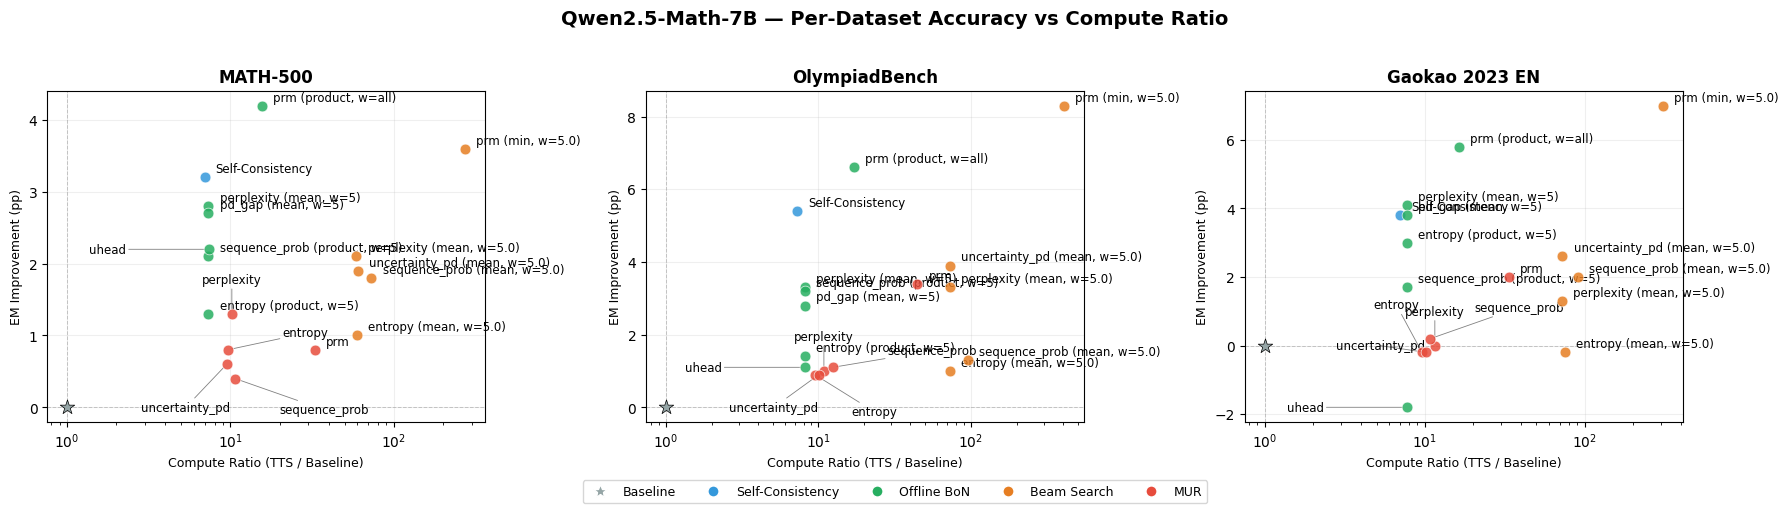

In [339]:
# ── Per-dataset charts ────────────────────────────────────────────────────────

if _tbl_q25 is not None:
    plot_accuracy_vs_compute_ratio_per_dataset(_tbl_q25, "Qwen2.5-Math-7B",
        save_path=_CHARTS_DIR / "qwen25_per_dataset_ratio.png")



=== Qwen2.5-Math-7B — Aggregate (excl. Minerva Math) ===

Note: excluding {'Minerva Math'} from averaging
  Saved chart to cache/combined_results/charts/2026-02-27_18-49/qwen25_aggregate_ratio.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Ratio (x)
────────────────────────────────────────────────────────────────────────────────────────────
Beam Search                         prm (min, w=5.0)                   +6.3         330.9x
Offline BoN                         prm (product, w=all)               +5.5          16.3x
Self-Consistency                                                       +4.1           7.0x
Offline BoN                         perplexity (mean, w=5)             +3.4           7.7x
Offline BoN                         pd_gap (mean, w=5)                 +3.1           7.7x
Beam Search                         uncertainty_pd (mean, w=5.0)          +2.8          68.6x
Offline BoN                         sequence_prob (product, w=5)    

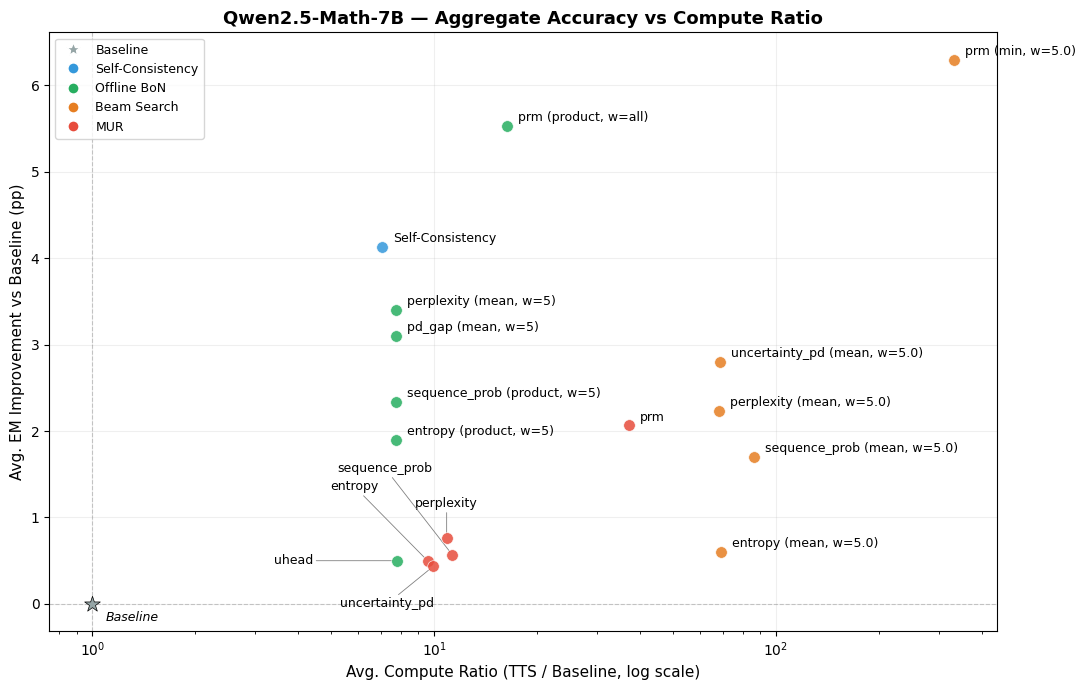

In [340]:
# ── Aggregate chart ───────────────────────────────────────────────────────────

if _tbl_q25 is not None:
    print("\n=== Qwen2.5-Math-7B — Aggregate (excl. Minerva Math) ===\n")
    pts, fig = plot_accuracy_vs_compute_ratio(_tbl_q25, "Qwen2.5-Math-7B — Aggregate Accuracy vs Compute Ratio",
        save_path=_CHARTS_DIR / "qwen25_aggregate_ratio.png", show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Ratio (x)':>14}")
        print("─" * 92)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>13.1f}x")
        print()
    plt.show()


### Qwen3-8B

  Saved chart to cache/combined_results/charts/2026-02-27_18-28/qwen3_per_dataset_ratio.png


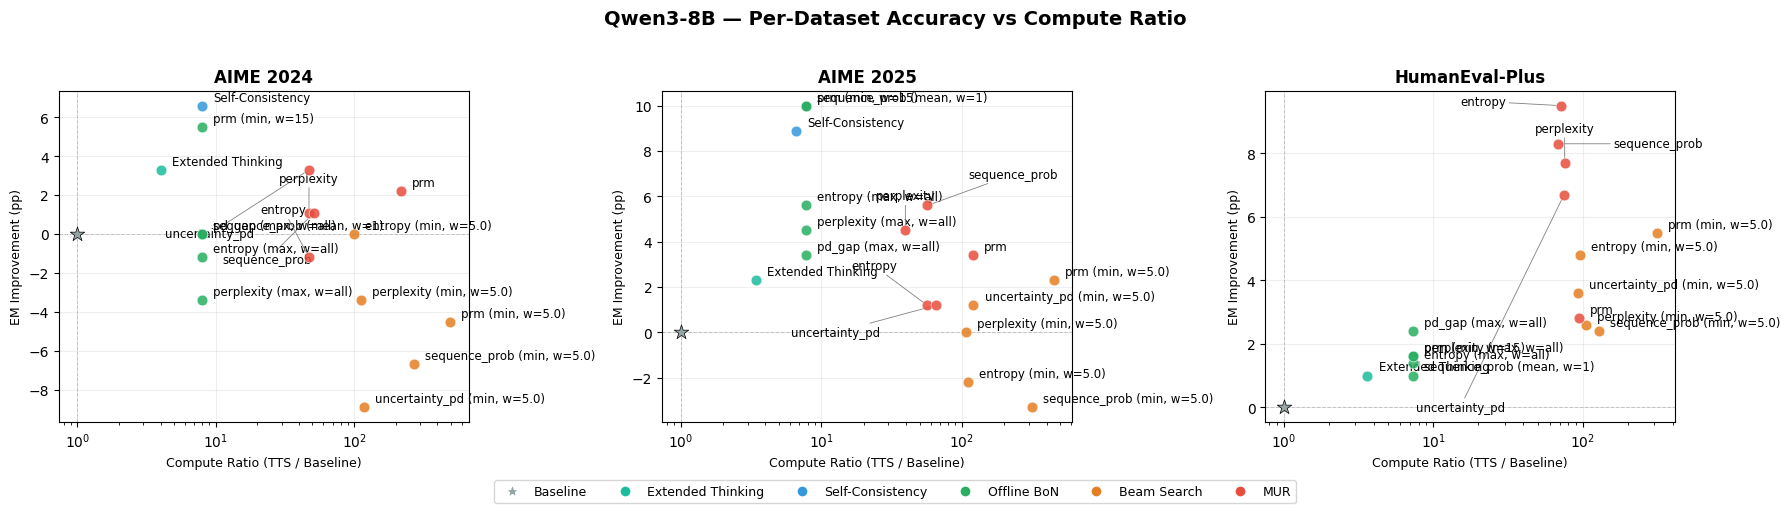

In [323]:
# ── Per-dataset charts ────────────────────────────────────────────────────────

if _tbl_q3 is not None:
    plot_accuracy_vs_compute_ratio_per_dataset(_tbl_q3, "Qwen3-8B",
        save_path=_CHARTS_DIR / "qwen3_per_dataset_ratio.png")



=== Qwen3-8B — AIME Aggregate (AIME 2024 + AIME 2025) ===

  Saved chart to cache/combined_results/charts/2026-02-27_18-28/qwen3_aime_aggregate_ratio.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Ratio (x)
────────────────────────────────────────────────────────────────────────────────────────────
Self-Consistency                                                       +7.8           7.3x
Offline BoN                         prm (min, w=15)                    +7.8           7.9x
Offline BoN                         sequence_prob (mean, w=1)          +5.0           7.9x
MUR                                 sequence_prob                      +3.3          54.1x
Extended Thinking                                                      +2.8           3.7x
MUR                                 perplexity                         +2.8          43.4x
MUR                                 prm                                +2.8         169.0x
MUR                    

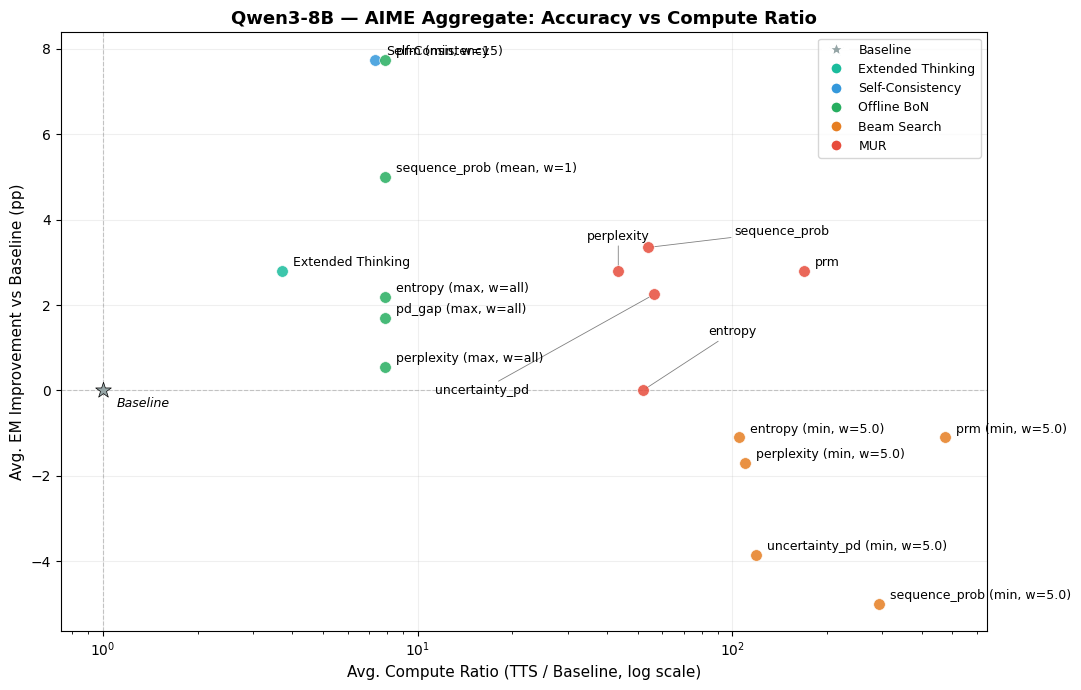


=== Qwen3-8B — HumanEval-Plus ===

  Saved chart to cache/combined_results/charts/2026-02-27_18-28/qwen3_humaneval_ratio.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Ratio (x)
────────────────────────────────────────────────────────────────────────────────────────────
MUR                                 entropy                            +9.5          71.6x
MUR                                 sequence_prob                      +8.3          68.3x
MUR                                 perplexity                         +7.7          75.7x
MUR                                 uncertainty_pd                     +6.7          75.1x
Beam Search                         prm (min, w=5.0)                   +5.5         312.8x
Beam Search                         entropy (min, w=5.0)               +4.8          96.4x
Beam Search                         uncertainty_pd (min, w=5.0)          +3.6          92.4x
MUR                                 prm           

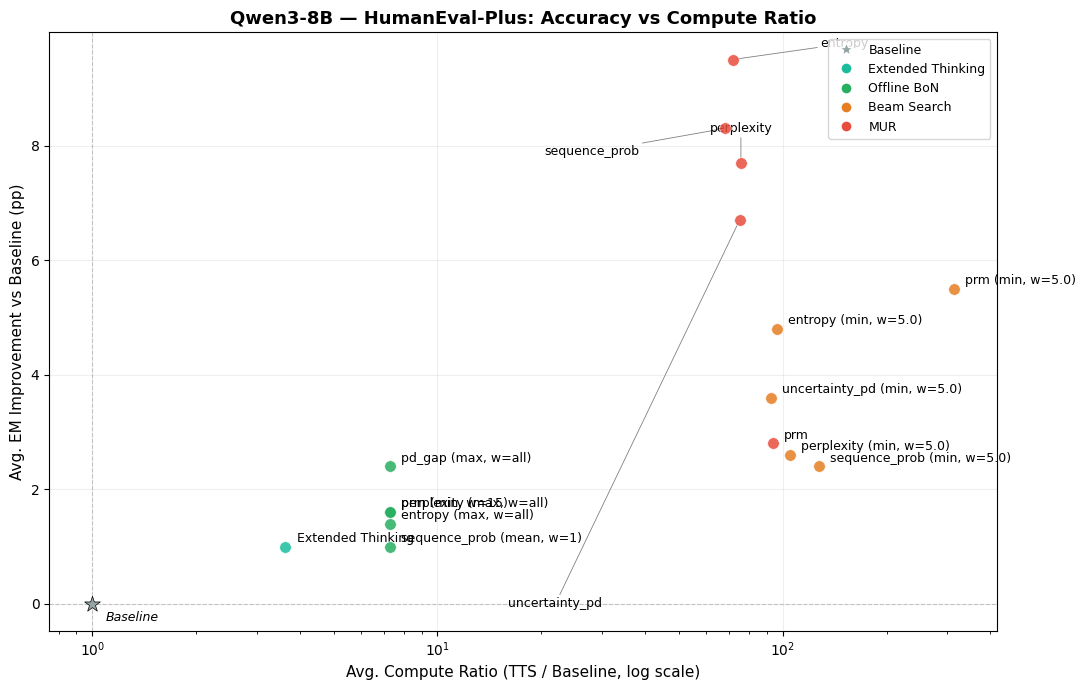

In [324]:
# ── Aggregate chart (AIME only) ───────────────────────────────────────────────

if _tbl_q3 is not None:
    print("\n=== Qwen3-8B — AIME Aggregate (AIME 2024 + AIME 2025) ===\n")
    pts, fig = plot_accuracy_vs_compute_ratio(_tbl_q3, "Qwen3-8B — AIME Aggregate: Accuracy vs Compute Ratio",
        save_path=_CHARTS_DIR / "qwen3_aime_aggregate_ratio.png",
        include_datasets=_AIME_DATASETS, show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Ratio (x)':>14}")
        print("─" * 92)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>13.1f}x")
        print()
    plt.show()

    # HumanEval-Plus separately
    print("\n=== Qwen3-8B — HumanEval-Plus ===\n")
    pts, fig = plot_accuracy_vs_compute_ratio(_tbl_q3, "Qwen3-8B — HumanEval-Plus: Accuracy vs Compute Ratio",
        save_path=_CHARTS_DIR / "qwen3_humaneval_ratio.png",
        include_datasets={"HumanEval-Plus"}, show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Ratio (x)':>14}")
        print("─" * 92)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>13.1f}x")
        print()
    plt.show()


## Qwen2.5-Math-7B-Instruct

  Saved chart to cache/combined_results/charts/2026-02-27_17-37/qwen25_per_dataset_overhead.png


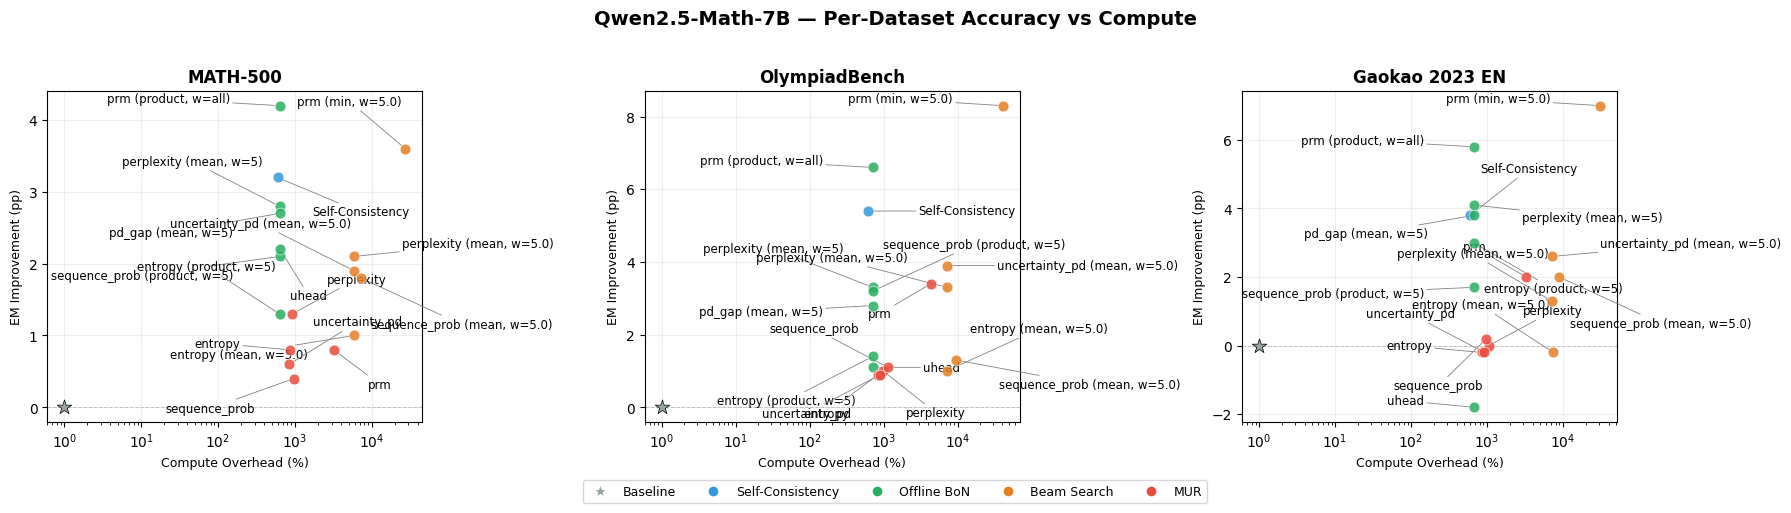

In [250]:
# ── Per-dataset charts ────────────────────────────────────────────────────────

if _tbl_q25 is not None:
    plot_accuracy_vs_compute_per_dataset(_tbl_q25, "Qwen2.5-Math-7B",
        save_path=_CHARTS_DIR / "qwen25_per_dataset_overhead.png")
else:
    print("Qwen2.5 combined results not found — run the combined results cells first")



=== Qwen2.5-Math-7B — Aggregate (excl. Minerva Math) ===

Note: excluding {'Minerva Math'} from averaging
  Saved chart to cache/combined_results/charts/2026-02-27_17-37/qwen25_aggregate_overhead.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Overhead (%)
───────────────────────────────────────────────────────────────────────────────────────────────
Beam Search                         prm (min, w=5.0)                   +6.3            32987
Offline BoN                         prm (product, w=all)               +5.5              673
Self-Consistency                                                       +4.1              605
Offline BoN                         perplexity (mean, w=5)             +3.4              673
Offline BoN                         pd_gap (mean, w=5)                 +3.1              673
Beam Search                         uncertainty_pd (mean, w=5.0)          +2.8             6763
Offline BoN                         sequence_pr

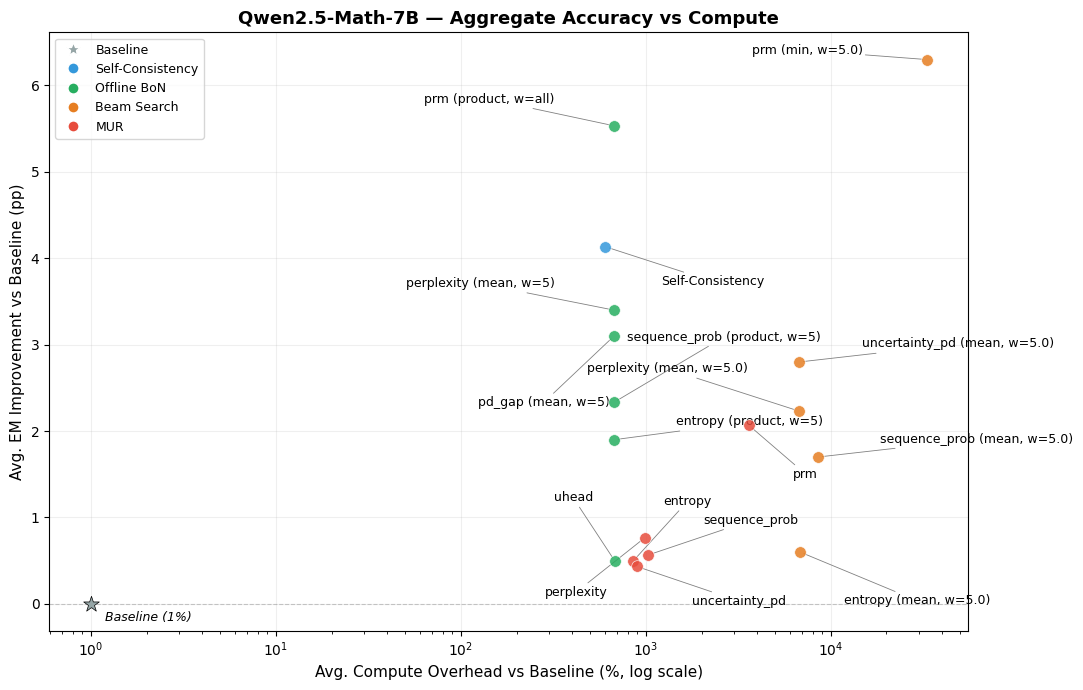

In [251]:
# ── Aggregate chart ───────────────────────────────────────────────────────────

if _tbl_q25 is not None:
    print("\n=== Qwen2.5-Math-7B — Aggregate (excl. Minerva Math) ===\n")
    pts, fig = plot_accuracy_vs_compute(_tbl_q25, "Qwen2.5-Math-7B — Aggregate Accuracy vs Compute",
        save_path=_CHARTS_DIR / "qwen25_aggregate_overhead.png", show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Overhead (%)':>17}")
        print("─" * 95)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>16.0f}")
        print()
    plt.show()


## Qwen3-8B

  Saved chart to cache/combined_results/charts/2026-02-27_17-37/qwen3_per_dataset_overhead.png


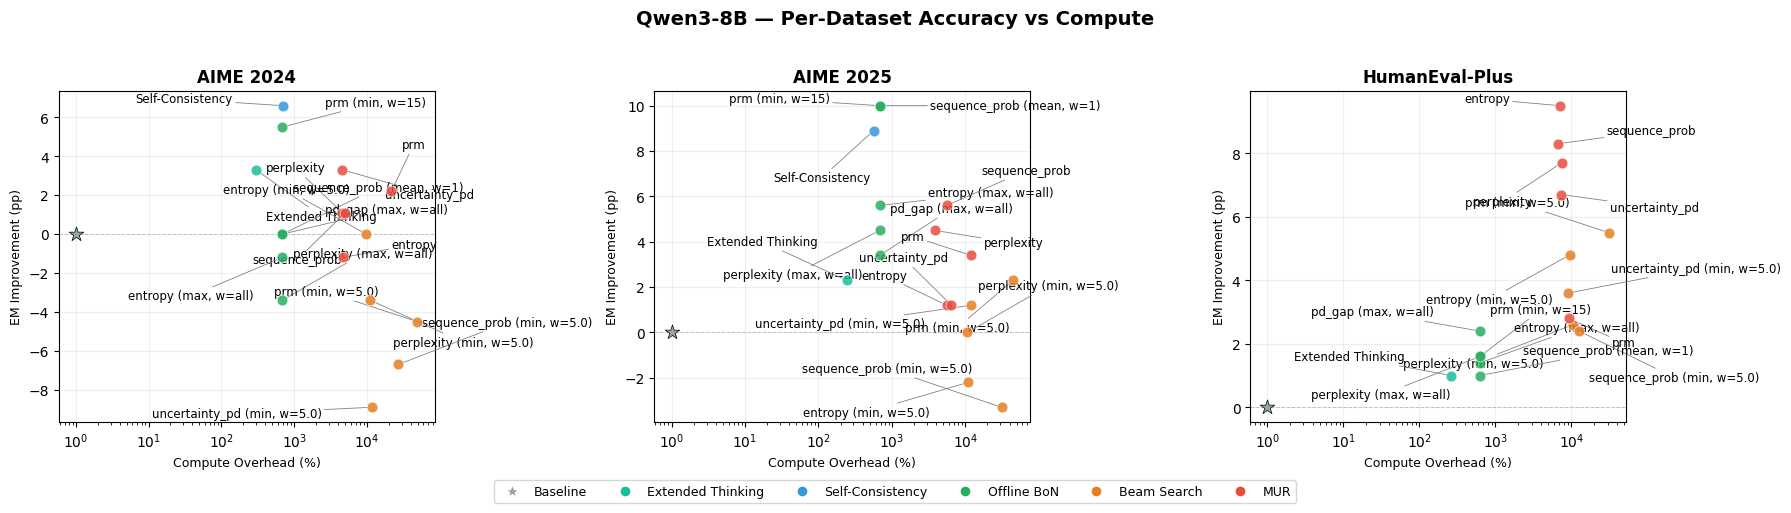

In [252]:
# ── Per-dataset charts ────────────────────────────────────────────────────────

if _tbl_q3 is not None:
    plot_accuracy_vs_compute_per_dataset(_tbl_q3, "Qwen3-8B",
        save_path=_CHARTS_DIR / "qwen3_per_dataset_overhead.png")
else:
    print("Qwen3 combined results not found — run the combined results cells first")



=== Qwen3-8B — AIME Aggregate (AIME 2024 + AIME 2025) ===

  Saved chart to cache/combined_results/charts/2026-02-27_17-37/qwen3_aime_aggregate_overhead.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Overhead (%)
───────────────────────────────────────────────────────────────────────────────────────────────
Self-Consistency                                                       +7.8              630
Offline BoN                         prm (min, w=15)                    +5.7              668
MUR                                 sequence_prob                      +5.0             5782
MUR                                 perplexity                         +4.4             5319
MUR                                 uncertainty_pd                     +3.7             6166
Offline BoN                         sequence_prob (mean, w=1)          +3.7              668
MUR                                 entropy                            +3.2             5753


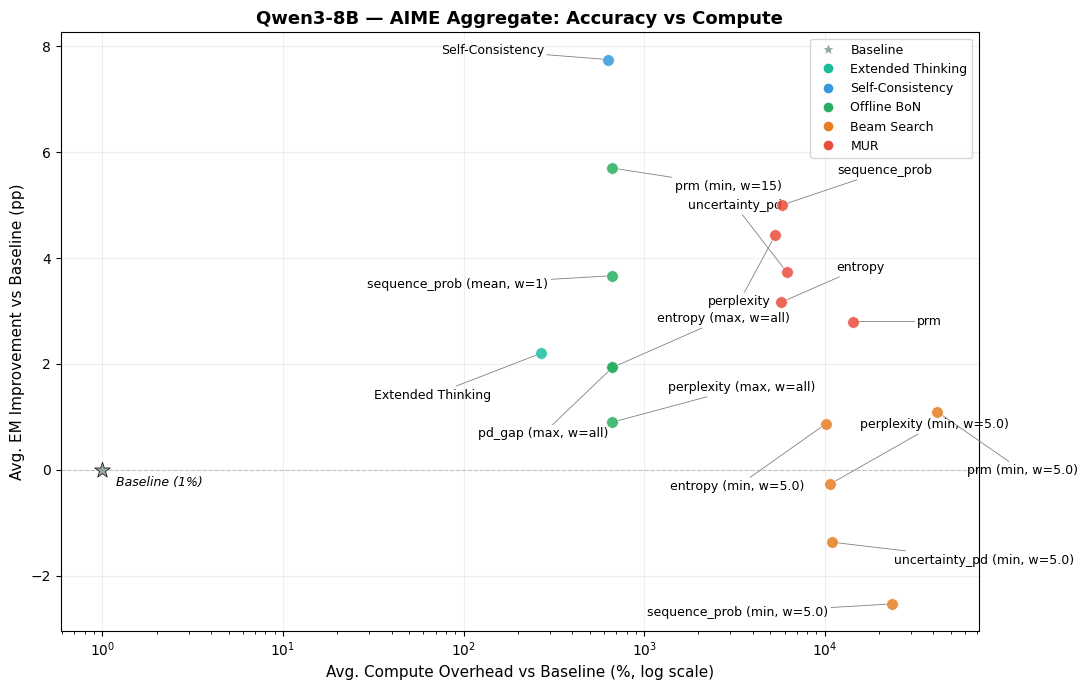


=== Qwen3-8B — HumanEval-Plus ===

  Saved chart to cache/combined_results/charts/2026-02-27_17-37/qwen3_humaneval_overhead.png
Strategy                            Scorer                     Avg Δ EM (pp)  Avg Overhead (%)
───────────────────────────────────────────────────────────────────────────────────────────────
Self-Consistency                                                       +7.8              630
Offline BoN                         prm (min, w=15)                    +5.7              668
MUR                                 sequence_prob                      +5.0             5782
MUR                                 perplexity                         +4.4             5319
MUR                                 uncertainty_pd                     +3.7             6166
Offline BoN                         sequence_prob (mean, w=1)          +3.7              668
MUR                                 entropy                            +3.2             5753
MUR                          

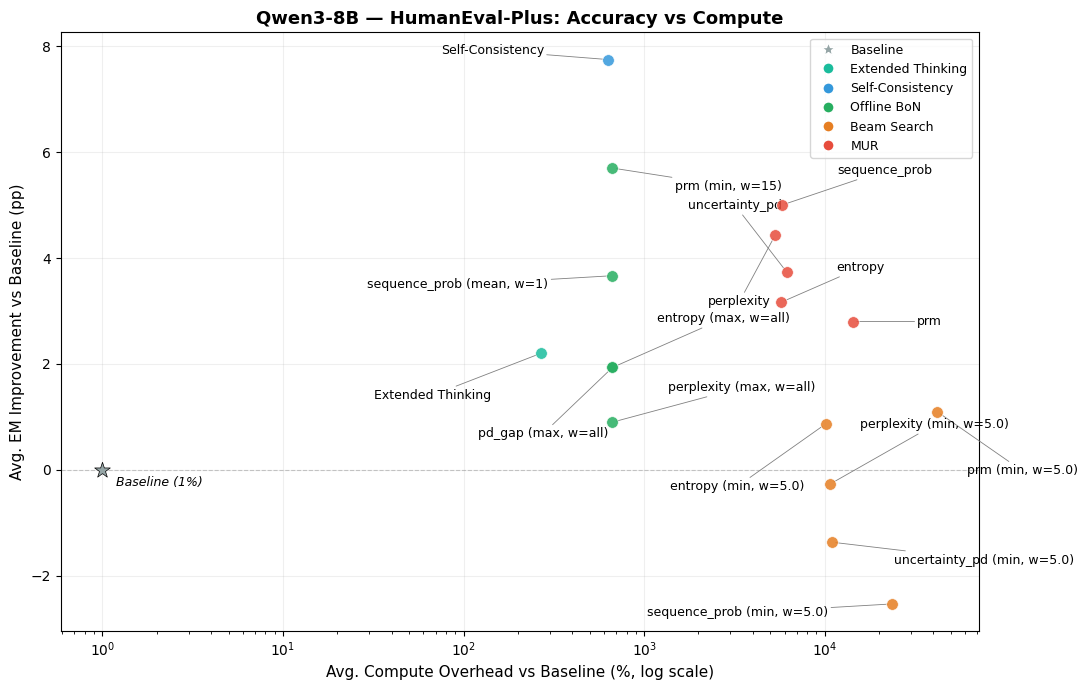

In [253]:
# ── Aggregate chart (AIME only) ───────────────────────────────────────────────

_AIME_DATASETS = {"AIME 2024", "AIME 2025"}

if _tbl_q3 is not None:
    print("\n=== Qwen3-8B — AIME Aggregate (AIME 2024 + AIME 2025) ===\n")
    pts, fig = plot_accuracy_vs_compute(_tbl_q3, "Qwen3-8B — AIME Aggregate: Accuracy vs Compute",
        save_path=_CHARTS_DIR / "qwen3_aime_aggregate_overhead.png",
        include_datasets=_AIME_DATASETS, show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Overhead (%)':>17}")
        print("─" * 95)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>16.0f}")
        print()
    plt.show()

    # HumanEval-Plus separately
    print("\n=== Qwen3-8B — HumanEval-Plus ===\n")
    pts, fig = plot_accuracy_vs_compute(_tbl_q3, "Qwen3-8B — HumanEval-Plus: Accuracy vs Compute",
        save_path=_CHARTS_DIR / "qwen3_humaneval_overhead.png",
        include_datasets={"HumanEval-Plus"}, show=False)
    if pts:
        print(f"{'Strategy':<35} {'Scorer':<25} {'Avg Δ EM (pp)':>14} {'Avg Overhead (%)':>17}")
        print("─" * 95)
        for p in sorted(pts, key=lambda x: x["y"], reverse=True):
            print(f"{p['strat']:<35} {p['scorer']:<25} {p['y']:>+13.1f} {p['x']:>16.0f}")
        print()
    plt.show()
